https://www.kaggle.com/competitions/ieee-fraud-detection

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

     |████████████████████████████████| 31.2 MB 823 kB/s eta 0:00:011
ERROR: sktime 0.18.0 has requirement pandas<2.0.0,>=1.1.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: pycaret 3.0.0 has requirement pandas<1.6.0,>=1.3.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.10.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.24.4 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 1.1.1 which is incompatible.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0
     |████████████████████████████████| 16.9 MB 1.0 MB/s eta 0:00:011
ERROR: sktime 0.18.0 has requirement pandas<2.0.0,>=1.1.0, but you'll have pandas 2.0.

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from scipy import stats
pd.options.display.precision = 15

#import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [3]:
start_time = time.time()

In [4]:
%%time

#limpando cache do CUDA
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [5]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [6]:
#limpando cache do CUDA
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [7]:
t0 = time.time()

In [8]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [9]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

Olhando as estatísticas básicas através da função `resumetable`

In [10]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [11]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
7,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000


In [12]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int64,0,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float64,0,14119,31.949999999999999,49.0,171.0,8.080000000000000
3,ProductCD,object,0,5,W,W,W,1.370000000000000
4,card1,int64,0,13244,10409,4272,4476,9.949999999999999
5,card2,float64,8654,497,111.0,111.0,574.0,6.280000000000000
6,card3,float64,3002,115,150.0,150.0,150.0,0.810000000000000
7,card4,object,3086,4,visa,visa,visa,1.050000000000000
8,card5,float64,4547,102,226.0,226.0,226.0,2.630000000000000
9,card6,object,3007,3,debit,debit,debit,0.790000000000000


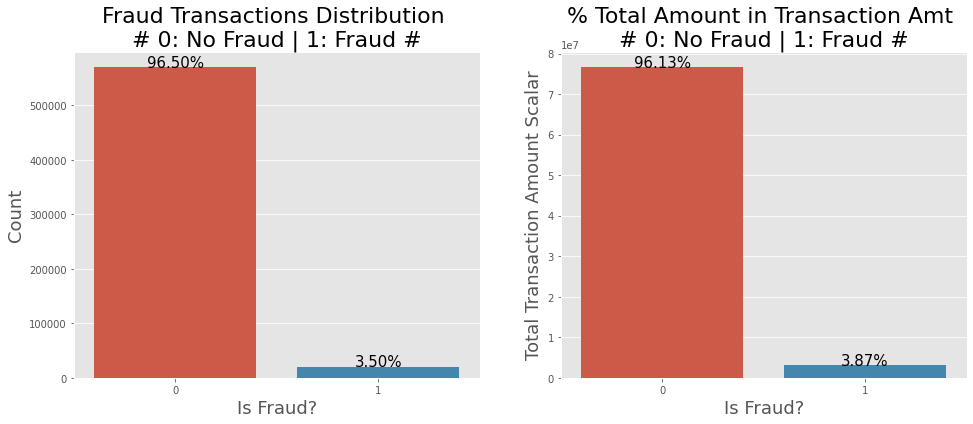

In [13]:
# checando o desbalanceamento dos dados através da contagem de linhas e TransactionAmt
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)
    
#plt.show()

In [14]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [15]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [16]:
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

In [17]:
for i in list(train):
    #str() converte número em string
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [18]:
# Converting to Total Days, Weekdays and Hours
# We will use the first date as 2017-12-01 and use the delta time to compute datetime features

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [19]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [20]:
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [21]:
# checando as diferenças entre nomes de colunas da base treino e teste
# para equalizar mudanças
pd.set_option('display.max_rows', 500)
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [22]:
# renomear colunas de teste e de treino
test.columns = test.columns.str.replace('-', '_')
#test.rename(columns = {'id-07':'id_07', 'id-08': 'id_08', 'id-21': 'id_21', 'id-22': 'id_22', 'id-23': 'id_23', 'id-24': 'id_24', 'id-25': 'id_25', 
#                       'id-26':'id_26', 'id-27': 'id_27', 'id-18': 'id_18'}, inplace = True)

In [23]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [24]:
# colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]

# colunas com mais de 90% de valores únicos
big_top_value_cols_train = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]

# colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]

many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# concatenar todas as colunas desnecessárias
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [26]:
train = train.drop(cols_to_drop, axis=1)

In [27]:
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Linhas com Valores Faltantes 

In [29]:
# Delete rows containing either 75% or more than 75% NaN Values
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

In [30]:
# Delete rows containing either 75% or more than 75% NaN Values
perc = 75.0 
min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [31]:
train.shape

(590540, 92)

In [32]:
test.shape

(506691, 91)

## Substituindo NaNs remanescentes por 0 para pacotes de balanceamento e redução de dimensionalidade

In [33]:
# replace NaN by 0 to run PCA and t-SNE
train.replace(np.nan, 0, inplace=True)

## Encoding de variáveis categóricas (para pacotes de redução de dimensionalidade)

### Encoding categorical features

#### Using LabelEncoder

In [34]:
# finding out the featues identified as "object" to encode them
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [35]:
object_columns_treated = ['ProductCD', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_28', 'id_29',
       'id_31', 'D2', 'D3', 'D15', 'C5', 'D4', 'D5', 'D1', 'C9', 'C11', 'D10', 'D11', 'C14', 'C6', 'dist1', 'C13']

In [36]:
from sklearn import preprocessing
le = LabelEncoder()

In [37]:
for col in object_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [38]:
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 92)


,Name,dtypes


In [39]:
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 91)


,Name,dtypes


In [40]:
# You could use df._get_numeric_data() to get numeric columns and then find out categorical columns
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['Date']

In [41]:
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['Date']

In [42]:
# checking for columns difference between train and test
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Separando a variável target da base de treino

In [43]:
# fazer cópia dos datasets antes de retirar as colunas para balanceamento e redução de dimensionalidade
train_0 = train.copy()
test_0 = test.copy()

# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [44]:
# checking for columns difference between train and test
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

In [45]:
X_train = train.drop('isFraud',axis = 1)
y_train = train['isFraud'].astype('uint8')

In [46]:
y_train.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

# Redução de Dimensionalidade

## Seleção de Features com Teste do Qui-Quadrado

This is a form of non-parametric test (a test wherein median is an important parameter) in which feature selection is done with the help of hypothesis testing and p-value. The feature selection is only suited to categorical features or features having discrete data contained within it. The continuous features are not taken into account and therefore should not be used while performing this test. The formula for this type of test is given as:

Summation (Observed Value – Expected Value) / Expected Value

If the p-value is less than 0.05 then we reject the null hypothesis and go with the alternate hypothesis in this type of test.

In [47]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [48]:
# 20 features
model_20_chi2 = SelectKBest(chi2, k = 20)
new_20_chi2 = model_20_chi2.fit(X_train, y_train)
X_20_chi2 = new_20_chi2.transform(X_train)
# getting the feature names and converting them into a dataframe
cols = new_20_chi2.get_support(indices = True)
features_df_new_20_chi2 = X_train.iloc[:, cols]
#features_df_new_20_chi2

In [49]:
# 50 features
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train, y_train)
X_50_chi2 = new_50_chi2.transform(X_train)
# getting the feature names and converting them into a dataframe
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train.iloc[:, cols]
#features_df_new_50_chi2

## Seleção de Features com Teste ANOVA

A feature selection technique is most suited to filter features wherein categorical and continuous data is involved. It is a type of parametric test which means it assumes a normal distribution of data forming a bell shape curve. There are many types of Anova test out there and a user can try out these as per their need. The assumption here is made as per the hypothesis testing where the null hypothesis states that there is no difference in the means and alternate says that there is a difference. If the p-value is less than 0.05 then the null hypothesis is rejected and the features are selected or else dropped if the null hypothesis becomes true. The implementation of this feature selection technique is given below with the help of Scikit Learn library

In [50]:
from sklearn.feature_selection import f_classif

In [51]:
# 20 features
model_20_anova = SelectKBest(score_func = f_classif, k = 20)
new_20_anova = model_20_anova.fit(X_train, y_train)
X_20_anova = new_20_anova.transform(X_train)
# getting the feature names and converting them into a dataframe
cols = new_20_anova.get_support(indices = True)
features_df_new_20_anova = X_train.iloc[:, cols]
#features_df_new_20_anova

In [52]:
# 50 features
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train, y_train)
X_50_anova = new_50_anova.transform(X_train)
# getting the feature names and converting them into a dataframe
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train.iloc[:, cols]
#features_df_new_50_anova

## Seleção de Features com Análise de Correlação

In [53]:
train = pd.concat([X_train, y_train], axis = 1)

In [54]:
import time

In [55]:
pd.set_option('display.max_rows', 500)

In [56]:
%%time
topcorr = train.corr(method = 'spearman')['isFraud'].sort_values()[:-1]
topcorr_tail_20 = topcorr.tail(20)
#topcorr_tail_20

CPU times: user 32.4 s, sys: 160 ms, total: 32.6 s
Wall time: 32.5 s


In [57]:
topcorr_tail_50 = topcorr.tail(50)
#topcorr_tail_50

# Balanceamento de Classes

## Usando sklearn-resample

### Informações Gerais

https://www.kaggle.com/code/arthursilveirasc/resampling-strategies-for-imbalanced-datasets/edit

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

In [58]:
# utilizando seleção de features
cols_20_chi2 = features_df_new_20_chi2.columns
cols_50_chi2 = features_df_new_50_chi2.columns
cols_20_anova = features_df_new_20_anova.columns
cols_50_anova = features_df_new_50_anova.columns
cols_topcorr_20 = topcorr_tail_20.index
cols_topcorr_50 = topcorr_tail_50.index

### Oversampling com SMOTE

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
smote = SMOTE()

In [61]:
%%time

X_oversample_with_smote, y_oversample_with_smote = smote.fit_resample(X_train, y_train)

CPU times: user 6.04 s, sys: 941 ms, total: 6.98 s
Wall time: 2.15 s


### Oversampling com Borderline-SMOTE

In [62]:
from imblearn.over_sampling import BorderlineSMOTE

In [63]:
smote = BorderlineSMOTE()

In [64]:
%%time

X_oversample_with_borderline_smote, y_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

CPU times: user 2min, sys: 353 ms, total: 2min
Wall time: 12 s


### Oversampling com AdaSyn

In [65]:
from imblearn.over_sampling import ADASYN

In [66]:
adasyn = ADASYN()

In [67]:
%%time

X_oversample_with_adasyn, y_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

CPU times: user 2min 1s, sys: 365 ms, total: 2min 2s
Wall time: 12.2 s


### Undersampling com Near Miss

In [68]:
from imblearn.under_sampling import NearMiss

In [69]:
nm = NearMiss()

In [70]:
%%time

X_undersample_with_near_miss, y_undersample_with_near_miss = nm.fit_resample(X_train, y_train)

CPU times: user 1min 57s, sys: 132 ms, total: 1min 57s
Wall time: 10.5 s


### Undersampling com One Sided Selection

In [71]:
from imblearn.under_sampling import OneSidedSelection

In [72]:
oss = OneSidedSelection()

In [73]:
%%time

X_undersample_with_one_sided_selection, y_undersample_with_one_sided_selection = oss.fit_resample(X_train, y_train)

CPU times: user 1h 6min 58s, sys: 1.68 s, total: 1h 6min 59s
Wall time: 5min 47s


### Undersampling com Neighbourhood Cleaning Rule

In [74]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [75]:
ncl = NeighbourhoodCleaningRule()

In [76]:
%%time

X_undersample_with_neighbourhood_cleaning_rule, y_undersample_with_neighbourhood_cleaning_rule = \
ncl.fit_resample(X_train, y_train)

CPU times: user 1h 4min 57s, sys: 1.02 s, total: 1h 4min 58s
Wall time: 5min 36s


### Undersampling com Edited Nearest Neighbours

In [77]:
from imblearn.under_sampling import EditedNearestNeighbours

In [78]:
enn = EditedNearestNeighbours()

In [79]:
%%time

X_undersample_with_enn, y_undersample_with_enn = enn.fit_resample(X_train, y_train)

CPU times: user 1h 2min 54s, sys: 775 ms, total: 1h 2min 55s
Wall time: 5min 17s


### Undersampling com Tomek Links

In [80]:
from imblearn.under_sampling import TomekLinks

In [81]:
undersample = TomekLinks()

In [82]:
%%time

X_undersample_with_tomek_links, y_undersample_with_tomek_links = undersample.fit_resample(X_train, y_train)

CPU times: user 1h 5min 9s, sys: 904 ms, total: 1h 5min 10s
Wall time: 5min 28s


### Undersampling com All KNN

In [83]:
from imblearn.under_sampling import AllKNN

In [84]:
allknn = AllKNN()

In [85]:
%%time

X_undersample_with_all_knn, y_undersample_with_all_knn = allknn.fit_resample(X_train, y_train)

CPU times: user 3h 2min 54s, sys: 2.29 s, total: 3h 2min 57s
Wall time: 15min 21s


### Undersampling com Instance Hardness

In [86]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [87]:
iht = InstanceHardnessThreshold()

In [88]:
%%time

X_undersample_with_iht, y_undersample_with_iht = iht.fit_resample(X_train, y_train)

CPU times: user 7min 27s, sys: 268 ms, total: 7min 28s
Wall time: 7min 28s


### Undersampling com Repeated Edited Nearest Neighbours

In [89]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [90]:
renn = RepeatedEditedNearestNeighbours()

In [91]:
%%time

X_undersample_with_repeated_edited_nearest_neighbours, y_undersample_with_repeated_edited_nearest_neighbours = \
renn.fit_resample(X_train, y_train)

CPU times: user 8h 27min 40s, sys: 6.33 s, total: 8h 27min 46s
Wall time: 42min 35s


# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [92]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [93]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgbm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [94]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_xgb = XGBClassifier()
clf_lgbm = lgbm.LGBMClassifier()
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_svm = svm.SVC()
clf_gnb = GaussianNB()

## Validação Cruzada para Undersampling com Near Miss

In [95]:
X_undersample_with_near_miss_train, X_undersample_with_near_miss_test, \
y_undersample_with_near_miss_train, y_undersample_with_near_miss_test = \
train_test_split(X_undersample_with_near_miss, y_undersample_with_near_miss, test_size = .2, random_state = 1)

### 20-Chi Square

In [96]:
%%time

clf_et.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9541509174325356
Avg f1_score : 0.9525424073335138
Avg recall : 0.9289772795038462
Avg precision : 0.9774862447569257
CPU times: user 12.5 s, sys: 3 µs, total: 12.5 s
Wall time: 12.5 s


In [97]:
%%time

clf_rf.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9076968007706023
Avg f1_score : 0.8985209629719855
Avg recall : 0.8254845250163994
Avg precision : 0.9862094469328702
CPU times: user 7.15 s, sys: 4 ms, total: 7.16 s
Wall time: 7.16 s


In [98]:
%%time

clf_dt.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9560859139630684
Avg f1_score : 0.954471069774954
Avg recall : 0.929218796588944
Avg precision : 0.9812086165947713
CPU times: user 493 ms, sys: 0 ns, total: 493 ms
Wall time: 492 ms


In [99]:
%%time

clf_cb.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9560859139630684
Avg f1_score : 0.954471069774954
Avg recall : 0.929218796588944
Avg precision : 0.9812086165947713
CPU times: user 492 ms, sys: 0 ns, total: 492 ms
Wall time: 491 ms


In [100]:
%%time

clf_gbc.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9468909474719733
Avg f1_score : 0.9448308459597335
Avg recall : 0.9177452442006084
Avg precision : 0.973732137616395
CPU times: user 10.6 s, sys: 1e+03 ns, total: 10.6 s
Wall time: 10.6 s


In [101]:
%%time

clf_ada.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9495518970812556
Avg f1_score : 0.9474397138176703
Avg recall : 0.9175037271155109
Avg precision : 0.9795288041387881
CPU times: user 16.4 s, sys: 3 µs, total: 16.4 s
Wall time: 16.4 s


In [102]:
%%time

clf_lr.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9205194831811354
Avg f1_score : 0.9167041248352614
Avg recall : 0.8826024211342359
Avg precision : 0.9538197086839609
CPU times: user 7.77 s, sys: 17.9 s, total: 25.7 s
Wall time: 2.15 s


In [103]:
%%time

clf_knn.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9484628942676203
Avg f1_score : 0.9462318402874219
Avg recall : 0.9150593356789315
Avg precision : 0.9796413360382573
CPU times: user 8.56 s, sys: 468 ms, total: 9.02 s
Wall time: 1.09 s


In [104]:
%%time

clf_gnb.fit(X_undersample_with_near_miss_train[cols_20_chi2], y_undersample_with_near_miss_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_20_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.9201578973564709
Avg f1_score : 0.912930727976889
Avg recall : 0.8455012224938876
Avg precision : 0.9924413619921422
CPU times: user 210 ms, sys: 2 µs, total: 210 ms
Wall time: 209 ms


### 50 Chi-Square

In [105]:
%%time

clf_et.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9503996474904186
Avg f1_score : 0.9493264895986743
Avg recall : 0.9377643270320233
Avg precision : 0.9613375668466443
CPU times: user 16.7 s, sys: 8 ms, total: 16.7 s
Wall time: 16.7 s


In [106]:
%%time

clf_rf.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9096322364742015
Avg f1_score : 0.9009259420304675
Avg recall : 0.8298759615958018
Avg precision : 0.985682108111628
CPU times: user 7.87 s, sys: 7.99 ms, total: 7.88 s
Wall time: 7.87 s


In [107]:
%%time

clf_dt.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9421717400915238
Avg f1_score : 0.9412381746276537
Avg recall : 0.9338571172997794
Avg precision : 0.9489725247095416
CPU times: user 1.19 s, sys: 1e+03 ns, total: 1.19 s
Wall time: 1.19 s


In [108]:
%%time

clf_cb.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.5508390	total: 68.1ms	remaining: 272ms
1:	learn: 0.4485905	total: 83.4ms	remaining: 125ms
2:	learn: 0.3791228	total: 91.3ms	remaining: 60.8ms
3:	learn: 0.3210447	total: 97.6ms	remaining: 24.4ms
4:	learn: 0.2826207	total: 103ms	remaining: 0us
0:	learn: 0.5542586	total: 11.2ms	remaining: 44.9ms
1:	learn: 0.4598866	total: 21.1ms	remaining: 31.7ms
2:	learn: 0.3863968	total: 28ms	remaining: 18.7ms
3:	learn: 0.3335509	total: 32.7ms	remaining: 8.19ms
4:	learn: 0.2937128	total: 36.7ms	remaining: 0us
0:	learn: 0.5534245	total: 9.72ms	remaining: 38.9ms
1:	learn: 0.4586274	total: 19.4ms	remaining: 29.1ms
2:	learn: 0.3846607	total: 28.1ms	remaining: 18.7ms
3:	learn: 0.3313237	total: 33.9ms	remaining: 8.47ms
4:	learn: 0.2904282	total: 38.1ms	remaining: 0us
0:	learn: 0.5532886	total: 10.6ms	remaining: 42.4ms
1:	learn: 0.4564663	total: 20.5ms	remaining: 30.8ms
2:	learn: 0.3878371	total: 27.8ms	remaining: 18.6ms
3:	learn: 0.3374738	total: 32.7ms	remaining: 8.18ms
4:	learn: 0.2951077	total:

In [109]:
%%time

clf_gbc.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9547555123539386
Avg f1_score : 0.9532815891259847
Avg recall : 0.9316590136561513
Avg precision : 0.9760518889279416
CPU times: user 17.8 s, sys: 7.99 ms, total: 17.8 s
Wall time: 17.8 s


In [110]:
%%time

clf_ada.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9557231570102269
Avg f1_score : 0.954196735958668
Avg recall : 0.9309267100005962
Avg precision : 0.9787631393670045
CPU times: user 25.5 s, sys: 7 µs, total: 25.5 s
Wall time: 25.5 s


In [111]:
%%time

clf_lr.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9357642050528326
Avg f1_score : 0.9331462376648526
Avg recall : 0.9045679527699922
Avg precision : 0.9637031450383875
CPU times: user 12.1 s, sys: 20.2 s, total: 32.3 s
Wall time: 2.7 s


In [112]:
%%time

clf_knn.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9476163149866345
Avg f1_score : 0.9450461461606163
Avg recall : 0.9089558113185046
Avg precision : 0.9841725301096795
CPU times: user 9.42 s, sys: 392 ms, total: 9.81 s
Wall time: 1.19 s


In [113]:
%%time

clf_gnb.fit(X_undersample_with_near_miss_train[cols_50_chi2], y_undersample_with_near_miss_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_50_chi2], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.923544800044503
Avg f1_score : 0.9167614980399824
Avg recall : 0.8501401395432048
Avg precision : 0.9948678528290985
CPU times: user 294 ms, sys: 0 ns, total: 294 ms
Wall time: 293 ms


### 20 Anova

In [114]:
%%time

clf_et.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8421234310542202
Avg f1_score : 0.8306764766511101
Avg recall : 0.7813089629673803
Avg precision : 0.8870321072397473
CPU times: user 10.1 s, sys: 4 ms, total: 10.1 s
Wall time: 10.1 s


In [115]:
%%time

clf_rf.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7700211681418002
Avg f1_score : 0.7626410150534528
Avg recall : 0.7454278728606357
Avg precision : 0.7811343241090597
CPU times: user 6.02 s, sys: 5 µs, total: 6.02 s
Wall time: 6.02 s


In [116]:
%%time

clf_dt.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.8421234310542204
Avg f1_score : 0.8306825899310736
Avg recall : 0.7813089629673804
Avg precision : 0.8870350653119425
CPU times: user 332 ms, sys: 4 ms, total: 336 ms
Wall time: 334 ms


In [117]:
%%time

clf_cb.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.5968675	total: 8.02ms	remaining: 32.1ms
1:	learn: 0.5382744	total: 10.5ms	remaining: 15.7ms
2:	learn: 0.4961887	total: 13ms	remaining: 8.67ms
3:	learn: 0.4679922	total: 15.4ms	remaining: 3.86ms
4:	learn: 0.4482324	total: 17.9ms	remaining: 0us
0:	learn: 0.6004799	total: 6.43ms	remaining: 25.7ms
1:	learn: 0.5374976	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.4954421	total: 19.8ms	remaining: 13.2ms
3:	learn: 0.4653548	total: 25.2ms	remaining: 6.31ms
4:	learn: 0.4402031	total: 29.3ms	remaining: 0us
0:	learn: 0.6011116	total: 6.52ms	remaining: 26.1ms
1:	learn: 0.5374186	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.4911770	total: 19.7ms	remaining: 13.1ms
3:	learn: 0.4595130	total: 26ms	remaining: 6.51ms
4:	learn: 0.4372051	total: 30.5ms	remaining: 0us
0:	learn: 0.6014026	total: 6.46ms	remaining: 25.8ms
1:	learn: 0.5387911	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.4970230	total: 19.9ms	remaining: 13.2ms
3:	learn: 0.4641118	total: 26ms	remaining: 6.49ms
4:	learn: 0.4403311	total: 

In [118]:
%%time

clf_gbc.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8374058339750139
Avg f1_score : 0.8263256812337547
Avg recall : 0.780818176396923
Avg precision : 0.8782209895627362
CPU times: user 6.05 s, sys: 4.01 ms, total: 6.05 s
Wall time: 6.05 s


In [119]:
%%time

clf_ada.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8352291458669423
Avg f1_score : 0.8259323377003212
Avg recall : 0.7900846800644046
Avg precision : 0.8664208907359617
CPU times: user 11.4 s, sys: 4 ms, total: 11.4 s
Wall time: 11.4 s


In [120]:
%%time

clf_lr.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.8076464422589892
Avg f1_score : 0.791211466600673
Avg recall : 0.7356652155763612
Avg precision : 0.8562320797700249
CPU times: user 7.46 s, sys: 17.2 s, total: 24.6 s
Wall time: 2.07 s


In [121]:
%%time

clf_knn.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8129790280221695
Avg f1_score : 0.8128591880725103
Avg recall : 0.7922792056771424
Avg precision : 0.8487024484239427
CPU times: user 8.68 s, sys: 356 ms, total: 9.03 s
Wall time: 1.1 s


In [122]:
%%time

clf_gnb.fit(X_undersample_with_near_miss_train[cols_20_anova], y_undersample_with_near_miss_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_20_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.7959117379249365
Avg f1_score : 0.7925117164026806
Avg recall : 0.7864374739101915
Avg precision : 0.7989499444225989
CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 221 ms


### 50 Anova

In [123]:
%%time

clf_et.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.921243386785575
Avg f1_score : 0.9170403994597773
Avg recall : 0.8784495199475222
Avg precision : 0.959412281306626
CPU times: user 13.5 s, sys: 6 µs, total: 13.5 s
Wall time: 13.5 s


In [124]:
%%time

clf_rf.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.898376816346607
Avg f1_score : 0.896553216306612
Avg recall : 0.8884507126244857
Avg precision : 0.9050709957473784
CPU times: user 6.69 s, sys: 4.01 ms, total: 6.69 s
Wall time: 6.69 s


In [125]:
%%time

clf_dt.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9241474918826178
Avg f1_score : 0.9199467959416513
Avg recall : 0.8796708211580894
Avg precision : 0.9643279956262368
CPU times: user 587 ms, sys: 0 ns, total: 587 ms
Wall time: 586 ms


In [126]:
%%time

clf_cb.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.5531243	total: 8.83ms	remaining: 35.3ms
1:	learn: 0.4573860	total: 12ms	remaining: 18ms
2:	learn: 0.3939875	total: 15.1ms	remaining: 10.1ms
3:	learn: 0.3553669	total: 18.2ms	remaining: 4.56ms
4:	learn: 0.3223431	total: 21.2ms	remaining: 0us
0:	learn: 0.5674314	total: 8.26ms	remaining: 33ms
1:	learn: 0.4822653	total: 16.7ms	remaining: 25ms
2:	learn: 0.4101255	total: 24.7ms	remaining: 16.4ms
3:	learn: 0.3672289	total: 30ms	remaining: 7.51ms
4:	learn: 0.3354513	total: 34.2ms	remaining: 0us
0:	learn: 0.5622312	total: 8.49ms	remaining: 33.9ms
1:	learn: 0.4781311	total: 16.6ms	remaining: 24.9ms
2:	learn: 0.4073587	total: 24.7ms	remaining: 16.5ms
3:	learn: 0.3639170	total: 30.1ms	remaining: 7.53ms
4:	learn: 0.3321822	total: 34.2ms	remaining: 0us
0:	learn: 0.5633471	total: 8.42ms	remaining: 33.7ms
1:	learn: 0.4800783	total: 17.1ms	remaining: 25.7ms
2:	learn: 0.4089145	total: 25.2ms	remaining: 16.8ms
3:	learn: 0.3659426	total: 30.8ms	remaining: 7.7ms
4:	learn: 0.3340824	total: 35ms	

In [127]:
%%time

clf_gbc.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9281407461843181
Avg f1_score : 0.9246995580270001
Avg recall : 0.891386486970004
Avg precision : 0.9610239205753308
CPU times: user 10.5 s, sys: 4.01 ms, total: 10.5 s
Wall time: 10.5 s


In [128]:
%%time

clf_ada.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9260840987143941
Avg f1_score : 0.9225473524195065
Avg recall : 0.8889486552567236
Avg precision : 0.9592022445922991
CPU times: user 17.6 s, sys: 7.99 ms, total: 17.6 s
Wall time: 17.6 s


In [129]:
%%time

clf_lr.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9116858097326608
Avg f1_score : 0.9068967241454191
Avg recall : 0.868436996839406
Avg precision : 0.9492353764895342
CPU times: user 14.7 s, sys: 23.3 s, total: 38.1 s
Wall time: 3.19 s


In [130]:
%%time

clf_knn.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8906497126344235
Avg f1_score : 0.89519501866463
Avg recall : 0.8933353211282723
Avg precision : 0.9048972124140249
CPU times: user 9.55 s, sys: 364 ms, total: 9.91 s
Wall time: 1.21 s


In [131]:
%%time

clf_gnb.fit(X_undersample_with_near_miss_train[cols_50_anova], y_undersample_with_near_miss_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_50_anova], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.9056369326981916
Avg f1_score : 0.9026077100779837
Avg recall : 0.8825916870415647
Avg precision : 0.9238000340826776
CPU times: user 305 ms, sys: 3.99 ms, total: 309 ms
Wall time: 308 ms


### Topcorr 20

In [132]:
%%time

clf_et.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9045476371025117
Avg f1_score : 0.900429373185192
Avg recall : 0.8708801955990222
Avg precision : 0.9322405019486381
CPU times: user 10.1 s, sys: 4.01 ms, total: 10.1 s
Wall time: 10.1 s


In [133]:
%%time

clf_rf.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.881927735535835
Avg f1_score : 0.8652452625568227
Avg recall : 0.765680720376886
Avg precision : 0.9949614272958269
CPU times: user 6.36 s, sys: 0 ns, total: 6.36 s
Wall time: 6.36 s


In [134]:
%%time

clf_dt.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9039433349631535
Avg f1_score : 0.8996730461530555
Avg recall : 0.8691722821873695
Avg precision : 0.9326004600287335
CPU times: user 352 ms, sys: 4 ms, total: 356 ms
Wall time: 355 ms


In [135]:
%%time

clf_cb.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.5645284	total: 8.03ms	remaining: 32.1ms
1:	learn: 0.4693664	total: 11.2ms	remaining: 16.7ms
2:	learn: 0.4072867	total: 13.9ms	remaining: 9.27ms
3:	learn: 0.3708151	total: 16.6ms	remaining: 4.15ms
4:	learn: 0.3446549	total: 19.2ms	remaining: 0us
0:	learn: 0.5677308	total: 7.61ms	remaining: 30.4ms
1:	learn: 0.4762867	total: 15.5ms	remaining: 23.2ms
2:	learn: 0.4087647	total: 22.5ms	remaining: 15ms
3:	learn: 0.3684039	total: 27.4ms	remaining: 6.84ms
4:	learn: 0.3354468	total: 31.1ms	remaining: 0us
0:	learn: 0.5671854	total: 7.39ms	remaining: 29.6ms
1:	learn: 0.4751537	total: 14.9ms	remaining: 22.4ms
2:	learn: 0.4073823	total: 21ms	remaining: 14ms
3:	learn: 0.3667472	total: 25.2ms	remaining: 6.3ms
4:	learn: 0.3373032	total: 29ms	remaining: 0us
0:	learn: 0.5683390	total: 7.45ms	remaining: 29.8ms
1:	learn: 0.4745357	total: 15ms	remaining: 22.4ms
2:	learn: 0.4082606	total: 21.1ms	remaining: 14.1ms
3:	learn: 0.3677942	total: 25.6ms	remaining: 6.39ms
4:	learn: 0.3356692	total: 29.1m

In [136]:
%%time

clf_gbc.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9001951392325012
Avg f1_score : 0.8902216875570097
Avg recall : 0.8174345518516309
Avg precision : 0.9786037598125823
CPU times: user 7.1 s, sys: 3.99 ms, total: 7.1 s
Wall time: 7.1 s


In [137]:
%%time

clf_ada.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9010433288147306
Avg f1_score : 0.8905964848111341
Avg recall : 0.8135243604269784
Avg precision : 0.9841912787534266
CPU times: user 12.5 s, sys: 4.01 ms, total: 12.5 s
Wall time: 12.5 s


In [138]:
%%time

clf_lr.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.8920899075101522
Avg f1_score : 0.8798808318787282
Avg recall : 0.7983863080684597
Avg precision : 0.9804404846956766
CPU times: user 9 s, sys: 21.8 s, total: 30.8 s
Wall time: 2.57 s


In [139]:
%%time

clf_knn.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8481866544088584
Avg f1_score : 0.8641589424362133
Avg recall : 0.9358047587810843
Avg precision : 0.8088621755748138
CPU times: user 8.61 s, sys: 386 ms, total: 8.99 s
Wall time: 1.1 s


In [140]:
%%time

clf_gnb.fit(X_undersample_with_near_miss_train[cols_topcorr_20], y_undersample_with_near_miss_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_topcorr_20], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.8907586275548894
Avg f1_score : 0.8805902454709486
Avg recall : 0.8130341701950027
Avg precision : 0.9608583025629527
CPU times: user 214 ms, sys: 6 µs, total: 214 ms
Wall time: 213 ms


### Topcorr 50

In [141]:
%%time

clf_et.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9556020916349244
Avg f1_score : 0.9539520972424617
Avg recall : 0.9279951100244499
Avg precision : 0.981480984209561
CPU times: user 18.7 s, sys: 22 µs, total: 18.7 s
Wall time: 18.7 s


In [142]:
%%time

clf_rf.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9096317973011351
Avg f1_score : 0.9009037218325047
Avg recall : 0.8296302701413321
Avg precision : 0.9859698721858294
CPU times: user 8.06 s, sys: 3.99 ms, total: 8.07 s
Wall time: 8.06 s


In [143]:
%%time

clf_dt.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9330994492769747
Avg f1_score : 0.9326394493866929
Avg recall : 0.9345882282783707
Avg precision : 0.9308256555681134
CPU times: user 1.65 s, sys: 3 µs, total: 1.65 s
Wall time: 1.65 s


In [144]:
%%time

clf_cb.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.5465922	total: 8.77ms	remaining: 35.1ms
1:	learn: 0.4508780	total: 12.5ms	remaining: 18.8ms
2:	learn: 0.3822616	total: 16ms	remaining: 10.7ms
3:	learn: 0.3323550	total: 19.6ms	remaining: 4.89ms
4:	learn: 0.2977894	total: 23.2ms	remaining: 0us
0:	learn: 0.5594596	total: 9.66ms	remaining: 38.6ms
1:	learn: 0.4669800	total: 19.5ms	remaining: 29.2ms
2:	learn: 0.3975301	total: 26.7ms	remaining: 17.8ms
3:	learn: 0.3488557	total: 31.5ms	remaining: 7.88ms
4:	learn: 0.3119768	total: 35.3ms	remaining: 0us
0:	learn: 0.5637014	total: 9.19ms	remaining: 36.8ms
1:	learn: 0.4699302	total: 18.5ms	remaining: 27.7ms
2:	learn: 0.3991718	total: 27ms	remaining: 18ms
3:	learn: 0.3528273	total: 32.8ms	remaining: 8.2ms
4:	learn: 0.3138592	total: 37.2ms	remaining: 0us
0:	learn: 0.5582240	total: 9.68ms	remaining: 38.7ms
1:	learn: 0.4684595	total: 19.3ms	remaining: 29ms
2:	learn: 0.4014081	total: 28.2ms	remaining: 18.8ms
3:	learn: 0.3548912	total: 34.1ms	remaining: 8.51ms
4:	learn: 0.3159678	total: 38.

In [145]:
%%time

clf_gbc.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9556045802823003
Avg f1_score : 0.9539718902287948
Avg recall : 0.928976086826883
Avg precision : 0.9805006512539455
CPU times: user 19 s, sys: 24 µs, total: 19 s
Wall time: 19 s


In [146]:
%%time

clf_ada.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9564507203902199
Avg f1_score : 0.9548090512980169
Avg recall : 0.9284876856103524
Avg precision : 0.9827579035606206
CPU times: user 26.7 s, sys: 4.01 ms, total: 26.7 s
Wall time: 26.7 s


In [147]:
%%time

clf_lr.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9413270638938254
Avg f1_score : 0.9380276753462642
Avg recall : 0.8962657284274554
Avg precision : 0.9839880711429568
CPU times: user 12.2 s, sys: 20.6 s, total: 32.8 s
Wall time: 2.75 s


In [148]:
%%time

clf_knn.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9455617169910203
Avg f1_score : 0.9428512643014081
Avg recall : 0.9060289820502117
Avg precision : 0.9828784737871447
CPU times: user 9.56 s, sys: 349 ms, total: 9.91 s
Wall time: 1.21 s


In [149]:
%%time

clf_gnb.fit(X_undersample_with_near_miss_train[cols_topcorr_50], y_undersample_with_near_miss_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test[cols_topcorr_50], y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.9268106373572321
Avg f1_score : 0.920672359505979
Avg recall : 0.8577035005068877
Avg precision : 0.9937992100313332
CPU times: user 298 ms, sys: 3.98 ms, total: 302 ms
Wall time: 301 ms


### Todas as colunas

In [150]:
%%time

clf_et.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9568124526059067
Avg f1_score : 0.9554750157963671
Avg recall : 0.9353229172878527
Avg precision : 0.9766542544335882
CPU times: user 19.6 s, sys: 23 µs, total: 19.6 s
Wall time: 19.6 s


In [151]:
%%time

clf_rf.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9096320900831794
Avg f1_score : 0.9009162778507973
Avg recall : 0.8298753652573201
Avg precision : 0.985691903588364
CPU times: user 8.11 s, sys: 8 ms, total: 8.12 s
Wall time: 8.11 s


In [152]:
%%time

clf_dt.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9406008180330317
Avg f1_score : 0.9398295701806892
Avg recall : 0.9363038940902856
Avg precision : 0.9435666141065143
CPU times: user 2.01 s, sys: 3.98 ms, total: 2.02 s
Wall time: 2.02 s


In [153]:
%%time

clf_cb.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.5387286	total: 8.64ms	remaining: 34.6ms
1:	learn: 0.4333180	total: 13.1ms	remaining: 19.6ms
2:	learn: 0.3590844	total: 17.3ms	remaining: 11.5ms
3:	learn: 0.3131315	total: 21.3ms	remaining: 5.33ms
4:	learn: 0.2742292	total: 25.8ms	remaining: 0us
0:	learn: 0.5512813	total: 10.9ms	remaining: 43.4ms
1:	learn: 0.4614043	total: 22.2ms	remaining: 33.3ms
2:	learn: 0.3855382	total: 29.3ms	remaining: 19.6ms
3:	learn: 0.3301715	total: 34.4ms	remaining: 8.61ms
4:	learn: 0.2879912	total: 38.7ms	remaining: 0us
0:	learn: 0.5502442	total: 4.67ms	remaining: 18.7ms
1:	learn: 0.4599933	total: 9.47ms	remaining: 14.2ms
2:	learn: 0.3832164	total: 14.2ms	remaining: 9.45ms
3:	learn: 0.3346031	total: 16.8ms	remaining: 4.2ms
4:	learn: 0.2908320	total: 19ms	remaining: 0us
0:	learn: 0.5505024	total: 6.13ms	remaining: 24.5ms
1:	learn: 0.4599511	total: 11.9ms	remaining: 17.8ms
2:	learn: 0.3788451	total: 17.4ms	remaining: 11.6ms
3:	learn: 0.3310078	total: 22.9ms	remaining: 5.72ms
4:	learn: 0.2872708	tota

In [154]:
%%time

clf_gbc.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9583855705297305
Avg f1_score : 0.9571677257237736
Avg recall : 0.9387411294650843
Avg precision : 0.9764576063061712
CPU times: user 24.4 s, sys: 16 µs, total: 24.4 s
Wall time: 24.4 s


In [155]:
%%time

clf_ada.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9600787290917022
Avg f1_score : 0.9588399710400504
Avg recall : 0.9387417258035662
Avg precision : 0.9799466798449362
CPU times: user 34.9 s, sys: 8.02 ms, total: 34.9 s
Wall time: 34.9 s


In [156]:
%%time

clf_lr.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)


LogisticRegression(random_state=0)
Avg accuracy : 0.9437472002717018
Avg f1_score : 0.9409938460517283
Avg recall : 0.9050545649710775
Avg precision : 0.9800127135238974
CPU times: user 17.4 s, sys: 20.5 s, total: 37.9 s
Wall time: 3.17 s


In [157]:
%%time

clf_knn.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9466492558944344
Avg f1_score : 0.943963501338977
Avg recall : 0.9070022064523823
Avg precision : 0.9841815253687466
CPU times: user 10.6 s, sys: 395 ms, total: 11 s
Wall time: 1.36 s


In [158]:
%%time

clf_gnb.fit(X_undersample_with_near_miss_train, y_undersample_with_near_miss_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_near_miss_test, y_undersample_with_near_miss_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.9179795989471558
Avg f1_score : 0.9122803741611405
Avg recall : 0.8608790029220585
Avg precision : 0.9703432080437839
CPU times: user 428 ms, sys: 1e+03 ns, total: 428 ms
Wall time: 427 ms


In [159]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 5.9e+03 s


## Validação Cruzada para Undersampling com One Sided Selection

In [160]:
X_undersample_with_one_sided_selection_train, X_undersample_with_one_sided_selection_test, \
y_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_test = \
train_test_split(X_undersample_with_one_sided_selection, y_undersample_with_one_sided_selection, test_size = .2, random_state = 1)

### 20 Chi-Square

In [161]:
%%time

clf_et.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9730013011789467
Avg f1_score : 0.46920320243613844
Avg recall : 0.33890292545414136
Avg precision : 0.7630170030764184
CPU times: user 4min 40s, sys: 16.4 ms, total: 4min 40s
Wall time: 4min 40s


In [162]:
%%time

clf_rf.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.964779853880817
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 26s, sys: 24.1 ms, total: 1min 26s
Wall time: 1min 26s


In [163]:
%%time

clf_dt.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9564135720145736
Avg f1_score : 0.3884973379162612
Avg recall : 0.39332561322244447
Avg precision : 0.38407514773625157
CPU times: user 39.2 s, sys: 8.04 ms, total: 39.2 s
Wall time: 39.2 s


In [164]:
%%time

clf_cb.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9564135720145736
Avg f1_score : 0.3884973379162612
Avg recall : 0.39332561322244447
Avg precision : 0.38407514773625157
CPU times: user 39.2 s, sys: 12 ms, total: 39.2 s
Wall time: 39.2 s


In [165]:
%%time

clf_gbc.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.967276110909961
Avg f1_score : 0.18663778569219808
Avg recall : 0.10667848077575418
Avg precision : 0.7539286839715549
CPU times: user 3min 45s, sys: 4.3 ms, total: 3min 45s
Wall time: 3min 45s


In [166]:
%%time

clf_ada.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9654955088341923
Avg f1_score : 0.0809742405856289
Avg recall : 0.043304558374565746
Avg precision : 0.6579869215328229
CPU times: user 4min 42s, sys: 28.3 ms, total: 4min 42s
Wall time: 4min 42s


In [167]:
%%time

clf_lr.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9647798531549638
Avg f1_score : 0.08525709816342272
Avg recall : 0.04668327660221544
Avg precision : 0.4994756821962705
CPU times: user 1min 47s, sys: 2min 43s, total: 4min 31s
Wall time: 22.7 s


In [168]:
%%time

clf_knn.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9664582137278493
Avg f1_score : 0.3404236365084269
Avg recall : 0.2462440490811899
Avg precision : 0.5531230206862959
CPU times: user 4min 36s, sys: 825 ms, total: 4min 37s
Wall time: 30.1 s


In [169]:
%%time

clf_gnb.fit(X_undersample_with_one_sided_selection_train[cols_20_chi2], y_undersample_with_one_sided_selection_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_20_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.5024622972617638
Avg f1_score : 0.09354290862011841
Avg recall : 0.7288229170322023
Avg precision : 0.0499797384671262
CPU times: user 1.36 s, sys: 28 ms, total: 1.39 s
Wall time: 1.38 s


### 50 Chi-Square

In [170]:
%%time

clf_et.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9748500463522589
Avg f1_score : 0.5116625515477498
Avg recall : 0.3744505269560539
Avg precision : 0.8091497079207446
CPU times: user 7min, sys: 25 ms, total: 7min
Wall time: 7min


In [171]:
%%time

clf_rf.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.964779853880817
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 32s, sys: 28.2 ms, total: 1min 32s
Wall time: 1min 32s


In [172]:
%%time

clf_dt.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.955314555520968
Avg f1_score : 0.40909159737683903
Avg recall : 0.4392912704261267
Avg precision : 0.3830603633965036
CPU times: user 1min 9s, sys: 40.1 ms, total: 1min 9s
Wall time: 1min 9s


In [173]:
%%time

clf_cb.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.5394745	total: 22.3ms	remaining: 89.4ms
1:	learn: 0.4256454	total: 44ms	remaining: 66ms
2:	learn: 0.3437124	total: 68.9ms	remaining: 45.9ms
3:	learn: 0.2836464	total: 93.3ms	remaining: 23.3ms
4:	learn: 0.2394682	total: 118ms	remaining: 0us
0:	learn: 0.5345976	total: 7.06ms	remaining: 28.2ms
1:	learn: 0.4280645	total: 13.7ms	remaining: 20.6ms
2:	learn: 0.3489389	total: 20.6ms	remaining: 13.8ms
3:	learn: 0.2949597	total: 27.2ms	remaining: 6.8ms
4:	learn: 0.2507372	total: 34.3ms	remaining: 0us
0:	learn: 0.5339655	total: 7.31ms	remaining: 29.2ms
1:	learn: 0.4274162	total: 14.2ms	remaining: 21.2ms
2:	learn: 0.3482936	total: 21.3ms	remaining: 14.2ms
3:	learn: 0.2928370	total: 28.3ms	remaining: 7.09ms
4:	learn: 0.2498927	total: 35.4ms	remaining: 0us
0:	learn: 0.5341238	total: 11.6ms	remaining: 46.5ms
1:	learn: 0.4276821	total: 19.7ms	remaining: 29.6ms
2:	learn: 0.3485722	total: 27ms	remaining: 18ms
3:	learn: 0.2945306	total: 33.6ms	remaining: 8.4ms
4:	learn: 0.2561359	total: 39.9m

In [174]:
%%time

clf_gbc.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9678980473286186
Avg f1_score : 0.24115340918347342
Avg recall : 0.1448936145325239
Avg precision : 0.7215596392831298
CPU times: user 5min 42s, sys: 36.8 ms, total: 5min 42s
Wall time: 5min 42s


In [175]:
%%time

clf_ada.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9663474710323967
Avg f1_score : 0.1726938184220727
Avg recall : 0.09990759261208783
Avg precision : 0.6422285074400667
CPU times: user 7min 15s, sys: 1.34 s, total: 7min 16s
Wall time: 7min 16s


In [176]:
%%time

clf_lr.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9654869916728526
Avg f1_score : 0.12036745305809049
Avg recall : 0.06724742955398813
Avg precision : 0.5889289061589903
CPU times: user 5min 1s, sys: 3min 21s, total: 8min 23s
Wall time: 42.2 s


In [177]:
%%time

clf_knn.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.968153655803872
Avg f1_score : 0.3728502003187684
Avg recall : 0.26899264250038013
Avg precision : 0.6113467262916046
CPU times: user 6min 44s, sys: 1.14 s, total: 6min 46s
Wall time: 41.5 s


In [178]:
%%time

clf_gnb.fit(X_undersample_with_one_sided_selection_train[cols_50_chi2], y_undersample_with_one_sided_selection_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_50_chi2], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.8570661321793468
Avg f1_score : 0.18848484203531699
Avg recall : 0.47120340152764617
Avg precision : 0.11781909749026158
CPU times: user 2.6 s, sys: 152 ms, total: 2.75 s
Wall time: 2.75 s


### 20 Anova

In [179]:
%%time

clf_et.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9660066706198567
Avg f1_score : 0.18384976983530593
Avg recall : 0.10885356353300349
Avg precision : 0.5953137086648893
CPU times: user 2min 9s, sys: 4.43 ms, total: 2min 9s
Wall time: 2min 9s


In [180]:
%%time

clf_rf.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.964779853880817
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 44.1 s, sys: 16.2 ms, total: 44.1 s
Wall time: 44.1 s


In [181]:
%%time

clf_dt.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9652228718430849
Avg f1_score : 0.17307194560751102
Avg recall : 0.10353545987296908
Avg precision : 0.5326753084409626
CPU times: user 3.93 s, sys: 4.02 ms, total: 3.93 s
Wall time: 3.93 s


In [182]:
%%time

clf_cb.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.5453527	total: 15ms	remaining: 60ms
1:	learn: 0.4381687	total: 30.4ms	remaining: 45.5ms
2:	learn: 0.3598841	total: 45.7ms	remaining: 30.4ms
3:	learn: 0.3042388	total: 60.7ms	remaining: 15.2ms
4:	learn: 0.2605535	total: 78ms	remaining: 0us
0:	learn: 0.5425422	total: 5.47ms	remaining: 21.9ms
1:	learn: 0.4351044	total: 10.6ms	remaining: 15.9ms
2:	learn: 0.3593192	total: 15.4ms	remaining: 10.3ms
3:	learn: 0.3013041	total: 20.4ms	remaining: 5.11ms
4:	learn: 0.2624745	total: 24.9ms	remaining: 0us
0:	learn: 0.5424085	total: 6.54ms	remaining: 26.1ms
1:	learn: 0.4348999	total: 12.8ms	remaining: 19.1ms
2:	learn: 0.3591634	total: 17.9ms	remaining: 11.9ms
3:	learn: 0.2976763	total: 23.4ms	remaining: 5.84ms
4:	learn: 0.2569664	total: 28ms	remaining: 0us
0:	learn: 0.5426959	total: 9.65ms	remaining: 38.6ms
1:	learn: 0.4351985	total: 16.2ms	remaining: 24.4ms
2:	learn: 0.3593829	total: 21.7ms	remaining: 14.5ms
3:	learn: 0.3011843	total: 26.9ms	remaining: 6.73ms
4:	learn: 0.2623064	total: 31

In [183]:
%%time

clf_gbc.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9650013704834095
Avg f1_score : 0.06750198758106082
Avg recall : 0.036042975283948016
Avg precision : 0.5617952822387273
CPU times: user 1min 9s, sys: 8.25 ms, total: 1min 9s
Wall time: 1min 9s


In [184]:
%%time

clf_ada.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9648991304322326
Avg f1_score : 0.06475642399526164
Avg recall : 0.034589605923430536
Avg precision : 0.5382393045550941
CPU times: user 1min 59s, sys: 32.4 ms, total: 1min 59s
Wall time: 1min 59s


In [185]:
%%time

clf_lr.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9647287320405955
Avg f1_score : 0.04287537046824936
Avg recall : 0.022494765530874594
Avg precision : 0.4790722525784271
CPU times: user 1min 34s, sys: 2min 23s, total: 3min 58s
Wall time: 20 s


In [186]:
%%time

clf_knn.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9652995596843892
Avg f1_score : 0.16485652398858702
Avg recall : 0.09724298464165819
Avg precision : 0.5442985663793232
CPU times: user 4min 34s, sys: 824 ms, total: 4min 35s
Wall time: 30 s


In [187]:
%%time

clf_gnb.fit(X_undersample_with_one_sided_selection_train[cols_20_anova], y_undersample_with_one_sided_selection_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_20_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8652705190240824
Avg f1_score : 0.1800927852469495
Avg recall : 0.4201582622732218
Avg precision : 0.11462514197197127
CPU times: user 1.35 s, sys: 20 ms, total: 1.37 s
Wall time: 1.36 s


### 50 Anova

In [188]:
%%time

clf_et.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9716466885495919
Avg f1_score : 0.44496246353631613
Avg recall : 0.3229392567638699
Avg precision : 0.7174116846229976
CPU times: user 5min 58s, sys: 45.5 ms, total: 5min 58s
Wall time: 5min 58s


In [189]:
%%time

clf_rf.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.964779853880817
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 5s, sys: 40.2 ms, total: 1min 5s
Wall time: 1min 5s


In [190]:
%%time

clf_dt.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9583986759682913
Avg f1_score : 0.38318136430161914
Avg recall : 0.36745446889146227
Avg precision : 0.4009045962826881
CPU times: user 27.1 s, sys: 36.1 ms, total: 27.2 s
Wall time: 27.2 s


In [191]:
%%time

clf_cb.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.5421111	total: 21.3ms	remaining: 85ms
1:	learn: 0.4283901	total: 45.4ms	remaining: 68.1ms
2:	learn: 0.3455363	total: 66.5ms	remaining: 44.4ms
3:	learn: 0.2907225	total: 86.2ms	remaining: 21.5ms
4:	learn: 0.2515244	total: 104ms	remaining: 0us
0:	learn: 0.5327135	total: 7.11ms	remaining: 28.4ms
1:	learn: 0.4256957	total: 13.3ms	remaining: 20ms
2:	learn: 0.3475803	total: 19.2ms	remaining: 12.8ms
3:	learn: 0.2918476	total: 25.8ms	remaining: 6.44ms
4:	learn: 0.2503517	total: 31.7ms	remaining: 0us
0:	learn: 0.5371420	total: 10.4ms	remaining: 41.6ms
1:	learn: 0.4264331	total: 18.1ms	remaining: 27.2ms
2:	learn: 0.3465356	total: 24.5ms	remaining: 16.4ms
3:	learn: 0.2888257	total: 30.2ms	remaining: 7.56ms
4:	learn: 0.2481237	total: 36ms	remaining: 0us
0:	learn: 0.5326310	total: 10.5ms	remaining: 42.2ms
1:	learn: 0.4255265	total: 17.6ms	remaining: 26.5ms
2:	learn: 0.3464794	total: 23.7ms	remaining: 15.8ms
3:	learn: 0.2908953	total: 29.7ms	remaining: 7.43ms
4:	learn: 0.2497244	total: 3

In [192]:
%%time

clf_gbc.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9656488634670584
Avg f1_score : 0.11488827204436176
Avg recall : 0.06337918611315811
Avg precision : 0.6235189532595797
CPU times: user 3min 11s, sys: 24.8 ms, total: 3min 11s
Wall time: 3min 11s


In [193]:
%%time

clf_ada.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.965291033086958
Avg f1_score : 0.09215556499444968
Avg recall : 0.0500725222538045
Avg precision : 0.5895220634358801
CPU times: user 4min 38s, sys: 1.33 s, total: 4min 39s
Wall time: 4min 39s


In [194]:
%%time

clf_lr.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9641153243969288
Avg f1_score : 0.032592313989979596
Avg recall : 0.017176077013954686
Avg precision : 0.32343997174345157
CPU times: user 5min 5s, sys: 3min 19s, total: 8min 24s
Wall time: 42.3 s


In [195]:
%%time

clf_knn.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9651121255183662
Avg f1_score : 0.3106911926140704
Avg recall : 0.2237633201155677
Avg precision : 0.5113876236383851
CPU times: user 6min 41s, sys: 902 ms, total: 6min 42s
Wall time: 41.2 s


In [196]:
%%time

clf_gnb.fit(X_undersample_with_one_sided_selection_train[cols_50_anova], y_undersample_with_one_sided_selection_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_50_anova], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8454112004054093
Avg f1_score : 0.19649126824399504
Avg recall : 0.5360336175737797
Avg precision : 0.12031892460138138
CPU times: user 2.61 s, sys: 63.9 ms, total: 2.68 s
Wall time: 2.67 s


### Topcorr 20

In [197]:
%%time

clf_et.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9651291736322563
Avg f1_score : 0.29083084335284476
Avg recall : 0.20319214888116877
Avg precision : 0.5131587551102109
CPU times: user 3min 6s, sys: 8.99 ms, total: 3min 6s
Wall time: 3min 6s


In [198]:
%%time

clf_rf.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.964779853880817
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 48.2 s, sys: 8.2 ms, total: 48.2 s
Wall time: 48.2 s


In [199]:
%%time

clf_dt.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9590291063209866
Avg f1_score : 0.2716535482395986
Avg recall : 0.21697371653156475
Avg precision : 0.3638104673308158
CPU times: user 8.69 s, sys: 8.05 ms, total: 8.7 s
Wall time: 8.7 s


In [200]:
%%time

clf_cb.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.5429034	total: 19.7ms	remaining: 78.8ms
1:	learn: 0.4318146	total: 36.6ms	remaining: 54.9ms
2:	learn: 0.3561892	total: 52.8ms	remaining: 35.2ms
3:	learn: 0.3031248	total: 67.5ms	remaining: 16.9ms
4:	learn: 0.2590992	total: 84.8ms	remaining: 0us
0:	learn: 0.5426880	total: 6.2ms	remaining: 24.8ms
1:	learn: 0.4353925	total: 12ms	remaining: 18ms
2:	learn: 0.3586350	total: 17.7ms	remaining: 11.8ms
3:	learn: 0.3037477	total: 22.9ms	remaining: 5.73ms
4:	learn: 0.2633260	total: 27.6ms	remaining: 0us
0:	learn: 0.5424397	total: 6.21ms	remaining: 24.9ms
1:	learn: 0.4347762	total: 12.3ms	remaining: 18.5ms
2:	learn: 0.3577542	total: 18.2ms	remaining: 12.2ms
3:	learn: 0.3027845	total: 23.1ms	remaining: 5.77ms
4:	learn: 0.2624157	total: 27.8ms	remaining: 0us
0:	learn: 0.5427221	total: 10.3ms	remaining: 41ms
1:	learn: 0.4353306	total: 17ms	remaining: 25.6ms
2:	learn: 0.3581221	total: 22.9ms	remaining: 15.3ms
3:	learn: 0.3031595	total: 28.1ms	remaining: 7.02ms
4:	learn: 0.2623912	total: 32.

In [201]:
%%time

clf_gbc.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9648565482547999
Avg f1_score : 0.0916791746082638
Avg recall : 0.05055152004304547
Avg precision : 0.5706382407262273
CPU times: user 1min 26s, sys: 8.5 ms, total: 1min 26s
Wall time: 1min 26s


In [202]:
%%time

clf_ada.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.965137679179945
Avg f1_score : 0.08078202098358198
Avg recall : 0.043542595126972436
Avg precision : 0.568716764936438
CPU times: user 2min 17s, sys: 36.7 ms, total: 2min 17s
Wall time: 2min 17s


In [203]:
%%time

clf_lr.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9638171250340044
Avg f1_score : 0.06572484313560428
Avg recall : 0.03627925746569815
Avg precision : 0.3651436586348891
CPU times: user 2min 5s, sys: 3min 12s, total: 5min 18s
Wall time: 26.6 s


In [204]:
%%time

clf_knn.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9629566630949367
Avg f1_score : 0.1682827282179516
Avg recall : 0.10644044402334747
Avg precision : 0.40372259989791226
CPU times: user 4min 37s, sys: 837 ms, total: 4min 37s
Wall time: 30.2 s


In [205]:
%%time

clf_gnb.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_20], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_topcorr_20], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.8655857490804202
Avg f1_score : 0.1795874817120621
Avg recall : 0.41774163362225264
Avg precision : 0.11439596963129481
CPU times: user 1.32 s, sys: 20 ms, total: 1.34 s
Wall time: 1.34 s


### Topcorr 50

In [206]:
%%time

clf_et.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9743218429853832
Avg f1_score : 0.4492706537142229
Avg recall : 0.29778046811945125
Avg precision : 0.9171589343948444
CPU times: user 7min 20s, sys: 58.8 ms, total: 7min 20s
Wall time: 7min 20s


In [207]:
%%time

clf_rf.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.964779853880817
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 29s, sys: 28.6 ms, total: 1min 29s
Wall time: 1min 29s


In [208]:
%%time

clf_dt.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9506202277602466
Avg f1_score : 0.35376467735234385
Avg recall : 0.3836456469102011
Avg precision : 0.3284517000331485
CPU times: user 1min 11s, sys: 40.3 ms, total: 1min 11s
Wall time: 1min 11s


In [209]:
%%time

clf_cb.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.5427489	total: 20.7ms	remaining: 82.8ms
1:	learn: 0.4324619	total: 44.1ms	remaining: 66.1ms
2:	learn: 0.3493550	total: 67.6ms	remaining: 45ms
3:	learn: 0.2942694	total: 89.7ms	remaining: 22.4ms
4:	learn: 0.2517424	total: 113ms	remaining: 0us
0:	learn: 0.5397008	total: 6.28ms	remaining: 25.1ms
1:	learn: 0.4388905	total: 12.3ms	remaining: 18.4ms
2:	learn: 0.3651444	total: 16.4ms	remaining: 10.9ms
3:	learn: 0.3047842	total: 22.9ms	remaining: 5.73ms
4:	learn: 0.2612771	total: 28.8ms	remaining: 0us
0:	learn: 0.5392274	total: 9.49ms	remaining: 38ms
1:	learn: 0.4379110	total: 17.3ms	remaining: 26ms
2:	learn: 0.3643264	total: 22ms	remaining: 14.7ms
3:	learn: 0.3040284	total: 28.8ms	remaining: 7.19ms
4:	learn: 0.2606116	total: 34.8ms	remaining: 0us
0:	learn: 0.5393083	total: 6.23ms	remaining: 24.9ms
1:	learn: 0.4386111	total: 12.5ms	remaining: 18.7ms
2:	learn: 0.3648888	total: 16.8ms	remaining: 11.2ms
3:	learn: 0.3054033	total: 23ms	remaining: 5.76ms
4:	learn: 0.2616259	total: 29.1m

In [210]:
%%time

clf_gbc.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9645669059751407
Avg f1_score : 0.10301691206035941
Avg recall : 0.05781661227497631
Avg precision : 0.5082485999275776
CPU times: user 5min 31s, sys: 42.2 ms, total: 5min 32s
Wall time: 5min 32s


In [211]:
%%time

clf_ada.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9651547287455413
Avg f1_score : 0.09930723659162702
Avg recall : 0.054671836801534666
Avg precision : 0.5588555334228926
CPU times: user 7min 2s, sys: 1.22 s, total: 7min 3s
Wall time: 7min 3s


In [212]:
%%time

clf_lr.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9644987033576357
Avg f1_score : 0.0009603966103649046
Avg recall : 0.0004830917874396135
Avg precision : 0.125
CPU times: user 5min 12s, sys: 3min 22s, total: 8min 35s
Wall time: 43.2 s


In [213]:
%%time

clf_knn.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9653847465407035
Avg f1_score : 0.293307435657021
Avg recall : 0.20415365360096382
Avg precision : 0.522334939217003
CPU times: user 6min 46s, sys: 1.2 s, total: 6min 48s
Wall time: 41.8 s


In [214]:
%%time

clf_gnb.fit(X_undersample_with_one_sided_selection_train[cols_topcorr_50], y_undersample_with_one_sided_selection_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_one_sided_selection_test[cols_topcorr_50], y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.8638903403936444
Avg f1_score : 0.18296570173541704
Avg recall : 0.4327379490238739
Avg precision : 0.1160246660837418
CPU times: user 2.61 s, sys: 71.9 ms, total: 2.68 s
Wall time: 2.68 s


### Todas as colunas

In [215]:
%%time

clf_et.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.976136530401134
Avg f1_score : 0.5083755860073879
Avg recall : 0.35075505023920645
Avg precision : 0.9253119813765363
CPU times: user 9min 9s, sys: 176 ms, total: 9min 9s
Wall time: 9min 9s


In [216]:
%%time

clf_rf.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.964779853880817
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 37s, sys: 233 ms, total: 1min 38s
Wall time: 1min 38s


In [217]:
%%time

clf_dt.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9552037954050385
Avg f1_score : 0.4091963714055045
Avg recall : 0.4402627177129756
Avg precision : 0.38293501532016877
CPU times: user 1min 58s, sys: 197 ms, total: 1min 58s
Wall time: 1min 58s


In [218]:
%%time

clf_cb.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.5386835	total: 28.8ms	remaining: 115ms
1:	learn: 0.4218239	total: 62.3ms	remaining: 93.5ms
2:	learn: 0.3486014	total: 88.6ms	remaining: 59.1ms
3:	learn: 0.2891401	total: 120ms	remaining: 30ms
4:	learn: 0.2449002	total: 152ms	remaining: 0us
0:	learn: 0.5441465	total: 7.16ms	remaining: 28.6ms
1:	learn: 0.4423055	total: 14.4ms	remaining: 21.6ms
2:	learn: 0.3535067	total: 23ms	remaining: 15.3ms
3:	learn: 0.2945462	total: 30.9ms	remaining: 7.72ms
4:	learn: 0.2452856	total: 39.7ms	remaining: 0us
0:	learn: 0.5425978	total: 7.71ms	remaining: 30.9ms
1:	learn: 0.4303104	total: 15.4ms	remaining: 23.1ms
2:	learn: 0.3556862	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.3025833	total: 30.2ms	remaining: 7.56ms
4:	learn: 0.2535572	total: 37.8ms	remaining: 0us
0:	learn: 0.5441132	total: 13.3ms	remaining: 53.3ms
1:	learn: 0.4423052	total: 23.4ms	remaining: 35ms
2:	learn: 0.3594654	total: 33.2ms	remaining: 22.1ms
3:	learn: 0.3005175	total: 41.3ms	remaining: 10.3ms
4:	learn: 0.2498349	total: 50m

In [219]:
%%time

clf_gbc.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9683751433723369
Avg f1_score : 0.2623563004818036
Avg recall : 0.1601367395398346
Avg precision : 0.7348689395085227
CPU times: user 8min 21s, sys: 236 ms, total: 8min 22s
Wall time: 8min 22s


In [220]:
%%time

clf_ada.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9664241392756651
Avg f1_score : 0.17648240531484488
Avg recall : 0.10232129697862932
Avg precision : 0.6489673647157872
CPU times: user 10min 34s, sys: 2.24 s, total: 10min 36s
Wall time: 10min 36s


In [221]:
%%time

clf_lr.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9657425878086018
Avg f1_score : 0.1208750782211013
Avg recall : 0.06700822308781042
Avg precision : 0.634028196993639
CPU times: user 8min 59s, sys: 3min 51s, total: 12min 51s
Wall time: 1min 4s


In [222]:
%%time

clf_knn.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9683581300994
Avg f1_score : 0.3775650112546932
Avg recall : 0.27261875519060486
Avg precision : 0.6162905966049277
CPU times: user 9min 20s, sys: 1.45 s, total: 9min 22s
Wall time: 55.5 s


In [ ]:
%%time

clf_gnb.fit(X_undersample_with_one_sided_selection_train, y_undersample_with_one_sided_selection_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_one_sided_selection_test, y_undersample_with_one_sided_selection_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [223]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.4e+04 s


## Validação Cruzada para Undersampling com Neighbourhood Cleaning Rule

In [224]:
X_undersample_with_neighbourhood_cleaning_rule_train, X_undersample_with_neighbourhood_cleaning_rule_test, \
y_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_test = \
train_test_split(X_undersample_with_neighbourhood_cleaning_rule, y_undersample_with_neighbourhood_cleaning_rule, test_size = .2, random_state = 1)

### 20 Chi-Square

In [225]:
%%time

clf_et.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9732931990126327
Avg f1_score : 0.5165415308984185
Avg recall : 0.38149360932021265
Avg precision : 0.8012201740214762
CPU times: user 4min 26s, sys: 14.1 ms, total: 4min 26s
Wall time: 4min 26s


In [226]:
%%time

clf_rf.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 22s, sys: 40.4 ms, total: 1min 23s
Wall time: 1min 23s


In [227]:
%%time

clf_dt.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9548888306933039
Avg f1_score : 0.41287330196801514
Avg recall : 0.42386325076348835
Avg precision : 0.402935342164466
CPU times: user 38.3 s, sys: 254 µs, total: 38.3 s
Wall time: 38.3 s


In [228]:
%%time

clf_cb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9548888306933039
Avg f1_score : 0.41287330196801514
Avg recall : 0.42386325076348835
Avg precision : 0.402935342164466
CPU times: user 38.2 s, sys: 4.23 ms, total: 38.2 s
Wall time: 38.2 s


In [229]:
%%time

clf_gbc.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9662289649743258
Avg f1_score : 0.23765984915694655
Avg recall : 0.14088790860762357
Avg precision : 0.7687200401685016
CPU times: user 3min 37s, sys: 21.7 ms, total: 3min 37s
Wall time: 3min 37s


In [230]:
%%time

clf_ada.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9638771956764384
Avg f1_score : 0.11649470274123926
Avg recall : 0.06377954982468045
Avg precision : 0.6937012148836001
CPU times: user 4min 28s, sys: 34.1 ms, total: 4min 28s
Wall time: 4min 28s


In [231]:
%%time

clf_lr.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9632180100522291
Avg f1_score : 0.11586118605306268
Avg recall : 0.06449553217961769
Avg precision : 0.5760736686054595
CPU times: user 1min 41s, sys: 2min 34s, total: 4min 16s
Wall time: 21.4 s


In [232]:
%%time

clf_knn.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9654539767490121
Avg f1_score : 0.3847540565097914
Avg recall : 0.28892319873317496
Avg precision : 0.5772978292702011
CPU times: user 4min 11s, sys: 896 ms, total: 4min 12s
Wall time: 27.9 s


In [233]:
%%time

clf_gnb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.4856132736722777
Avg f1_score : 0.09896983415708706
Avg recall : 0.7544039135844361
Avg precision : 0.052959765028510755
CPU times: user 1.3 s, sys: 19.9 ms, total: 1.32 s
Wall time: 1.32 s


### 50 Chi-Square

In [234]:
%%time

clf_et.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9743978236967396
Avg f1_score : 0.5382573457581692
Avg recall : 0.3993513177242393
Avg precision : 0.8282764118298014
CPU times: user 6min 39s, sys: 87.3 ms, total: 6min 39s
Wall time: 6min 39s


In [235]:
%%time

clf_rf.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 28s, sys: 44.8 ms, total: 1min 28s
Wall time: 1min 28s


In [236]:
%%time

clf_dt.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9548175810449573
Avg f1_score : 0.42719516267330704
Avg recall : 0.450758398371225
Avg precision : 0.40691888513558405
CPU times: user 1min 8s, sys: 44.5 ms, total: 1min 8s
Wall time: 1min 8s


In [237]:
%%time

clf_cb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.5410144	total: 22.4ms	remaining: 89.7ms
1:	learn: 0.4285642	total: 46.3ms	remaining: 69.5ms
2:	learn: 0.3472295	total: 70.1ms	remaining: 46.7ms
3:	learn: 0.2836873	total: 94.5ms	remaining: 23.6ms
4:	learn: 0.2408330	total: 117ms	remaining: 0us
0:	learn: 0.5357461	total: 7.34ms	remaining: 29.4ms
1:	learn: 0.4309260	total: 14.3ms	remaining: 21.5ms
2:	learn: 0.3550394	total: 21.3ms	remaining: 14.2ms
3:	learn: 0.2975514	total: 28.8ms	remaining: 7.19ms
4:	learn: 0.2498859	total: 36.5ms	remaining: 0us
0:	learn: 0.5357227	total: 7.59ms	remaining: 30.4ms
1:	learn: 0.4309524	total: 14.8ms	remaining: 22.2ms
2:	learn: 0.3553060	total: 22.1ms	remaining: 14.7ms
3:	learn: 0.2966282	total: 30ms	remaining: 7.51ms
4:	learn: 0.2523084	total: 38ms	remaining: 0us
0:	learn: 0.5360264	total: 6.85ms	remaining: 27.4ms
1:	learn: 0.4309440	total: 13.5ms	remaining: 20.3ms
2:	learn: 0.3552846	total: 20.1ms	remaining: 13.4ms
3:	learn: 0.3014420	total: 26.8ms	remaining: 6.71ms
4:	learn: 0.2530308	total:

In [238]:
%%time

clf_gbc.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9635565171053356
Avg f1_score : 0.06382241132772992
Avg recall : 0.04071428571428572
Avg precision : 0.14785123966942149
CPU times: user 5min 26s, sys: 22.8 ms, total: 5min 26s
Wall time: 5min 26s


In [239]:
%%time

clf_ada.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9655519334094373
Avg f1_score : 0.23006794105384426
Avg recall : 0.13803698676620293
Avg precision : 0.7051571880831957
CPU times: user 6min 54s, sys: 1.25 s, total: 6min 55s
Wall time: 6min 55s


In [240]:
%%time

clf_lr.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.96455423279636
Avg f1_score : 0.18846765253832834
Avg recall : 0.11019567922180748
Avg precision : 0.6564166177732067
CPU times: user 4min 59s, sys: 3min 23s, total: 8min 23s
Wall time: 42.1 s


In [241]:
%%time

clf_knn.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9684114874910573
Avg f1_score : 0.4330375306317418
Avg recall : 0.32247596425743696
Avg precision : 0.6599609525176493
CPU times: user 6min 11s, sys: 969 ms, total: 6min 12s
Wall time: 38.3 s


In [242]:
%%time

clf_gnb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_chi2], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.8601500041464355
Avg f1_score : 0.20931779705068293
Avg recall : 0.49453964483655694
Avg precision : 0.13277062972419423
CPU times: user 2.53 s, sys: 160 ms, total: 2.69 s
Wall time: 2.69 s


### 20 Anova

In [243]:
%%time

clf_et.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9648393131280908
Avg f1_score : 0.21594958564249556
Avg recall : 0.12946442710100667
Avg precision : 0.6557267048196115
CPU times: user 1min 59s, sys: 9.09 ms, total: 1min 59s
Wall time: 1min 59s


In [244]:
%%time

clf_rf.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 42.4 s, sys: 8.42 ms, total: 42.4 s
Wall time: 42.4 s


In [245]:
%%time

clf_dt.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.964046482136402
Avg f1_score : 0.20676003510626537
Avg recall : 0.1251815405497116
Avg precision : 0.5979467948593222
CPU times: user 3.69 s, sys: 8.01 ms, total: 3.7 s
Wall time: 3.69 s


In [246]:
%%time

clf_cb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.5469669	total: 14.4ms	remaining: 57.5ms
1:	learn: 0.4340526	total: 29.8ms	remaining: 44.7ms
2:	learn: 0.3604233	total: 44ms	remaining: 29.3ms
3:	learn: 0.3063110	total: 58.4ms	remaining: 14.6ms
4:	learn: 0.2601367	total: 75.8ms	remaining: 0us
0:	learn: 0.5444631	total: 4.81ms	remaining: 19.3ms
1:	learn: 0.4370437	total: 9.49ms	remaining: 14.2ms
2:	learn: 0.3611616	total: 14.2ms	remaining: 9.48ms
3:	learn: 0.3041765	total: 18.9ms	remaining: 4.71ms
4:	learn: 0.2663231	total: 22.9ms	remaining: 0us
0:	learn: 0.5445063	total: 9.26ms	remaining: 37ms
1:	learn: 0.4373788	total: 15.9ms	remaining: 23.8ms
2:	learn: 0.3616557	total: 21.5ms	remaining: 14.3ms
3:	learn: 0.3047353	total: 26.5ms	remaining: 6.62ms
4:	learn: 0.2668088	total: 30.7ms	remaining: 0us
0:	learn: 0.5444718	total: 5.32ms	remaining: 21.3ms
1:	learn: 0.4373063	total: 10.5ms	remaining: 15.8ms
2:	learn: 0.3615195	total: 15.5ms	remaining: 10.3ms
3:	learn: 0.3045879	total: 20.3ms	remaining: 5.08ms
4:	learn: 0.2666276	total

In [247]:
%%time

clf_gbc.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9627725940060399
Avg f1_score : 0.0241094188859741
Avg recall : 0.013333333333333332
Avg precision : 0.12583417593528817
CPU times: user 1min 5s, sys: 576 µs, total: 1min 5s
Wall time: 1min 5s


In [248]:
%%time

clf_ada.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9629685700194068
Avg f1_score : 0.09312016069308537
Avg recall : 0.05093371790521434
Avg precision : 0.5603165568521605
CPU times: user 1min 55s, sys: 29.1 ms, total: 1min 55s
Wall time: 1min 55s


In [249]:
%%time

clf_lr.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.96268350952708
Avg f1_score : 0.06086322191922329
Avg recall : 0.03236851034950798
Avg precision : 0.5236439044826142
CPU times: user 1min 28s, sys: 2min 17s, total: 3min 46s
Wall time: 19 s


In [250]:
%%time

clf_knn.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9605010028818718
Avg f1_score : 0.19320554503170503
Avg recall : 0.1266146363533537
Avg precision : 0.4163308841047013
CPU times: user 4min 11s, sys: 877 ms, total: 4min 12s
Wall time: 27.9 s


In [251]:
%%time

clf_gnb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_20_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8689780278600783
Avg f1_score : 0.19465438993626744
Avg recall : 0.4229057798891528
Avg precision : 0.1264389587481569
CPU times: user 1.29 s, sys: 32 ms, total: 1.32 s
Wall time: 1.32 s


### 50 Anova

In [252]:
%%time

clf_et.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.970674181832899
Avg f1_score : 0.46684806664430345
Avg recall : 0.3431766768465106
Avg precision : 0.7315653002278424
CPU times: user 5min 32s, sys: 39.1 ms, total: 5min 32s
Wall time: 5min 32s


In [253]:
%%time

clf_rf.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 1s, sys: 36.3 ms, total: 1min 1s
Wall time: 1min 1s


In [254]:
%%time

clf_dt.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.957516751003973
Avg f1_score : 0.40209509771905
Avg recall : 0.38150378916412164
Avg precision : 0.42596820173733735
CPU times: user 26.2 s, sys: 12.3 ms, total: 26.2 s
Wall time: 26.2 s


In [255]:
%%time

clf_cb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.5418977	total: 20.2ms	remaining: 81ms
1:	learn: 0.4293003	total: 43.7ms	remaining: 65.6ms
2:	learn: 0.3470308	total: 63.9ms	remaining: 42.6ms
3:	learn: 0.2927523	total: 82.3ms	remaining: 20.6ms
4:	learn: 0.2539593	total: 99.4ms	remaining: 0us
0:	learn: 0.5391181	total: 5.66ms	remaining: 22.6ms
1:	learn: 0.4367772	total: 11ms	remaining: 16.5ms
2:	learn: 0.3497906	total: 16.7ms	remaining: 11.1ms
3:	learn: 0.2918447	total: 21.9ms	remaining: 5.47ms
4:	learn: 0.2525158	total: 27ms	remaining: 0us
0:	learn: 0.5396343	total: 5.64ms	remaining: 22.6ms
1:	learn: 0.4373957	total: 11ms	remaining: 16.5ms
2:	learn: 0.3537382	total: 16.6ms	remaining: 11.1ms
3:	learn: 0.2947202	total: 21.9ms	remaining: 5.47ms
4:	learn: 0.2547699	total: 27.1ms	remaining: 0us
0:	learn: 0.5395736	total: 10.1ms	remaining: 40.6ms
1:	learn: 0.4373362	total: 17.4ms	remaining: 26.1ms
2:	learn: 0.3502402	total: 23.8ms	remaining: 15.9ms
3:	learn: 0.2919074	total: 29.3ms	remaining: 7.32ms
4:	learn: 0.2526335	total: 34

In [256]:
%%time

clf_gbc.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9629240313510197
Avg f1_score : 0.03402892561983471
Avg recall : 0.019523809523809523
Avg precision : 0.1325
CPU times: user 3min 4s, sys: 33.6 ms, total: 3min 4s
Wall time: 3min 4s


In [257]:
%%time

clf_ada.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9639039264958018
Avg f1_score : 0.13083621753748723
Avg recall : 0.07258511480601741
Avg precision : 0.6655087525026205
CPU times: user 4min 28s, sys: 1.11 s, total: 4min 29s
Wall time: 4min 29s


In [258]:
%%time

clf_lr.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9621668335160543
Avg f1_score : 0.04356194590800104
Avg recall : 0.023081664970026013
Avg precision : 0.4122710861475164
CPU times: user 4min 46s, sys: 3min 11s, total: 7min 58s
Wall time: 40.1 s


In [259]:
%%time

clf_knn.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9640286552415507
Avg f1_score : 0.33936819292131043
Avg recall : 0.24727010519172038
Avg precision : 0.5430973635553892
CPU times: user 6min 7s, sys: 1.08 s, total: 6min 8s
Wall time: 38.1 s


In [260]:
%%time

clf_gnb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_50_anova], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8432155896449421
Avg f1_score : 0.2104934267463702
Avg recall : 0.5580731817667683
Avg precision : 0.1297276032112308
CPU times: user 2.51 s, sys: 152 ms, total: 2.66 s
Wall time: 2.66 s


### 20 Top Corr

In [261]:
%%time

clf_et.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9631912649484949
Avg f1_score : 0.30881733058437866
Avg recall : 0.21966123741658183
Avg precision : 0.521368667263421
CPU times: user 2min 52s, sys: 21.7 ms, total: 2min 52s
Wall time: 2min 52s


In [262]:
%%time

clf_rf.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 46.6 s, sys: 526 µs, total: 46.6 s
Wall time: 46.6 s


In [263]:
%%time

clf_dt.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9577305150269598
Avg f1_score : 0.2905196693656247
Avg recall : 0.23132564189571317
Avg precision : 0.3917221720172243
CPU times: user 8.02 s, sys: 8.06 ms, total: 8.03 s
Wall time: 8.03 s


In [264]:
%%time

clf_cb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.5444872	total: 19.5ms	remaining: 78.1ms
1:	learn: 0.4342815	total: 36.3ms	remaining: 54.4ms
2:	learn: 0.3594836	total: 52ms	remaining: 34.6ms
3:	learn: 0.3033879	total: 67.7ms	remaining: 16.9ms
4:	learn: 0.2603847	total: 84.4ms	remaining: 0us
0:	learn: 0.5449181	total: 5.68ms	remaining: 22.7ms
1:	learn: 0.4387428	total: 11.2ms	remaining: 16.8ms
2:	learn: 0.3634209	total: 16.4ms	remaining: 10.9ms
3:	learn: 0.3094234	total: 21.3ms	remaining: 5.34ms
4:	learn: 0.2686886	total: 26.2ms	remaining: 0us
0:	learn: 0.5450772	total: 12.9ms	remaining: 51.6ms
1:	learn: 0.4390082	total: 21ms	remaining: 31.5ms
2:	learn: 0.3638031	total: 26.9ms	remaining: 17.9ms
3:	learn: 0.3098374	total: 32.5ms	remaining: 8.12ms
4:	learn: 0.2691492	total: 37.2ms	remaining: 0us
0:	learn: 0.5451272	total: 6.66ms	remaining: 26.7ms
1:	learn: 0.4389593	total: 13.1ms	remaining: 19.7ms
2:	learn: 0.3636293	total: 18.8ms	remaining: 12.6ms
3:	learn: 0.3096358	total: 24.2ms	remaining: 6.06ms
4:	learn: 0.2689242	total

In [265]:
%%time

clf_gbc.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 19s, sys: 4.83 ms, total: 1min 19s
Wall time: 1min 19s


In [266]:
%%time

clf_ada.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9633070881825796
Avg f1_score : 0.11034229327830707
Avg recall : 0.06092975907702749
Avg precision : 0.593907410625001
CPU times: user 2min 9s, sys: 41.5 ms, total: 2min 9s
Wall time: 2min 9s


In [267]:
%%time

clf_lr.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9612225643858098
Avg f1_score : 0.08488188818970266
Avg recall : 0.04854088903970139
Avg precision : 0.37061414346411725
CPU times: user 1min 52s, sys: 2min 51s, total: 4min 44s
Wall time: 23.8 s


In [ ]:
%%time

clf_knn.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [268]:
%%time

clf_gnb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_20], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.8690671123390379
Avg f1_score : 0.19450078006993707
Avg recall : 0.4221909286279833
Avg precision : 0.1263730245052949
CPU times: user 1.47 s, sys: 755 ms, total: 2.23 s
Wall time: 1.33 s


### 50 Top Corr

In [269]:
%%time

clf_et.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.973943506900343
Avg f1_score : 0.49165353669393375
Avg recall : 0.33723504128492254
Avg precision : 0.9104505675454773
CPU times: user 6min 51s, sys: 44.6 ms, total: 6min 51s
Wall time: 6min 51s


In [270]:
%%time

clf_rf.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 26s, sys: 40.9 ms, total: 1min 26s
Wall time: 1min 26s


In [271]:
%%time

clf_dt.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9486174641511889
Avg f1_score : 0.36867555984517214
Avg recall : 0.401249858613279
Avg precision : 0.3413063763921279
CPU times: user 1min 7s, sys: 24.8 ms, total: 1min 7s
Wall time: 1min 7s


In [272]:
%%time

clf_cb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.5428273	total: 21.1ms	remaining: 84.5ms
1:	learn: 0.4340844	total: 44.3ms	remaining: 66.5ms
2:	learn: 0.3512488	total: 67.2ms	remaining: 44.8ms
3:	learn: 0.2965843	total: 88.8ms	remaining: 22.2ms
4:	learn: 0.2543484	total: 111ms	remaining: 0us
0:	learn: 0.5498144	total: 5.79ms	remaining: 23.2ms
1:	learn: 0.4403021	total: 12.2ms	remaining: 18.2ms
2:	learn: 0.3616957	total: 17.9ms	remaining: 11.9ms
3:	learn: 0.3070024	total: 23.9ms	remaining: 5.98ms
4:	learn: 0.2653902	total: 30ms	remaining: 0us
0:	learn: 0.5418744	total: 6.22ms	remaining: 24.9ms
1:	learn: 0.4422234	total: 12.6ms	remaining: 18.9ms
2:	learn: 0.3699687	total: 16.9ms	remaining: 11.3ms
3:	learn: 0.3097543	total: 23.8ms	remaining: 5.94ms
4:	learn: 0.2664364	total: 30.1ms	remaining: 0us
0:	learn: 0.5498825	total: 6.25ms	remaining: 25ms
1:	learn: 0.4404775	total: 13.1ms	remaining: 19.7ms
2:	learn: 0.3618864	total: 19.3ms	remaining: 12.9ms
3:	learn: 0.3070771	total: 26ms	remaining: 6.49ms
4:	learn: 0.2642471	total: 3

In [273]:
%%time

clf_gbc.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 5min 22s, sys: 35.2 ms, total: 5min 22s
Wall time: 5min 22s


In [274]:
%%time

clf_ada.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9643760574898315
Avg f1_score : 0.16337989819547158
Avg recall : 0.09305169098518268
Avg precision : 0.6759228446618772
CPU times: user 6min 51s, sys: 1.2 s, total: 6min 52s
Wall time: 6min 52s


In [275]:
%%time

clf_lr.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9621668287545975
Avg f1_score : 0.004214495334936082
Avg recall : 0.0021417260490894695
Avg precision : 0.150479797979798
CPU times: user 4min 37s, sys: 3min 11s, total: 7min 49s
Wall time: 39.3 s


In [276]:
%%time

clf_knn.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9645987920977273
Avg f1_score : 0.3324277767359059
Avg recall : 0.23585567243524488
Avg precision : 0.5649111111389831
CPU times: user 6min 8s, sys: 915 ms, total: 6min 9s
Wall time: 38.3 s


In [277]:
%%time

clf_gnb.fit(X_undersample_with_neighbourhood_cleaning_rule_train[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test[cols_topcorr_50], y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.867677421607571
Avg f1_score : 0.19648046859634255
Avg recall : 0.4321881008935641
Avg precision : 0.12716289834737943
CPU times: user 2.53 s, sys: 144 ms, total: 2.67 s
Wall time: 2.67 s


### Todas as colunas

In [278]:
%%time

clf_et.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9760280195870468
Avg f1_score : 0.5473259804665932
Avg recall : 0.3881676280963692
Avg precision : 0.9313222215534045
CPU times: user 8min 37s, sys: 250 ms, total: 8min 37s
Wall time: 8min 37s


In [279]:
%%time

clf_rf.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9625677029580947
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 34s, sys: 201 ms, total: 1min 34s
Wall time: 1min 34s


In [280]:
%%time

clf_dt.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9535971220166992
Avg f1_score : 0.4278975329666993
Avg recall : 0.464089469517023
Avg precision : 0.39727994073555095
CPU times: user 1min 51s, sys: 209 ms, total: 1min 51s
Wall time: 1min 51s


In [281]:
%%time

clf_cb.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.5400199	total: 29.3ms	remaining: 117ms
1:	learn: 0.4290908	total: 54.9ms	remaining: 82.4ms
2:	learn: 0.3509891	total: 80.4ms	remaining: 53.6ms
3:	learn: 0.2914632	total: 108ms	remaining: 26.9ms
4:	learn: 0.2495025	total: 134ms	remaining: 0us
0:	learn: 0.5447897	total: 7.61ms	remaining: 30.4ms
1:	learn: 0.4339153	total: 15ms	remaining: 22.5ms
2:	learn: 0.3593108	total: 21.9ms	remaining: 14.6ms
3:	learn: 0.2974406	total: 29.5ms	remaining: 7.38ms
4:	learn: 0.2538148	total: 37.5ms	remaining: 0us
0:	learn: 0.5447994	total: 13.2ms	remaining: 52.9ms
1:	learn: 0.4339598	total: 23.3ms	remaining: 34.9ms
2:	learn: 0.3595109	total: 31.3ms	remaining: 20.8ms
3:	learn: 0.2971505	total: 39.4ms	remaining: 9.84ms
4:	learn: 0.2536784	total: 47.4ms	remaining: 0us
0:	learn: 0.5445895	total: 7.52ms	remaining: 30.1ms
1:	learn: 0.4337108	total: 14.9ms	remaining: 22.4ms
2:	learn: 0.3591679	total: 21.8ms	remaining: 14.5ms
3:	learn: 0.2970175	total: 29.7ms	remaining: 7.42ms
4:	learn: 0.2534905	total:

In [282]:
%%time

clf_gbc.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9636188747328129
Avg f1_score : 0.06611068211068212
Avg recall : 0.042619047619047626
Avg precision : 0.1491005291005291
CPU times: user 7min 57s, sys: 201 ms, total: 7min 58s
Wall time: 7min 58s


In [283]:
%%time

clf_ada.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9654628624212723
Avg f1_score : 0.224030028618973
Avg recall : 0.1335148738830449
Avg precision : 0.7067038137193064
CPU times: user 10min 13s, sys: 2.39 s, total: 10min 15s
Wall time: 10min 15s


In [284]:
%%time

clf_lr.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9646611346472573
Avg f1_score : 0.17382160742423777
Avg recall : 0.0994802624137541
Avg precision : 0.6949442823315468
CPU times: user 8min 8s, sys: 3min 46s, total: 11min 55s
Wall time: 60 s


In [285]:
%%time

clf_knn.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.96853619481025
Avg f1_score : 0.4366480240602324
Avg recall : 0.3260485239226332
Avg precision : 0.6622876265695471
CPU times: user 8min 27s, sys: 1.37 s, total: 8min 28s
Wall time: 50.7 s


In [286]:
%%time

clf_gnb.fit(X_undersample_with_neighbourhood_cleaning_rule_train, y_undersample_with_neighbourhood_cleaning_rule_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_neighbourhood_cleaning_rule_test, y_undersample_with_neighbourhood_cleaning_rule_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6922926232731286
Avg f1_score : 0.14013555033037609
Avg recall : 0.669924216717566
Avg precision : 0.07825460835646378
CPU times: user 3.92 s, sys: 848 ms, total: 4.77 s
Wall time: 4.77 s


In [287]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 2.1e+04 s


## Validação Cruzada para Undersampling com Edited Nearest Neighbours

In [288]:
X_undersample_with_enn_train, X_undersample_with_enn_test, \
y_undersample_with_enn_train, y_undersample_with_enn_test = \
train_test_split(X_undersample_with_enn, y_undersample_with_enn, test_size = .2, random_state = 1)

### 20 Chi-Square

In [289]:
%%time

clf_et.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.973287068522587
Avg f1_score : 0.4858643311140738
Avg recall : 0.35319581958195817
Avg precision : 0.7801079988351001
CPU times: user 4min 12s, sys: 11.1 ms, total: 4min 12s
Wall time: 4min 12s


In [290]:
%%time

clf_rf.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 23s, sys: 12.9 ms, total: 1min 23s
Wall time: 1min 23s


In [291]:
%%time

clf_dt.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9557351358819524
Avg f1_score : 0.39680647347983733
Avg recall : 0.40663182984965174
Avg precision : 0.3882428413247905
CPU times: user 36.8 s, sys: 4.46 ms, total: 36.8 s
Wall time: 36.8 s


In [292]:
%%time

clf_cb.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9557351358819524
Avg f1_score : 0.39680647347983733
Avg recall : 0.40663182984965174
Avg precision : 0.3882428413247905
CPU times: user 36.9 s, sys: 4.42 ms, total: 36.9 s
Wall time: 36.9 s


In [293]:
%%time

clf_gbc.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9677108235199618
Avg f1_score : 0.22859095203740276
Avg recall : 0.13381249236034715
Avg precision : 0.7910897591717514
CPU times: user 3min 38s, sys: 22.8 ms, total: 3min 38s
Wall time: 3min 38s


In [294]:
%%time

clf_ada.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9650643107774537
Avg f1_score : 0.09854931090579867
Avg recall : 0.05342317565089842
Avg precision : 0.6428205102675284
CPU times: user 4min 30s, sys: 39.1 ms, total: 4min 30s
Wall time: 4min 30s


In [295]:
%%time

clf_lr.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9649403903391951
Avg f1_score : 0.11149108426217606
Avg recall : 0.06158171372692824
Avg precision : 0.5995519288422914
CPU times: user 1min 43s, sys: 2min 38s, total: 4min 21s
Wall time: 21.9 s


In [296]:
%%time

clf_knn.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9667194725497863
Avg f1_score : 0.3577212621819409
Avg recall : 0.25897689768976895
Avg precision : 0.5795029769088178
CPU times: user 4min 18s, sys: 872 ms, total: 4min 19s
Wall time: 28.4 s


In [297]:
%%time

clf_gnb.fit(X_undersample_with_enn_train[cols_20_chi2], y_undersample_with_enn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_20_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.4769559209632618
Avg f1_score : 0.09337476993212838
Avg recall : 0.7526549321598827
Avg precision : 0.04977572231253763
CPU times: user 1.3 s, sys: 19.9 ms, total: 1.32 s
Wall time: 1.32 s


### 50 Chi-Square

In [298]:
%%time

clf_et.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9752077742031157
Avg f1_score : 0.5261957690907909
Avg recall : 0.38509534286762004
Avg precision : 0.8325742496793216
CPU times: user 6min 30s, sys: 52.6 ms, total: 6min 30s
Wall time: 6min 30s


In [299]:
%%time

clf_rf.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 29s, sys: 29.1 ms, total: 1min 29s
Wall time: 1min 29s


In [300]:
%%time

clf_dt.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9552129195604797
Avg f1_score : 0.41279368616236595
Avg recall : 0.440267082263782
Avg precision : 0.3890429032650261
CPU times: user 1min 9s, sys: 28.8 ms, total: 1min 9s
Wall time: 1min 9s


In [301]:
%%time

clf_cb.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.5411736	total: 21.8ms	remaining: 87.3ms
1:	learn: 0.4274969	total: 45ms	remaining: 67.5ms
2:	learn: 0.3468700	total: 68.8ms	remaining: 45.9ms
3:	learn: 0.2861837	total: 92ms	remaining: 23ms
4:	learn: 0.2418376	total: 116ms	remaining: 0us
0:	learn: 0.5342714	total: 6.95ms	remaining: 27.8ms
1:	learn: 0.4286943	total: 13.3ms	remaining: 20ms
2:	learn: 0.3495738	total: 19.9ms	remaining: 13.3ms
3:	learn: 0.2956014	total: 26.3ms	remaining: 6.57ms
4:	learn: 0.2523891	total: 32.8ms	remaining: 0us
0:	learn: 0.5341191	total: 11.2ms	remaining: 44.8ms
1:	learn: 0.4283625	total: 20.2ms	remaining: 30.2ms
2:	learn: 0.3514714	total: 27ms	remaining: 18ms
3:	learn: 0.2973512	total: 33.2ms	remaining: 8.31ms
4:	learn: 0.2586239	total: 39.3ms	remaining: 0us
0:	learn: 0.5343344	total: 6.65ms	remaining: 26.6ms
1:	learn: 0.4288077	total: 12.7ms	remaining: 19.1ms
2:	learn: 0.3493568	total: 19.2ms	remaining: 12.8ms
3:	learn: 0.2955299	total: 25.4ms	remaining: 6.35ms
4:	learn: 0.2571014	total: 31.4ms	

In [302]:
%%time

clf_gbc.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9656573658644149
Avg f1_score : 0.09708508998594678
Avg recall : 0.06212871287128713
Avg precision : 0.2221724570717729
CPU times: user 5min 33s, sys: 28 ms, total: 5min 33s
Wall time: 5min 33s


In [303]:
%%time

clf_ada.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9669496150955845
Avg f1_score : 0.21414689094413583
Avg recall : 0.12614411441144113
Avg precision : 0.7190592046878811
CPU times: user 7min 2s, sys: 1.16 s, total: 7min 3s
Wall time: 7min 3s


In [304]:
%%time

clf_lr.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.965745841848143
Avg f1_score : 0.15589939805332714
Avg recall : 0.08854663244102187
Avg precision : 0.6597195737786546
CPU times: user 5min 7s, sys: 3min 16s, total: 8min 23s
Wall time: 42.2 s


In [305]:
%%time

clf_knn.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9696934847186599
Avg f1_score : 0.4131927173787807
Avg recall : 0.29854113189096687
Avg precision : 0.6723693422093666
CPU times: user 6min 15s, sys: 1.11 s, total: 6min 16s
Wall time: 39 s


In [306]:
%%time

clf_gnb.fit(X_undersample_with_enn_train[cols_50_chi2], y_undersample_with_enn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_50_chi2], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.8609830407698743
Avg f1_score : 0.19538045862526426
Avg recall : 0.4714246424642464
Avg precision : 0.12323991852070446
CPU times: user 2.43 s, sys: 472 ms, total: 2.9 s
Wall time: 2.9 s


### 20 Anova

In [307]:
%%time

clf_et.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.966037938345124
Avg f1_score : 0.20410530644219627
Avg recall : 0.12192824838039358
Avg precision : 0.6385556193654223
CPU times: user 2min 1s, sys: 29.3 ms, total: 2min 1s
Wall time: 2min 1s


In [308]:
%%time

clf_rf.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 42.5 s, sys: 4.51 ms, total: 42.6 s
Wall time: 42.6 s


In [309]:
%%time

clf_dt.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9652236286606435
Avg f1_score : 0.1933174202856655
Avg recall : 0.1167412296785234
Avg precision : 0.5719774927853882
CPU times: user 3.93 s, sys: 3.98 ms, total: 3.94 s
Wall time: 3.94 s


In [310]:
%%time

clf_cb.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.5469510	total: 17.1ms	remaining: 68.5ms
1:	learn: 0.4390462	total: 33.8ms	remaining: 50.7ms
2:	learn: 0.3607488	total: 49.4ms	remaining: 32.9ms
3:	learn: 0.2993410	total: 65.1ms	remaining: 16.3ms
4:	learn: 0.2616109	total: 79.6ms	remaining: 0us
0:	learn: 0.5430695	total: 5.65ms	remaining: 22.6ms
1:	learn: 0.4348631	total: 11ms	remaining: 16.6ms
2:	learn: 0.3595752	total: 16.1ms	remaining: 10.7ms
3:	learn: 0.3023177	total: 21.1ms	remaining: 5.26ms
4:	learn: 0.2636403	total: 25.3ms	remaining: 0us
0:	learn: 0.5430170	total: 5.75ms	remaining: 23ms
1:	learn: 0.4347299	total: 11.3ms	remaining: 17ms
2:	learn: 0.3590176	total: 16.4ms	remaining: 10.9ms
3:	learn: 0.3019244	total: 21.3ms	remaining: 5.32ms
4:	learn: 0.2633629	total: 25.6ms	remaining: 0us
0:	learn: 0.5431348	total: 4.83ms	remaining: 19.3ms
1:	learn: 0.4349377	total: 9.18ms	remaining: 13.8ms
2:	learn: 0.3597595	total: 13.3ms	remaining: 8.84ms
3:	learn: 0.3038905	total: 17.7ms	remaining: 4.41ms
4:	learn: 0.2627277	total: 

In [311]:
%%time

clf_gbc.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.964285402455371
Avg f1_score : 0.029612423296895833
Avg recall : 0.016336633663366337
Avg precision : 0.16076530612244896
CPU times: user 1min 7s, sys: 4.83 ms, total: 1min 7s
Wall time: 1min 7s


In [312]:
%%time

clf_ada.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9643562130150997
Avg f1_score : 0.07626317670440909
Avg recall : 0.04130424153526464
Avg precision : 0.5179485068072025
CPU times: user 1min 57s, sys: 17.5 ms, total: 1min 57s
Wall time: 1min 57s


In [313]:
%%time

clf_lr.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9643473579735401
Avg f1_score : 0.05429312410990957
Avg recall : 0.02869086908690869
Avg precision : 0.5418552364457834
CPU times: user 1min 32s, sys: 2min 19s, total: 3min 52s
Wall time: 19.4 s


In [314]:
%%time

clf_knn.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9653386901398759
Avg f1_score : 0.1886105109228534
Avg recall : 0.1127814448111478
Avg precision : 0.5873221218781313
CPU times: user 4min 16s, sys: 938 ms, total: 4min 17s
Wall time: 28.3 s


In [315]:
%%time

clf_gnb.fit(X_undersample_with_enn_train[cols_20_anova], y_undersample_with_enn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_20_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8682410134530034
Avg f1_score : 0.18330599130393438
Avg recall : 0.4130552499694414
Avg precision : 0.11780574303686613
CPU times: user 1.28 s, sys: 31.9 ms, total: 1.31 s
Wall time: 1.31 s


### 50 Anova

In [316]:
%%time

clf_et.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9719416984439807
Avg f1_score : 0.46459024573885427
Avg recall : 0.3405787801002323
Avg precision : 0.7323632462439306
CPU times: user 5min 46s, sys: 161 ms, total: 5min 46s
Wall time: 5min 46s


In [317]:
%%time

clf_rf.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 2s, sys: 161 ms, total: 1min 2s
Wall time: 1min 2s


In [318]:
%%time

clf_dt.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9582046143902057
Avg f1_score : 0.38495957195320474
Avg recall : 0.3658189707859675
Avg precision : 0.40688018831325057
CPU times: user 26.8 s, sys: 112 ms, total: 26.9 s
Wall time: 26.9 s


In [319]:
%%time

clf_cb.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.5419255	total: 20.6ms	remaining: 82.4ms
1:	learn: 0.4289517	total: 44.4ms	remaining: 66.5ms
2:	learn: 0.3467949	total: 64.9ms	remaining: 43.2ms
3:	learn: 0.2926646	total: 83.4ms	remaining: 20.8ms
4:	learn: 0.2522461	total: 101ms	remaining: 0us
0:	learn: 0.5341669	total: 6.4ms	remaining: 25.6ms
1:	learn: 0.4273321	total: 12.3ms	remaining: 18.4ms
2:	learn: 0.3486279	total: 17.8ms	remaining: 11.9ms
3:	learn: 0.2919380	total: 24.1ms	remaining: 6.03ms
4:	learn: 0.2525154	total: 29.6ms	remaining: 0us
0:	learn: 0.5343889	total: 7.18ms	remaining: 28.7ms
1:	learn: 0.4274852	total: 13.6ms	remaining: 20.3ms
2:	learn: 0.3489826	total: 19.6ms	remaining: 13.1ms
3:	learn: 0.2921911	total: 26.3ms	remaining: 6.59ms
4:	learn: 0.2526078	total: 32.4ms	remaining: 0us
0:	learn: 0.5340135	total: 6.81ms	remaining: 27.2ms
1:	learn: 0.4272082	total: 13ms	remaining: 19.5ms
2:	learn: 0.3485130	total: 18.5ms	remaining: 12.3ms
3:	learn: 0.2918372	total: 24.3ms	remaining: 6.07ms
4:	learn: 0.2523186	total

In [320]:
%%time

clf_gbc.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9645686486117524
Avg f1_score : 0.04070886581313945
Avg recall : 0.02277227722772277
Avg precision : 0.19281515826366324
CPU times: user 3min 4s, sys: 142 ms, total: 3min 4s
Wall time: 3min 4s


In [321]:
%%time

clf_ada.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9650643107774538
Avg f1_score : 0.10573964827472408
Avg recall : 0.057876176506539534
Avg precision : 0.6375998246220693
CPU times: user 4min 30s, sys: 1.23 s, total: 4min 31s
Wall time: 4min 31s


In [322]:
%%time

clf_lr.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9637277714521139
Avg f1_score : 0.0423608656734493
Avg recall : 0.02250825082508251
Avg precision : 0.3806561375039636
CPU times: user 4min 48s, sys: 3min 10s, total: 7min 58s
Wall time: 40.1 s


In [323]:
%%time

clf_knn.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9644270329767484
Avg f1_score : 0.308262336620749
Avg recall : 0.22161716171617166
Avg precision : 0.5066940733923053
CPU times: user 6min 16s, sys: 1.2 s, total: 6min 17s
Wall time: 39.1 s


In [324]:
%%time

clf_gnb.fit(X_undersample_with_enn_train[cols_50_anova], y_undersample_with_enn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_50_anova], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8596996081890911
Avg f1_score : 0.1961322623108988
Avg recall : 0.47810353257547966
Avg precision : 0.12338430853264766
CPU times: user 2.39 s, sys: 508 ms, total: 2.89 s
Wall time: 2.89 s


### 20 Top Corr

In [325]:
%%time

clf_et.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9654006668123651
Avg f1_score : 0.32087792017366956
Avg recall : 0.22877948906001713
Avg precision : 0.5389546948911961
CPU times: user 2min 54s, sys: 18.5 ms, total: 2min 54s
Wall time: 2min 54s


In [326]:
%%time

clf_rf.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 46.5 s, sys: 753 µs, total: 46.5 s
Wall time: 46.5 s


In [327]:
%%time

clf_dt.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9597004958870283
Avg f1_score : 0.3070237744868849
Avg recall : 0.24955995599559957
Avg precision : 0.3996366252414699
CPU times: user 8.22 s, sys: 4 ms, total: 8.23 s
Wall time: 8.23 s


In [328]:
%%time

clf_cb.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.5444722	total: 19.6ms	remaining: 78.5ms
1:	learn: 0.4344271	total: 35.8ms	remaining: 53.7ms
2:	learn: 0.3597318	total: 52.8ms	remaining: 35.2ms
3:	learn: 0.3037667	total: 68.3ms	remaining: 17.1ms
4:	learn: 0.2607916	total: 85.1ms	remaining: 0us
0:	learn: 0.5433809	total: 5.56ms	remaining: 22.3ms
1:	learn: 0.4361572	total: 10.9ms	remaining: 16.3ms
2:	learn: 0.3597476	total: 15.9ms	remaining: 10.6ms
3:	learn: 0.3054260	total: 20.5ms	remaining: 5.13ms
4:	learn: 0.2647229	total: 25.1ms	remaining: 0us
0:	learn: 0.5432371	total: 5.62ms	remaining: 22.5ms
1:	learn: 0.4359983	total: 11.1ms	remaining: 16.6ms
2:	learn: 0.3597418	total: 16.2ms	remaining: 10.8ms
3:	learn: 0.3059992	total: 20.9ms	remaining: 5.22ms
4:	learn: 0.2650331	total: 25.5ms	remaining: 0us
0:	learn: 0.5434297	total: 6.2ms	remaining: 24.8ms
1:	learn: 0.4362552	total: 12.1ms	remaining: 18.1ms
2:	learn: 0.3598852	total: 17.4ms	remaining: 11.6ms
3:	learn: 0.3055404	total: 22.1ms	remaining: 5.54ms
4:	learn: 0.2648774	to

In [329]:
%%time

clf_gbc.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 21s, sys: 17.1 ms, total: 1min 21s
Wall time: 1min 21s


In [330]:
%%time

clf_ada.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9647014092051973
Avg f1_score : 0.09337038035646089
Avg recall : 0.050952206331744285
Avg precision : 0.5809828015473177
CPU times: user 2min 12s, sys: 21.8 ms, total: 2min 12s
Wall time: 2min 12s


In [331]:
%%time

clf_lr.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9632852191649425
Avg f1_score : 0.07944162119604453
Avg recall : 0.04451656276738784
Avg precision : 0.3833073872059104
CPU times: user 1min 53s, sys: 2min 54s, total: 4min 48s
Wall time: 24.1 s


In [332]:
%%time

clf_knn.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9629931312863882
Avg f1_score : 0.18562795436960045
Avg recall : 0.11797335289084465
Avg precision : 0.43874524315984065
CPU times: user 4min 14s, sys: 838 ms, total: 4min 15s
Wall time: 28.2 s


In [333]:
%%time

clf_gnb.fit(X_undersample_with_enn_train[cols_topcorr_20], y_undersample_with_enn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_topcorr_20], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.8682852690734671
Avg f1_score : 0.18326300152057007
Avg recall : 0.41280772521696624
Avg precision : 0.11778893879515909
CPU times: user 1.28 s, sys: 23.8 ms, total: 1.31 s
Wall time: 1.31 s


### 50 Top Corr

In [334]:
%%time

clf_et.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9744111722512738
Avg f1_score : 0.46689963218842234
Avg recall : 0.3136230289695636
Avg precision : 0.9158864421647885
CPU times: user 6min 58s, sys: 502 ms, total: 6min 59s
Wall time: 6min 59s


In [335]:
%%time

clf_rf.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 26s, sys: 137 ms, total: 1min 27s
Wall time: 1min 27s


In [336]:
%%time

clf_dt.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9495215746874492
Avg f1_score : 0.3528172380505975
Avg recall : 0.3848667644542232
Avg precision : 0.32597006199572964
CPU times: user 1min 8s, sys: 165 ms, total: 1min 9s
Wall time: 1min 9s


In [337]:
%%time

clf_cb.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.5429112	total: 21.1ms	remaining: 84.2ms
1:	learn: 0.4331209	total: 44ms	remaining: 66ms
2:	learn: 0.3545254	total: 65.9ms	remaining: 44ms
3:	learn: 0.2992883	total: 87.3ms	remaining: 21.8ms
4:	learn: 0.2546264	total: 110ms	remaining: 0us
0:	learn: 0.5474901	total: 10.3ms	remaining: 41.2ms
1:	learn: 0.4390949	total: 18.5ms	remaining: 27.8ms
2:	learn: 0.3656997	total: 23.2ms	remaining: 15.5ms
3:	learn: 0.3053937	total: 30.2ms	remaining: 7.54ms
4:	learn: 0.2621081	total: 35.8ms	remaining: 0us
0:	learn: 0.5475682	total: 6.28ms	remaining: 25.1ms
1:	learn: 0.4391158	total: 12.9ms	remaining: 19.4ms
2:	learn: 0.3657187	total: 17.3ms	remaining: 11.5ms
3:	learn: 0.3053105	total: 24.4ms	remaining: 6.1ms
4:	learn: 0.2618206	total: 30.7ms	remaining: 0us
0:	learn: 0.5475010	total: 11.2ms	remaining: 45ms
1:	learn: 0.4391702	total: 19.8ms	remaining: 29.7ms
2:	learn: 0.3657621	total: 24.5ms	remaining: 16.4ms
3:	learn: 0.3054193	total: 31.4ms	remaining: 7.85ms
4:	learn: 0.2620260	total: 37.2

In [338]:
%%time

clf_gbc.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 5min 22s, sys: 145 ms, total: 5min 22s
Wall time: 5min 22s


In [339]:
%%time

clf_ada.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9653741032546735
Avg f1_score : 0.14494823859494846
Avg recall : 0.08212137880454712
Avg precision : 0.6290840261230072
CPU times: user 6min 52s, sys: 1.4 s, total: 6min 54s
Wall time: 6min 54s


In [340]:
%%time

clf_lr.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9639224985326346
Avg f1_score : 0.0019383477005268522
Avg recall : 0.0009894878376726561
Avg precision : 0.06262626262626263
CPU times: user 4min 56s, sys: 3min 18s, total: 8min 14s
Wall time: 41.5 s


In [341]:
%%time

clf_knn.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9656661879992547
Avg f1_score : 0.31149596537419044
Avg recall : 0.21766593325999267
Avg precision : 0.550124337242431
CPU times: user 6min 16s, sys: 1.17 s, total: 6min 17s
Wall time: 39 s


In [342]:
%%time

clf_gnb.fit(X_undersample_with_enn_train[cols_topcorr_50], y_undersample_with_enn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test[cols_topcorr_50], y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.8650899897711813
Avg f1_score : 0.18593308783417709
Avg recall : 0.4303691480259137
Avg precision : 0.1185997798012274
CPU times: user 2.4 s, sys: 488 ms, total: 2.89 s
Wall time: 2.89 s


### Todas as colunas

In [343]:
%%time

clf_et.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9764115443165841
Avg f1_score : 0.5248979614420768
Avg recall : 0.3645758464735362
Avg precision : 0.9389709220016164
CPU times: user 8min 47s, sys: 216 ms, total: 8min 47s
Wall time: 8min 47s


In [344]:
%%time

clf_rf.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9642145887616689
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 35s, sys: 189 ms, total: 1min 35s
Wall time: 1min 35s


In [345]:
%%time

clf_dt.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9541242297300837
Avg f1_score : 0.4044445875680096
Avg recall : 0.43532147659210363
Avg precision : 0.3778057286955644
CPU times: user 1min 58s, sys: 190 ms, total: 1min 59s
Wall time: 1min 59s


In [346]:
%%time

clf_cb.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.5398771	total: 30.6ms	remaining: 122ms
1:	learn: 0.4205710	total: 60.5ms	remaining: 90.8ms
2:	learn: 0.3480971	total: 85.2ms	remaining: 56.8ms
3:	learn: 0.2876921	total: 116ms	remaining: 29ms
4:	learn: 0.2467701	total: 145ms	remaining: 0us
0:	learn: 0.5433904	total: 13.9ms	remaining: 55.5ms
1:	learn: 0.4422251	total: 23.9ms	remaining: 35.8ms
2:	learn: 0.3576743	total: 34.9ms	remaining: 23.3ms
3:	learn: 0.3021322	total: 42.5ms	remaining: 10.6ms
4:	learn: 0.2551136	total: 50.5ms	remaining: 0us
0:	learn: 0.5433045	total: 12.4ms	remaining: 49.5ms
1:	learn: 0.4421659	total: 21.4ms	remaining: 32.1ms
2:	learn: 0.3576681	total: 31.1ms	remaining: 20.7ms
3:	learn: 0.3020322	total: 38.6ms	remaining: 9.65ms
4:	learn: 0.2542419	total: 46.6ms	remaining: 0us
0:	learn: 0.5436332	total: 8.65ms	remaining: 34.6ms
1:	learn: 0.4423931	total: 17.5ms	remaining: 26.2ms
2:	learn: 0.3573165	total: 29.1ms	remaining: 19.4ms
3:	learn: 0.3018460	total: 38.1ms	remaining: 9.52ms
4:	learn: 0.2548883	total:

In [347]:
%%time

clf_gbc.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9658609456360152
Avg f1_score : 0.10343400295155918
Avg recall : 0.06683168316831684
Avg precision : 0.22900024412572476
CPU times: user 8min 1s, sys: 203 ms, total: 8min 1s
Wall time: 8min 1s


In [348]:
%%time

clf_ada.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9667902940784217
Avg f1_score : 0.2155548118518365
Avg recall : 0.12787862119545285
Avg precision : 0.6951932497527572
CPU times: user 10min 19s, sys: 2.38 s, total: 10min 21s
Wall time: 10min 21s


In [349]:
%%time

clf_lr.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9664362451972448
Avg f1_score : 0.17383787170627077
Avg recall : 0.09893105977264392
Avg precision : 0.7332963044215313
CPU times: user 8min 42s, sys: 3min 43s, total: 12min 26s
Wall time: 1min 2s


In [350]:
%%time

clf_knn.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9700298290011714
Avg f1_score : 0.41639225583480954
Avg recall : 0.29928798435399095
Avg precision : 0.6869556941660144
CPU times: user 8min 48s, sys: 1.5 s, total: 8min 50s
Wall time: 52.5 s


In [351]:
%%time

clf_gnb.fit(X_undersample_with_enn_train, y_undersample_with_enn_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_enn_test, y_undersample_with_enn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.692296757091355
Avg f1_score : 0.13141676194166968
Avg recall : 0.6502530253025303
Avg precision : 0.07309719329488795
CPU times: user 3.9 s, sys: 860 ms, total: 4.76 s
Wall time: 4.76 s


In [352]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 2.9e+04 s


## Validação Cruzada para Undersampling com Tomek Links

In [353]:
X_undersample_with_tomek_links_train, X_undersample_with_tomek_links_test, \
y_undersample_with_tomek_links_train, y_undersample_with_tomek_links_test = \
train_test_split(X_undersample_with_tomek_links, y_undersample_with_tomek_links, test_size = .2, random_state = 1)

### 20 Chi-Square

In [354]:
%%time

clf_et.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9722562932887406
Avg f1_score : 0.4672219170433386
Avg recall : 0.33758140416610904
Avg precision : 0.760320825079212
CPU times: user 4min 26s, sys: 148 ms, total: 4min 26s
Wall time: 4min 26s


In [355]:
%%time

clf_rf.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9639170005542178
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 26s, sys: 25 ms, total: 1min 26s
Wall time: 1min 26s


In [356]:
%%time

clf_dt.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9545810823224554
Avg f1_score : 0.38372137431447484
Avg recall : 0.39235692939024935
Avg precision : 0.37598647631671034
CPU times: user 37.4 s, sys: 36.6 ms, total: 37.5 s
Wall time: 37.5 s


In [357]:
%%time

clf_cb.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9545810823224554
Avg f1_score : 0.38372137431447484
Avg recall : 0.39235692939024935
Avg precision : 0.37598647631671034
CPU times: user 37.5 s, sys: 48.3 ms, total: 37.5 s
Wall time: 37.5 s


In [358]:
%%time

clf_gbc.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.966583198044115
Avg f1_score : 0.19155420318532784
Avg recall : 0.11001550024532762
Avg precision : 0.7529113501818018
CPU times: user 3min 45s, sys: 31.3 ms, total: 3min 45s
Wall time: 3min 45s


In [359]:
%%time

clf_ada.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9647943785279866
Avg f1_score : 0.08409083480722364
Avg recall : 0.0448598287167135
Avg precision : 0.6919723195945764
CPU times: user 4min 40s, sys: 540 ms, total: 4min 40s
Wall time: 4min 40s


In [360]:
%%time

clf_lr.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9640447739469172
Avg f1_score : 0.09842708432271376
Avg recall : 0.05453131272581293
Avg precision : 0.5177671152019506
CPU times: user 1min 48s, sys: 2min 42s, total: 4min 30s
Wall time: 22.7 s


In [361]:
%%time

clf_knn.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.964504754387485
Avg f1_score : 0.3237239938252409
Avg recall : 0.23536286185824523
Avg precision : 0.5189627533751568
CPU times: user 4min 39s, sys: 866 ms, total: 4min 40s
Wall time: 30.6 s


In [362]:
%%time

clf_gnb.fit(X_undersample_with_tomek_links_train[cols_20_chi2], y_undersample_with_tomek_links_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_20_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.48100443156542366
Avg f1_score : 0.09485517823608845
Avg recall : 0.7535254694678621
Avg precision : 0.05061361697333998
CPU times: user 1.25 s, sys: 244 ms, total: 1.49 s
Wall time: 1.49 s


### 50 Chi-Square

In [363]:
%%time

clf_et.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9741217672624906
Avg f1_score : 0.5067102459232141
Avg recall : 0.3692124983273117
Avg precision : 0.8100138812598189
CPU times: user 6min 50s, sys: 710 ms, total: 6min 50s
Wall time: 6min 50s


In [364]:
%%time

clf_rf.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9639170005542178
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 31s, sys: 377 ms, total: 1min 32s
Wall time: 1min 32s


In [365]:
%%time

clf_dt.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9536952191133878
Avg f1_score : 0.40254262883610253
Avg recall : 0.432476916900843
Avg precision : 0.3767754107708431
CPU times: user 1min 6s, sys: 301 ms, total: 1min 7s
Wall time: 1min 7s


In [366]:
%%time

clf_cb.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.5394104	total: 22.8ms	remaining: 91.2ms
1:	learn: 0.4244427	total: 46ms	remaining: 68.9ms
2:	learn: 0.3424813	total: 70.6ms	remaining: 47.1ms
3:	learn: 0.2852004	total: 94.7ms	remaining: 23.7ms
4:	learn: 0.2424031	total: 120ms	remaining: 0us
0:	learn: 0.5360856	total: 7.1ms	remaining: 28.4ms
1:	learn: 0.4302147	total: 14.1ms	remaining: 21.2ms
2:	learn: 0.3513178	total: 21.2ms	remaining: 14.2ms
3:	learn: 0.2975632	total: 28.2ms	remaining: 7.04ms
4:	learn: 0.2535214	total: 35.6ms	remaining: 0us
0:	learn: 0.5360209	total: 11.6ms	remaining: 46.3ms
1:	learn: 0.4302461	total: 19.7ms	remaining: 29.5ms
2:	learn: 0.3535217	total: 26.9ms	remaining: 17.9ms
3:	learn: 0.2978837	total: 33.7ms	remaining: 8.42ms
4:	learn: 0.2538469	total: 40.5ms	remaining: 0us
0:	learn: 0.5360463	total: 11.9ms	remaining: 47.6ms
1:	learn: 0.4301464	total: 20.1ms	remaining: 30.2ms
2:	learn: 0.3512200	total: 27.4ms	remaining: 18.3ms
3:	learn: 0.2959596	total: 34.3ms	remaining: 8.57ms
4:	learn: 0.2522222	total

In [367]:
%%time

clf_gbc.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9673754058495154
Avg f1_score : 0.2541784618300423
Avg recall : 0.1544014005977073
Avg precision : 0.7249071657510519
CPU times: user 5min 44s, sys: 309 ms, total: 5min 44s
Wall time: 5min 44s


In [368]:
%%time

clf_ada.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9660721146317991
Avg f1_score : 0.1867121053374877
Avg recall : 0.10812870779249743
Avg precision : 0.6931286534216416
CPU times: user 7min 14s, sys: 1.61 s, total: 7min 16s
Wall time: 7min 16s


In [369]:
%%time

clf_lr.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9648284558830893
Avg f1_score : 0.13465344022285808
Avg recall : 0.07601866720192693
Avg precision : 0.6002476494273161
CPU times: user 5min 14s, sys: 3min 23s, total: 8min 37s
Wall time: 43.4 s


In [370]:
%%time

clf_knn.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9669750288537182
Avg f1_score : 0.36870446669615314
Avg recall : 0.2674729024488157
Avg precision : 0.5938597800328214
CPU times: user 6min 46s, sys: 1.21 s, total: 6min 47s
Wall time: 41.8 s


In [371]:
%%time

clf_gnb.fit(X_undersample_with_tomek_links_train[cols_50_chi2], y_undersample_with_tomek_links_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_50_chi2], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.8539473018562594
Avg f1_score : 0.19673384833872967
Avg recall : 0.4957452384138453
Avg precision : 0.1227213354747038
CPU times: user 2.37 s, sys: 596 ms, total: 2.97 s
Wall time: 2.97 s


### 20 Anova

In [372]:
%%time

clf_et.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9653736130224779
Avg f1_score : 0.16679405458671814
Avg recall : 0.09631674026495383
Avg precision : 0.6319244271495382
CPU times: user 2min 5s, sys: 33.9 ms, total: 2min 5s
Wall time: 2min 5s


In [373]:
%%time

clf_rf.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9639170005542178
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 44.1 s, sys: 20.6 ms, total: 44.1 s
Wall time: 44.1 s


In [374]:
%%time

clf_dt.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9648028869826739
Avg f1_score : 0.1709251653988527
Avg recall : 0.10080010259155181
Avg precision : 0.5671424141511657
CPU times: user 3.78 s, sys: 4.08 ms, total: 3.78 s
Wall time: 3.78 s


In [375]:
%%time

clf_cb.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.5449169	total: 16.9ms	remaining: 67.4ms
1:	learn: 0.4384749	total: 32.3ms	remaining: 48.5ms
2:	learn: 0.3598314	total: 47.9ms	remaining: 31.9ms
3:	learn: 0.3044456	total: 62.9ms	remaining: 15.7ms
4:	learn: 0.2605022	total: 82.3ms	remaining: 0us
0:	learn: 0.5437420	total: 8.09ms	remaining: 32.3ms
1:	learn: 0.4358483	total: 14.4ms	remaining: 21.6ms
2:	learn: 0.3605346	total: 19.5ms	remaining: 13ms
3:	learn: 0.3032057	total: 24.7ms	remaining: 6.16ms
4:	learn: 0.2645533	total: 29ms	remaining: 0us
0:	learn: 0.5435127	total: 5.17ms	remaining: 20.7ms
1:	learn: 0.4358215	total: 10.3ms	remaining: 15.5ms
2:	learn: 0.3606555	total: 15ms	remaining: 10ms
3:	learn: 0.3036798	total: 19.9ms	remaining: 4.98ms
4:	learn: 0.2649942	total: 24.4ms	remaining: 0us
0:	learn: 0.5431756	total: 5.2ms	remaining: 20.8ms
1:	learn: 0.4353018	total: 10.4ms	remaining: 15.6ms
2:	learn: 0.3602069	total: 15.1ms	remaining: 10.1ms
3:	learn: 0.3032271	total: 20.2ms	remaining: 5.05ms
4:	learn: 0.2646292	total: 24.

In [376]:
%%time

clf_gbc.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9644025375599006
Avg f1_score : 0.0754457629856477
Avg recall : 0.040364200008921
Avg precision : 0.5971115967365966
CPU times: user 1min 8s, sys: 9.04 ms, total: 1min 8s
Wall time: 1min 8s


In [377]:
%%time

clf_ada.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9642406940681572
Avg f1_score : 0.07305475491792837
Avg recall : 0.03918216691199429
Avg precision : 0.5655164078263074
CPU times: user 2min, sys: 25.7 ms, total: 2min
Wall time: 2min


In [378]:
%%time

clf_lr.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)


LogisticRegression(random_state=0)
Avg accuracy : 0.9638318224041849
Avg f1_score : 0.03884517032369179
Avg recall : 0.020303648690842592
Avg precision : 0.4646521140874351
CPU times: user 1min 36s, sys: 2min 26s, total: 4min 2s
Wall time: 20.3 s


In [379]:
%%time

clf_knn.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.91057669487387
Avg f1_score : 0.16329822835427693
Avg recall : 0.2223582675409251
Avg precision : 0.1350958125495743
CPU times: user 4min 36s, sys: 920 ms, total: 4min 36s
Wall time: 30.2 s


In [380]:
%%time

clf_gnb.fit(X_undersample_with_tomek_links_train[cols_20_anova], y_undersample_with_tomek_links_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_20_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8636495052165983
Avg f1_score : 0.18135345323839663
Avg recall : 0.4185478834916812
Avg precision : 0.11576170510115298
CPU times: user 1.28 s, sys: 52 ms, total: 1.34 s
Wall time: 1.34 s


### 50 Anova

In [381]:
%%time

clf_et.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9708592973261568
Avg f1_score : 0.4436018486610792
Avg recall : 0.3224608590927338
Avg precision : 0.7125054011089931
CPU times: user 5min 57s, sys: 429 ms, total: 5min 57s
Wall time: 5min 57s


In [382]:
%%time

clf_rf.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9639170005542178
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 4s, sys: 149 ms, total: 1min 4s
Wall time: 1min 4s


In [383]:
%%time

clf_dt.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.958601677629846
Avg f1_score : 0.3912501265217503
Avg recall : 0.3687458182791382
Avg precision : 0.4171053612148146
CPU times: user 26.7 s, sys: 148 ms, total: 26.9 s
Wall time: 26.9 s


In [384]:
%%time

clf_cb.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.5356365	total: 21.2ms	remaining: 84.8ms
1:	learn: 0.4234477	total: 45ms	remaining: 67.5ms
2:	learn: 0.3455503	total: 65.8ms	remaining: 43.9ms
3:	learn: 0.2904786	total: 85.4ms	remaining: 21.3ms
4:	learn: 0.2508000	total: 103ms	remaining: 0us
0:	learn: 0.5336012	total: 7.31ms	remaining: 29.2ms
1:	learn: 0.4271857	total: 13.7ms	remaining: 20.5ms
2:	learn: 0.3484049	total: 19.4ms	remaining: 12.9ms
3:	learn: 0.2908455	total: 25.8ms	remaining: 6.44ms
4:	learn: 0.2495049	total: 31.2ms	remaining: 0us
0:	learn: 0.5342131	total: 6.85ms	remaining: 27.4ms
1:	learn: 0.4277017	total: 13ms	remaining: 19.5ms
2:	learn: 0.3489746	total: 18.8ms	remaining: 12.5ms
3:	learn: 0.2936756	total: 24.7ms	remaining: 6.17ms
4:	learn: 0.2525635	total: 30ms	remaining: 0us
0:	learn: 0.5336735	total: 7.02ms	remaining: 28.1ms
1:	learn: 0.4271315	total: 13.2ms	remaining: 19.8ms
2:	learn: 0.3482819	total: 18.6ms	remaining: 12.4ms
3:	learn: 0.2907055	total: 24.6ms	remaining: 6.14ms
4:	learn: 0.2493728	total: 3

In [385]:
%%time

clf_gbc.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9648880673095246
Avg f1_score : 0.11394962446385701
Avg recall : 0.0627893750836344
Avg precision : 0.6333420459227032
CPU times: user 3min 13s, sys: 167 ms, total: 3min 13s
Wall time: 3min 13s


In [386]:
%%time

clf_ada.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9645728945855725
Avg f1_score : 0.08681041255108521
Avg recall : 0.04673825772782016
Avg precision : 0.618694108407565
CPU times: user 4min 40s, sys: 1.4 s, total: 4min 41s
Wall time: 4min 41s


In [387]:
%%time

clf_lr.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9633973890958558
Avg f1_score : 0.039762064055858734
Avg recall : 0.021011195860653913
Avg precision : 0.3763114672537423
CPU times: user 4min 58s, sys: 3min 19s, total: 8min 18s
Wall time: 41.7 s


In [388]:
%%time

clf_knn.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9620345619147173
Avg f1_score : 0.31619161274196594
Avg recall : 0.24055377135465453
Avg precision : 0.4918401206249773
CPU times: user 6min 43s, sys: 1.31 s, total: 6min 45s
Wall time: 41.6 s


In [389]:
%%time

clf_gnb.fit(X_undersample_with_tomek_links_train[cols_50_anova], y_undersample_with_tomek_links_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_50_anova], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8428226047422989
Avg f1_score : 0.19872649158943217
Avg recall : 0.5391710156563629
Avg precision : 0.12185664872957717
CPU times: user 2.48 s, sys: 476 ms, total: 2.96 s
Wall time: 2.95 s


### 20 Top Corr

In [390]:
%%time

clf_et.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9634996044722284
Avg f1_score : 0.281132159844162
Avg recall : 0.19829497301396137
Avg precision : 0.4847533074653597
CPU times: user 3min 8s, sys: 22.8 ms, total: 3min 8s
Wall time: 3min 8s


In [391]:
%%time

clf_rf.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9639170005542178
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 47.9 s, sys: 16.8 ms, total: 48 s
Wall time: 48 s


In [392]:
%%time

clf_dt.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9578520563598414
Avg f1_score : 0.2682342730779454
Avg recall : 0.21434999330924662
Avg precision : 0.35891288958672063
CPU times: user 8.17 s, sys: 4.12 ms, total: 8.17 s
Wall time: 8.17 s


In [393]:
%%time

clf_cb.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.5425174	total: 20ms	remaining: 80.1ms
1:	learn: 0.4311799	total: 36.3ms	remaining: 54.5ms
2:	learn: 0.3527153	total: 54ms	remaining: 36ms
3:	learn: 0.2978701	total: 71.9ms	remaining: 18ms
4:	learn: 0.2543075	total: 90.7ms	remaining: 0us
0:	learn: 0.5441963	total: 5.74ms	remaining: 22.9ms
1:	learn: 0.4372466	total: 11.2ms	remaining: 16.8ms
2:	learn: 0.3591296	total: 16.8ms	remaining: 11.2ms
3:	learn: 0.3054926	total: 22.1ms	remaining: 5.53ms
4:	learn: 0.2624876	total: 27.1ms	remaining: 0us
0:	learn: 0.5443337	total: 10.2ms	remaining: 40.7ms
1:	learn: 0.4374803	total: 17.2ms	remaining: 25.8ms
2:	learn: 0.3616384	total: 23ms	remaining: 15.3ms
3:	learn: 0.3081970	total: 28.1ms	remaining: 7.02ms
4:	learn: 0.2674018	total: 32.8ms	remaining: 0us
0:	learn: 0.5441502	total: 6.91ms	remaining: 27.6ms
1:	learn: 0.4372012	total: 13.6ms	remaining: 20.5ms
2:	learn: 0.3615021	total: 19.8ms	remaining: 13.2ms
3:	learn: 0.3076061	total: 25.1ms	remaining: 6.28ms
4:	learn: 0.2669213	total: 30.1

In [394]:
%%time

clf_gbc.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9639510779093206
Avg f1_score : 0.10945996970994573
Avg recall : 0.06161347517730496
Avg precision : 0.5691622051966878
CPU times: user 1min 24s, sys: 21.3 ms, total: 1min 24s
Wall time: 1min 24s


In [395]:
%%time

clf_ada.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9645558580848388
Avg f1_score : 0.08430457123081893
Avg recall : 0.04532093313707124
Avg precision : 0.6195862373493951
CPU times: user 2min 16s, sys: 58.1 ms, total: 2min 16s
Wall time: 2min 16s


In [396]:
%%time

clf_lr.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9622474350920134
Avg f1_score : 0.06353697933446527
Avg recall : 0.035647218876845535
Avg precision : 0.30682093462641186
CPU times: user 2min, sys: 3min, total: 5min 1s
Wall time: 25.2 s


In [397]:
%%time

clf_knn.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9429456667759428
Avg f1_score : 0.15310563836050092
Avg recall : 0.1305365984209822
Avg precision : 0.22373523287676184
CPU times: user 4min 37s, sys: 911 ms, total: 4min 38s
Wall time: 30.3 s


In [398]:
%%time

clf_gnb.fit(X_undersample_with_tomek_links_train[cols_topcorr_20], y_undersample_with_tomek_links_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_topcorr_20], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.863973205260991
Avg f1_score : 0.18102379109961547
Avg recall : 0.41665886078772474
Avg precision : 0.11563884011631184
CPU times: user 1.31 s, sys: 27.7 ms, total: 1.33 s
Wall time: 1.33 s


### 50 Top Corr

In [399]:
%%time

clf_et.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9734573589716016
Avg f1_score : 0.4418271138242053
Avg recall : 0.2917859851019225
Avg precision : 0.9136471603717018
CPU times: user 7min 10s, sys: 655 ms, total: 7min 11s
Wall time: 7min 11s


In [400]:
%%time

clf_rf.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9639170005542178
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 31s, sys: 201 ms, total: 1min 32s
Wall time: 1min 32s


In [401]:
%%time

clf_dt.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9479965157856288
Avg f1_score : 0.343996581100956
Avg recall : 0.37841730228823767
Avg precision : 0.31554326056330967
CPU times: user 1min 7s, sys: 205 ms, total: 1min 7s
Wall time: 1min 7s


In [402]:
%%time

clf_cb.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.5437778	total: 22.3ms	remaining: 89ms
1:	learn: 0.4321864	total: 45.5ms	remaining: 68.2ms
2:	learn: 0.3530210	total: 67.7ms	remaining: 45.2ms
3:	learn: 0.2968718	total: 91.7ms	remaining: 22.9ms
4:	learn: 0.2533670	total: 114ms	remaining: 0us
0:	learn: 0.5484522	total: 5.96ms	remaining: 23.9ms
1:	learn: 0.4403196	total: 12.2ms	remaining: 18.3ms
2:	learn: 0.3670943	total: 16.4ms	remaining: 10.9ms
3:	learn: 0.3070525	total: 23ms	remaining: 5.75ms
4:	learn: 0.2637022	total: 28.9ms	remaining: 0us
0:	learn: 0.5410508	total: 6.01ms	remaining: 24.1ms
1:	learn: 0.4409168	total: 12.3ms	remaining: 18.4ms
2:	learn: 0.3675763	total: 16.5ms	remaining: 11ms
3:	learn: 0.3080542	total: 22.7ms	remaining: 5.68ms
4:	learn: 0.2646421	total: 28.7ms	remaining: 0us
0:	learn: 0.5411248	total: 10.5ms	remaining: 42.2ms
1:	learn: 0.4409946	total: 18.7ms	remaining: 28ms
2:	learn: 0.3676336	total: 23.4ms	remaining: 15.6ms
3:	learn: 0.3079346	total: 30ms	remaining: 7.5ms
4:	learn: 0.2644586	total: 35.9ms

In [403]:
%%time

clf_gbc.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9643429072677122
Avg f1_score : 0.14572372243063178
Avg recall : 0.0840347473125474
Avg precision : 0.5671621136396298
CPU times: user 5min 36s, sys: 201 ms, total: 5min 36s
Wall time: 5min 36s


In [404]:
%%time

clf_ada.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9647347366261039
Avg f1_score : 0.11198354674861499
Avg recall : 0.06184374860609304
Avg precision : 0.607604839394283
CPU times: user 7min 6s, sys: 1.38 s, total: 7min 7s
Wall time: 7min 7s


In [405]:
%%time

clf_lr.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9636018300070834
Avg f1_score : 0.0023213250058494173
Avg recall : 0.0011809179713635754
Avg precision : 0.07595238095238095
CPU times: user 5min 14s, sys: 3min 18s, total: 8min 33s
Wall time: 43 s


In [406]:
%%time

clf_knn.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9640021721737977
Avg f1_score : 0.2877058997285223
Avg recall : 0.20160020518310362
Avg precision : 0.503443578362265
CPU times: user 6min 49s, sys: 1.16 s, total: 6min 50s
Wall time: 42.1 s


In [407]:
%%time

clf_gnb.fit(X_undersample_with_tomek_links_train[cols_topcorr_50], y_undersample_with_tomek_links_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test[cols_topcorr_50], y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.8615710775232982
Avg f1_score : 0.18312365912792583
Avg recall : 0.4301173112092422
Avg precision : 0.11633196715587765
CPU times: user 2.47 s, sys: 544 ms, total: 3.01 s
Wall time: 3.01 s


### Todas as colunas

In [408]:
%%time

clf_et.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9754591285792505
Avg f1_score : 0.5065840800394066
Avg recall : 0.34962252999687765
Avg precision : 0.921334059685232
CPU times: user 9min 12s, sys: 812 ms, total: 9min 13s
Wall time: 9min 13s


In [409]:
%%time

clf_rf.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9639170005542178
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 39s, sys: 541 ms, total: 1min 40s
Wall time: 1min 40s


In [410]:
%%time

clf_dt.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9531585297947567
Avg f1_score : 0.40014067737185544
Avg recall : 0.4331788884428387
Avg precision : 0.3724103366490114
CPU times: user 1min 53s, sys: 493 ms, total: 1min 54s
Wall time: 1min 54s


In [411]:
%%time

clf_cb.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.5383483	total: 29.3ms	remaining: 117ms
1:	learn: 0.4262706	total: 55.9ms	remaining: 83.9ms
2:	learn: 0.3473667	total: 82.5ms	remaining: 55ms
3:	learn: 0.2883568	total: 114ms	remaining: 28.5ms
4:	learn: 0.2438046	total: 144ms	remaining: 0us
0:	learn: 0.5465338	total: 28ms	remaining: 112ms
1:	learn: 0.4449074	total: 57.5ms	remaining: 86.3ms
2:	learn: 0.3605511	total: 77.9ms	remaining: 51.9ms
3:	learn: 0.3020469	total: 89.7ms	remaining: 22.4ms
4:	learn: 0.2563034	total: 99.7ms	remaining: 0us
0:	learn: 0.5464889	total: 13.8ms	remaining: 55.1ms
1:	learn: 0.4447936	total: 23.7ms	remaining: 35.6ms
2:	learn: 0.3603536	total: 34.2ms	remaining: 22.8ms
3:	learn: 0.3029782	total: 42.2ms	remaining: 10.6ms
4:	learn: 0.2526747	total: 51.1ms	remaining: 0us
0:	learn: 0.5463931	total: 12.1ms	remaining: 48.3ms
1:	learn: 0.4448064	total: 21.3ms	remaining: 31.9ms
2:	learn: 0.3598384	total: 31.8ms	remaining: 21.2ms
3:	learn: 0.3025090	total: 39.4ms	remaining: 9.84ms
4:	learn: 0.2520673	total: 47

In [412]:
%%time

clf_gbc.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9677246479469053
Avg f1_score : 0.267900152771378
Avg recall : 0.16408013292296714
Avg precision : 0.7351927617957714
CPU times: user 8min 20s, sys: 488 ms, total: 8min 21s
Wall time: 8min 21s


In [413]:
%%time

clf_ada.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9661147040696185
Avg f1_score : 0.1930170802212802
Avg recall : 0.11260705205406127
Avg precision : 0.6896690322695438
CPU times: user 10min 34s, sys: 25.5 s, total: 11min
Wall time: 11min


In [414]:
%%time

clf_lr.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9653225093251241
Avg f1_score : 0.1392330436663356
Avg recall : 0.0779076899058834
Avg precision : 0.6627606882833093
CPU times: user 9min 2s, sys: 3min 47s, total: 12min 50s
Wall time: 1min 4s


In [415]:
%%time

clf_knn.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9672476099630334
Avg f1_score : 0.37641969877380854
Avg recall : 0.27408169409875555
Avg precision : 0.6013382119584996
CPU times: user 9min 17s, sys: 1.61 s, total: 9min 19s
Wall time: 55.5 s


In [416]:
%%time

clf_gnb.fit(X_undersample_with_tomek_links_train, y_undersample_with_tomek_links_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_tomek_links_test, y_undersample_with_tomek_links_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.686028437510748
Avg f1_score : 0.13266331678988988
Avg recall : 0.6654745974396717
Avg precision : 0.0736766106412383
CPU times: user 3.99 s, sys: 1.09 s, total: 5.08 s
Wall time: 5.08 s


In [417]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 3.7e+04 s


## Validação Cruzada para Undersampling com All KNN

In [418]:
X_undersample_with_all_knn_train, X_undersample_with_all_knn_test, \
y_undersample_with_all_knn_train, y_undersample_with_all_knn_test = \
train_test_split(X_undersample_with_all_knn, y_undersample_with_all_knn, test_size = .2, random_state = 1)

### 20 Chi-Square

In [419]:
%%time

clf_et.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9730026567660024
Avg f1_score : 0.4894644616330493
Avg recall : 0.3540729918301628
Avg precision : 0.794162743789239
CPU times: user 4min 16s, sys: 56.5 ms, total: 4min 16s
Wall time: 4min 16s


In [420]:
%%time

clf_rf.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9634143076565221
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 22s, sys: 33.1 ms, total: 1min 22s
Wall time: 1min 22s


In [421]:
%%time

clf_dt.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.955290102375478
Avg f1_score : 0.3988493442887823
Avg recall : 0.40557218677321255
Avg precision : 0.39254020038018494
CPU times: user 37.2 s, sys: 8.56 ms, total: 37.2 s
Wall time: 37.2 s


In [422]:
%%time

clf_cb.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.5347617	total: 22.6ms	remaining: 90.4ms
1:	learn: 0.4240929	total: 42.4ms	remaining: 63.6ms
2:	learn: 0.3474478	total: 62.5ms	remaining: 41.6ms
3:	learn: 0.2873754	total: 81.4ms	remaining: 20.4ms
4:	learn: 0.2472486	total: 102ms	remaining: 0us
0:	learn: 0.5368125	total: 7.5ms	remaining: 30ms
1:	learn: 0.4305895	total: 14.5ms	remaining: 21.8ms
2:	learn: 0.3503655	total: 21.6ms	remaining: 14.4ms
3:	learn: 0.2928252	total: 28.2ms	remaining: 7.05ms
4:	learn: 0.2560827	total: 34.2ms	remaining: 0us
0:	learn: 0.5365906	total: 12.1ms	remaining: 48.4ms
1:	learn: 0.4302921	total: 20ms	remaining: 30ms
2:	learn: 0.3505204	total: 26.6ms	remaining: 17.7ms
3:	learn: 0.2963454	total: 32.6ms	remaining: 8.16ms
4:	learn: 0.2506808	total: 38.2ms	remaining: 0us
0:	learn: 0.5362731	total: 13.5ms	remaining: 54ms
1:	learn: 0.4311972	total: 21.7ms	remaining: 32.5ms
2:	learn: 0.3501530	total: 28.7ms	remaining: 19.2ms
3:	learn: 0.2948581	total: 35ms	remaining: 8.75ms
4:	learn: 0.2499596	total: 40.7ms

In [423]:
%%time

clf_gbc.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9668782522079823
Avg f1_score : 0.22506011399845788
Avg recall : 0.13152901186713578
Avg precision : 0.7840149513617468
CPU times: user 3min 36s, sys: 15.3 ms, total: 3min 36s
Wall time: 3min 36s


In [424]:
%%time

clf_ada.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9646106182557826
Avg f1_score : 0.11753698232288919
Avg recall : 0.06442065716500686
Avg precision : 0.6770577255231346
CPU times: user 4min 28s, sys: 28.5 ms, total: 4min 28s
Wall time: 4min 28s


In [425]:
%%time

clf_lr.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9637624836816272
Avg f1_score : 0.09411721033932059
Avg recall : 0.05173176695092134
Avg precision : 0.5510717698985027
CPU times: user 1min 41s, sys: 2min 33s, total: 4min 14s
Wall time: 21.3 s


In [426]:
%%time

clf_knn.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9675835479721066
Avg f1_score : 0.38924439026461516
Avg recall : 0.28232810543264353
Avg precision : 0.6277689677070781
CPU times: user 4min 10s, sys: 787 ms, total: 4min 10s
Wall time: 27.8 s


In [427]:
%%time

clf_gnb.fit(X_undersample_with_all_knn_train[cols_20_chi2], y_undersample_with_all_knn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_20_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.48569325522351703
Avg f1_score : 0.09646037586969447
Avg recall : 0.7503625737968871
Avg precision : 0.051543699385338246
CPU times: user 1.32 s, sys: 12 ms, total: 1.33 s
Wall time: 1.33 s


### 50 Chi-Square

In [428]:
%%time

clf_et.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9748774718366656
Avg f1_score : 0.525732322162024
Avg recall : 0.38091418689248013
Avg precision : 0.8494381579742714
CPU times: user 6min 22s, sys: 18.6 ms, total: 6min 22s
Wall time: 6min 22s


In [429]:
%%time

clf_rf.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9634143076565221
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 28s, sys: 37.4 ms, total: 1min 28s
Wall time: 1min 28s


In [430]:
%%time

clf_dt.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9550222803040276
Avg f1_score : 0.4207829786600379
Avg recall : 0.44679527699922483
Avg precision : 0.3978468064503246
CPU times: user 1min 3s, sys: 21.2 ms, total: 1min 3s
Wall time: 1min 3s


In [431]:
%%time

clf_cb.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.5412714	total: 21.8ms	remaining: 87.1ms
1:	learn: 0.4267602	total: 44.4ms	remaining: 66.6ms
2:	learn: 0.3454840	total: 68.5ms	remaining: 45.7ms
3:	learn: 0.2854541	total: 91.8ms	remaining: 22.9ms
4:	learn: 0.2429476	total: 116ms	remaining: 0us
0:	learn: 0.5349706	total: 7.59ms	remaining: 30.4ms
1:	learn: 0.4301823	total: 14.8ms	remaining: 22.2ms
2:	learn: 0.3550478	total: 22.1ms	remaining: 14.7ms
3:	learn: 0.2989173	total: 29.6ms	remaining: 7.4ms
4:	learn: 0.2543794	total: 37.5ms	remaining: 0us
0:	learn: 0.5354483	total: 6.6ms	remaining: 26.4ms
1:	learn: 0.4305735	total: 12.8ms	remaining: 19.2ms
2:	learn: 0.3512530	total: 19.3ms	remaining: 12.8ms
3:	learn: 0.2955877	total: 25.8ms	remaining: 6.45ms
4:	learn: 0.2512218	total: 32.4ms	remaining: 0us
0:	learn: 0.5350036	total: 7.07ms	remaining: 28.3ms
1:	learn: 0.4301957	total: 14ms	remaining: 20.9ms
2:	learn: 0.3540922	total: 20.9ms	remaining: 13.9ms
3:	learn: 0.2980206	total: 27.4ms	remaining: 6.84ms
4:	learn: 0.2532123	total:

In [432]:
%%time

clf_gbc.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9675924653856673
Avg f1_score : 0.27402879381273654
Avg recall : 0.16739638618880076
Avg precision : 0.7612121542631026
CPU times: user 5min 31s, sys: 33.7 ms, total: 5min 31s
Wall time: 5min 31s


In [433]:
%%time

clf_ada.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.966056887408078
Avg f1_score : 0.21122342861372415
Avg recall : 0.12444629971972092
Avg precision : 0.7040178909239814
CPU times: user 6min 58s, sys: 1.22 s, total: 6min 59s
Wall time: 6min 59s


In [434]:
%%time

clf_lr.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9648070181327861
Avg f1_score : 0.15341762139781906
Avg recall : 0.08736179855686085
Avg precision : 0.6404603278840545
CPU times: user 5min 1s, sys: 3min 26s, total: 8min 27s
Wall time: 42.6 s


In [435]:
%%time

clf_knn.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9700297222677963
Avg f1_score : 0.4323267903021685
Avg recall : 0.312093148070845
Avg precision : 0.7040415503806765
CPU times: user 6min 7s, sys: 946 ms, total: 6min 8s
Wall time: 38 s


In [436]:
%%time

clf_gnb.fit(X_undersample_with_all_knn_train[cols_50_chi2], y_undersample_with_all_knn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_50_chi2], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.8611297028039411
Avg f1_score : 0.19617098498783703
Avg recall : 0.46315164887590193
Avg precision : 0.12444718075036243
CPU times: user 2.55 s, sys: 40 ms, total: 2.59 s
Wall time: 2.59 s


### 20 Anova

In [437]:
%%time

clf_et.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9655212424681967
Avg f1_score : 0.2016677070517638
Avg recall : 0.11932911920806251
Avg precision : 0.6566060620220082
CPU times: user 1min 59s, sys: 2.13 ms, total: 1min 59s
Wall time: 1min 59s


In [438]:
%%time

clf_rf.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9634143076565221
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 42.2 s, sys: 24.6 ms, total: 42.2 s
Wall time: 42.2 s


In [439]:
%%time

clf_dt.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9646284761953355
Avg f1_score : 0.18940135895367402
Avg recall : 0.11322678752459896
Avg precision : 0.5840203935607995
CPU times: user 3.41 s, sys: 20.2 ms, total: 3.43 s
Wall time: 3.43 s


In [440]:
%%time

clf_cb.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.5470339	total: 16.3ms	remaining: 65.1ms
1:	learn: 0.4371741	total: 31.5ms	remaining: 47.3ms
2:	learn: 0.3632106	total: 45.6ms	remaining: 30.4ms
3:	learn: 0.3013648	total: 60.6ms	remaining: 15.1ms
4:	learn: 0.2593567	total: 76.3ms	remaining: 0us
0:	learn: 0.5442365	total: 9.21ms	remaining: 36.9ms
1:	learn: 0.4379989	total: 15.9ms	remaining: 23.9ms
2:	learn: 0.3603107	total: 21.4ms	remaining: 14.3ms
3:	learn: 0.3038601	total: 26.5ms	remaining: 6.64ms
4:	learn: 0.2630159	total: 31.2ms	remaining: 0us
0:	learn: 0.5442936	total: 6ms	remaining: 24ms
1:	learn: 0.4379128	total: 12ms	remaining: 18ms
2:	learn: 0.3603683	total: 17.6ms	remaining: 11.7ms
3:	learn: 0.3040168	total: 22.7ms	remaining: 5.66ms
4:	learn: 0.2632177	total: 27.2ms	remaining: 0us
0:	learn: 0.5443468	total: 8.03ms	remaining: 32.1ms
1:	learn: 0.4367685	total: 15.9ms	remaining: 23.8ms
2:	learn: 0.3616354	total: 22.5ms	remaining: 15ms
3:	learn: 0.3040962	total: 28.4ms	remaining: 7.1ms
4:	learn: 0.2655469	total: 33.2ms

In [441]:
%%time

clf_gbc.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9635750012181845
Avg f1_score : 0.07304927844681611
Avg recall : 0.03928976086826883
Avg precision : 0.5345172452840695
CPU times: user 1min 4s, sys: 17.1 ms, total: 1min 4s
Wall time: 1min 4s


In [442]:
%%time

clf_ada.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9633785925743966
Avg f1_score : 0.06761318277134211
Avg recall : 0.03636293159997615
Avg precision : 0.49579179958307773
CPU times: user 1min 53s, sys: 506 ms, total: 1min 54s
Wall time: 1min 54s


In [443]:
%%time

clf_lr.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9634321600172122
Avg f1_score : 0.04871736006924846
Avg recall : 0.025624068221122308
Avg precision : 0.512645914027493
CPU times: user 1min 30s, sys: 2min 17s, total: 3min 47s
Wall time: 19.1 s


In [444]:
%%time

clf_knn.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9562548989388221
Avg f1_score : 0.18354065723724475
Avg recall : 0.12907984972270264
Avg precision : 0.47778045313956535
CPU times: user 4min 10s, sys: 845 ms, total: 4min 11s
Wall time: 27.7 s


In [445]:
%%time

clf_gnb.fit(X_undersample_with_all_knn_train[cols_20_anova], y_undersample_with_all_knn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_20_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8692450018291498
Avg f1_score : 0.1853492301713567
Avg recall : 0.4065412368060112
Avg precision : 0.12004782363937927
CPU times: user 1.27 s, sys: 27.9 ms, total: 1.29 s
Wall time: 1.29 s


### 50 Anova

In [446]:
%%time

clf_et.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9706278791613873
Avg f1_score : 0.44736025573283644
Avg recall : 0.3252674578090524
Avg precision : 0.7178363210065356
CPU times: user 5min 35s, sys: 501 ms, total: 5min 36s
Wall time: 5min 36s


In [447]:
%%time

clf_rf.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9634143076565221
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 1s, sys: 185 ms, total: 1min 1s
Wall time: 1min 1s


In [448]:
%%time

clf_dt.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9574863077573881
Avg f1_score : 0.3908081359059501
Avg recall : 0.37285884668137637
Avg precision : 0.41089685097300405
CPU times: user 24.6 s, sys: 192 ms, total: 24.8 s
Wall time: 24.8 s


In [449]:
%%time

clf_cb.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.5418634	total: 20ms	remaining: 80ms
1:	learn: 0.4293538	total: 43.3ms	remaining: 65ms
2:	learn: 0.3472280	total: 63.6ms	remaining: 42.4ms
3:	learn: 0.2931286	total: 82.5ms	remaining: 20.6ms
4:	learn: 0.2543920	total: 99.7ms	remaining: 0us
0:	learn: 0.5346968	total: 7.24ms	remaining: 29ms
1:	learn: 0.4285975	total: 13.7ms	remaining: 20.5ms
2:	learn: 0.3506554	total: 19.6ms	remaining: 13.1ms
3:	learn: 0.2943753	total: 26.3ms	remaining: 6.56ms
4:	learn: 0.2533196	total: 31.9ms	remaining: 0us
0:	learn: 0.5392352	total: 6.06ms	remaining: 24.2ms
1:	learn: 0.4298613	total: 12.2ms	remaining: 18.3ms
2:	learn: 0.3498612	total: 17.5ms	remaining: 11.7ms
3:	learn: 0.2948448	total: 22.4ms	remaining: 5.61ms
4:	learn: 0.2535771	total: 28ms	remaining: 0us
0:	learn: 0.5342813	total: 6.99ms	remaining: 28ms
1:	learn: 0.4282266	total: 13.3ms	remaining: 19.9ms
2:	learn: 0.3495041	total: 19.2ms	remaining: 12.8ms
3:	learn: 0.2934322	total: 25ms	remaining: 6.26ms
4:	learn: 0.2526000	total: 30.3ms	r

In [450]:
%%time

clf_gbc.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9642892167868107
Avg f1_score : 0.11528105033379585
Avg recall : 0.06368894984793369
Avg precision : 0.6224998308600682
CPU times: user 3min 4s, sys: 207 ms, total: 3min 4s
Wall time: 3min 4s


In [451]:
%%time

clf_ada.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9639053256795801
Avg f1_score : 0.08792445748732572
Avg recall : 0.04758840717991532
Avg precision : 0.586164251963422
CPU times: user 4min 25s, sys: 1.25 s, total: 4min 27s
Wall time: 4min 27s


In [452]:
%%time

clf_lr.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9627268706289313
Avg f1_score : 0.03944585448943151
Avg recall : 0.02098634384876856
Avg precision : 0.3364072085274289
CPU times: user 4min 47s, sys: 3min 7s, total: 7min 54s
Wall time: 39.8 s


In [453]:
%%time

clf_knn.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9637714066740509
Avg f1_score : 0.31641487486739134
Avg recall : 0.22937384459419166
Avg precision : 0.5112605036553795
CPU times: user 6min 1s, sys: 1.1 s, total: 6min 2s
Wall time: 37.6 s


In [454]:
%%time

clf_gnb.fit(X_undersample_with_all_knn_train[cols_50_anova], y_undersample_with_all_knn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_50_anova], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8562373119726011
Avg f1_score : 0.2022523130160999
Avg recall : 0.49804222076450594
Avg precision : 0.12690151910428085
CPU times: user 2.4 s, sys: 476 ms, total: 2.88 s
Wall time: 2.88 s


### 20 Top Corr

In [455]:
%%time

clf_et.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9641910216301911
Avg f1_score : 0.30247501035656843
Avg recall : 0.21254457630150875
Avg precision : 0.5260960296213424
CPU times: user 2min 53s, sys: 10.7 ms, total: 2min 53s
Wall time: 2min 53s


In [456]:
%%time

clf_rf.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9634143076565221
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 46.5 s, sys: 24.9 ms, total: 46.5 s
Wall time: 46.5 s


In [457]:
%%time

clf_dt.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9583165907678335
Avg f1_score : 0.29621607413373563
Avg recall : 0.2398783469497287
Avg precision : 0.38776495886968176
CPU times: user 7.69 s, sys: 11.9 ms, total: 7.71 s
Wall time: 7.71 s


In [458]:
%%time

clf_cb.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.5426900	total: 20.6ms	remaining: 82.6ms
1:	learn: 0.4347410	total: 36.7ms	remaining: 55ms
2:	learn: 0.3585836	total: 53.3ms	remaining: 35.5ms
3:	learn: 0.3029480	total: 68.5ms	remaining: 17.1ms
4:	learn: 0.2602809	total: 84.6ms	remaining: 0us
0:	learn: 0.5446720	total: 5.5ms	remaining: 22ms
1:	learn: 0.4381489	total: 10.8ms	remaining: 16.2ms
2:	learn: 0.3619765	total: 15.8ms	remaining: 10.5ms
3:	learn: 0.3084536	total: 20.5ms	remaining: 5.13ms
4:	learn: 0.2672702	total: 25.2ms	remaining: 0us
0:	learn: 0.5450109	total: 6.09ms	remaining: 24.3ms
1:	learn: 0.4385135	total: 11.9ms	remaining: 17.9ms
2:	learn: 0.3621572	total: 18.3ms	remaining: 12.2ms
3:	learn: 0.3085604	total: 23.4ms	remaining: 5.84ms
4:	learn: 0.2673681	total: 28.3ms	remaining: 0us
0:	learn: 0.5450081	total: 6.6ms	remaining: 26.4ms
1:	learn: 0.4385949	total: 13.1ms	remaining: 19.7ms
2:	learn: 0.3625804	total: 19ms	remaining: 12.7ms
3:	learn: 0.3089231	total: 24.2ms	remaining: 6.05ms
4:	learn: 0.2678491	total: 28

In [459]:
%%time

clf_gbc.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9630303990157228
Avg f1_score : 0.0793857783364644
Avg recall : 0.046870415647921757
Avg precision : 0.2982657135192835
CPU times: user 1min 19s, sys: 13.4 ms, total: 1min 19s
Wall time: 1min 19s


In [460]:
%%time

clf_ada.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9639321097994781
Avg f1_score : 0.08580371419085087
Avg recall : 0.04636293159997614
Avg precision : 0.5893292659974552
CPU times: user 2min 9s, sys: 465 ms, total: 2min 9s
Wall time: 2min 9s


In [461]:
%%time

clf_lr.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9624769009181708
Avg f1_score : 0.06977547554721339
Avg recall : 0.03855149382789671
Avg precision : 0.4041745340310413
CPU times: user 1min 47s, sys: 2min 47s, total: 4min 35s
Wall time: 23 s


In [462]:
%%time

clf_knn.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9620751598411911
Avg f1_score : 0.1828393194840207
Avg recall : 0.1161554058083368
Avg precision : 0.43382257968509447
CPU times: user 4min 12s, sys: 916 ms, total: 4min 13s
Wall time: 28 s


In [463]:
%%time

clf_gnb.fit(X_undersample_with_all_knn_train[cols_topcorr_20], y_undersample_with_all_knn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_topcorr_20], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.8695396215691649
Avg f1_score : 0.18559686376228465
Avg recall : 0.4062961416900233
Avg precision : 0.12027568967495073
CPU times: user 1.26 s, sys: 28 ms, total: 1.29 s
Wall time: 1.29 s


### 50 Top Corr

In [464]:
%%time

clf_et.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9740829070962672
Avg f1_score : 0.4692674254077328
Avg recall : 0.3135595443973999
Avg precision : 0.9351231383685488
CPU times: user 6min 51s, sys: 675 ms, total: 6min 51s
Wall time: 6min 51s


In [465]:
%%time

clf_rf.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9634143076565221
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 26s, sys: 162 ms, total: 1min 26s
Wall time: 1min 26s


In [466]:
%%time

clf_dt.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9476926070871864
Avg f1_score : 0.3515726487383187
Avg recall : 0.3874953783767666
Avg precision : 0.32205172853391695
CPU times: user 1min 8s, sys: 153 ms, total: 1min 8s
Wall time: 1min 8s


In [467]:
%%time

clf_cb.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.5436403	total: 21.1ms	remaining: 84.3ms
1:	learn: 0.4340685	total: 43.2ms	remaining: 64.9ms
2:	learn: 0.3552687	total: 64.6ms	remaining: 43.1ms
3:	learn: 0.2934276	total: 87ms	remaining: 21.7ms
4:	learn: 0.2531502	total: 109ms	remaining: 0us
0:	learn: 0.5490036	total: 10.8ms	remaining: 43.1ms
1:	learn: 0.4395941	total: 19.4ms	remaining: 29ms
2:	learn: 0.3608513	total: 25.8ms	remaining: 17.2ms
3:	learn: 0.3074983	total: 32.1ms	remaining: 8.03ms
4:	learn: 0.2653938	total: 38.1ms	remaining: 0us
0:	learn: 0.5407341	total: 6.8ms	remaining: 27.2ms
1:	learn: 0.4403853	total: 13.7ms	remaining: 20.6ms
2:	learn: 0.3676366	total: 18.5ms	remaining: 12.3ms
3:	learn: 0.3076703	total: 26ms	remaining: 6.49ms
4:	learn: 0.2646545	total: 32.6ms	remaining: 0us
0:	learn: 0.5486780	total: 10.5ms	remaining: 41.8ms
1:	learn: 0.4392729	total: 18.9ms	remaining: 28.4ms
2:	learn: 0.3607105	total: 25.2ms	remaining: 16.8ms
3:	learn: 0.3073662	total: 31.4ms	remaining: 7.85ms
4:	learn: 0.2653277	total: 37

In [468]:
%%time

clf_gbc.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9631910941713462
Avg f1_score : 0.09335842590279926
Avg recall : 0.055650903452799806
Avg precision : 0.29668305222896085
CPU times: user 5min 18s, sys: 190 ms, total: 5min 18s
Wall time: 5min 18s


In [469]:
%%time

clf_ada.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9643249262900733
Avg f1_score : 0.13448457562410576
Avg recall : 0.07588884250700696
Avg precision : 0.5973530270794593
CPU times: user 6min 46s, sys: 1.42 s, total: 6min 48s
Wall time: 6min 47s


In [470]:
%%time

clf_lr.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9631107681120049
Avg f1_score : 0.0019289030655857188
Avg recall : 0.0009762060945792833
Avg precision : 0.08666666666666667
CPU times: user 4min 50s, sys: 3min 16s, total: 8min 7s
Wall time: 40.8 s


In [471]:
%%time

clf_knn.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.965869420884243
Avg f1_score : 0.3335110324405258
Avg recall : 0.2335285347963504
Avg precision : 0.5849281235298417
CPU times: user 6min 7s, sys: 1.18 s, total: 6min 8s
Wall time: 38.2 s


In [472]:
%%time

clf_gnb.fit(X_undersample_with_all_knn_train[cols_topcorr_50], y_undersample_with_all_knn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test[cols_topcorr_50], y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.8681022475149793
Avg f1_score : 0.18949578351558927
Avg recall : 0.42142524897131606
Avg precision : 0.12223675296187324
CPU times: user 2.3 s, sys: 568 ms, total: 2.87 s
Wall time: 2.87 s


### Todas as colunas

In [473]:
%%time

clf_et.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9759309332651501
Avg f1_score : 0.5266289956355298
Avg recall : 0.3665132088973701
Avg precision : 0.9384341372064817
CPU times: user 8min 40s, sys: 481 ms, total: 8min 40s
Wall time: 8min 40s


In [474]:
%%time

clf_rf.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9634143076565221
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 34s, sys: 402 ms, total: 1min 34s
Wall time: 1min 34s


In [475]:
%%time

clf_dt.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9539241839889158
Avg f1_score : 0.4168103927245532
Avg recall : 0.4499725684298408
Avg precision : 0.3889079104704952
CPU times: user 1min 50s, sys: 442 ms, total: 1min 51s
Wall time: 1min 51s


In [476]:
%%time

clf_cb.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.5401142	total: 27.7ms	remaining: 111ms
1:	learn: 0.4206386	total: 57.1ms	remaining: 85.6ms
2:	learn: 0.3500035	total: 81.9ms	remaining: 54.6ms
3:	learn: 0.2910965	total: 112ms	remaining: 27.9ms
4:	learn: 0.2466675	total: 140ms	remaining: 0us
0:	learn: 0.5467068	total: 7.5ms	remaining: 30ms
1:	learn: 0.4457800	total: 14.9ms	remaining: 22.3ms
2:	learn: 0.3614067	total: 23.7ms	remaining: 15.8ms
3:	learn: 0.3020182	total: 31.9ms	remaining: 7.96ms
4:	learn: 0.2526447	total: 39.9ms	remaining: 0us
0:	learn: 0.5444769	total: 7.96ms	remaining: 31.8ms
1:	learn: 0.4337158	total: 16.1ms	remaining: 24.1ms
2:	learn: 0.3590534	total: 23.6ms	remaining: 15.7ms
3:	learn: 0.3069891	total: 31.4ms	remaining: 7.86ms
4:	learn: 0.2575737	total: 39.4ms	remaining: 0us
0:	learn: 0.5466159	total: 8.38ms	remaining: 33.5ms
1:	learn: 0.4456671	total: 16.8ms	remaining: 25.2ms
2:	learn: 0.3611799	total: 27.6ms	remaining: 18.4ms
3:	learn: 0.3041822	total: 36.1ms	remaining: 9.02ms
4:	learn: 0.2573799	total: 

In [477]:
%%time

clf_gbc.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.96764602724962
Avg f1_score : 0.27576347371263865
Avg recall : 0.1700560558172819
Avg precision : 0.7459949969213354
CPU times: user 7min 59s, sys: 472 ms, total: 7min 59s
Wall time: 7min 59s


In [478]:
%%time

clf_ada.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9660301160398662
Avg f1_score : 0.21180028965702474
Avg recall : 0.1249341045977697
Avg precision : 0.7020133100203199
CPU times: user 10min 4s, sys: 24.8 s, total: 10min 29s
Wall time: 10min 29s


In [479]:
%%time

clf_lr.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9653873210717263
Avg f1_score : 0.16061417164598996
Avg recall : 0.0907704693183851
Avg precision : 0.712690120737219
CPU times: user 8min 28s, sys: 3min 36s, total: 12min 5s
Wall time: 1min


In [480]:
%%time

clf_knn.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9704136109840856
Avg f1_score : 0.44018301871466764
Avg recall : 0.3179533663307293
Avg precision : 0.7155399195089304
CPU times: user 8min 38s, sys: 1.55 s, total: 8min 39s
Wall time: 51.6 s


In [481]:
%%time

clf_gnb.fit(X_undersample_with_all_knn_train, y_undersample_with_all_knn_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_all_knn_test, y_undersample_with_all_knn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6927622903501248
Avg f1_score : 0.13497036556632114
Avg recall : 0.6551929154988371
Avg precision : 0.07523505238862242
CPU times: user 3.74 s, sys: 992 ms, total: 4.73 s
Wall time: 4.73 s


In [482]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 4.5e+04 s


## Validação Cruzada para Undersampling com IHT

In [483]:
X_undersample_with_iht_train, X_undersample_with_iht_test, \
y_undersample_with_iht_train, y_undersample_with_iht_test = \
train_test_split(X_undersample_with_iht, y_undersample_with_iht, test_size = .2, random_state = 1)

### 20 Chi-Square

In [484]:
%%time

clf_et.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.961487686280196
Avg f1_score : 0.70291721342613
Avg recall : 0.5804106714628297
Avg precision : 0.89156636403081
CPU times: user 1min 54s, sys: 14 ms, total: 1min 54s
Wall time: 1min 54s


In [485]:
%%time

clf_rf.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.921486204283787
Avg f1_score : 0.00047846889952153106
Avg recall : 0.0002398081534772182
Avg precision : 0.1
CPU times: user 38.7 s, sys: 8.28 ms, total: 38.7 s
Wall time: 38.7 s


In [486]:
%%time

clf_dt.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9447104527303563
Avg f1_score : 0.6470788174274666
Avg recall : 0.6452263189448442
Avg precision : 0.6494548103403273
CPU times: user 18 s, sys: 446 µs, total: 18 s
Wall time: 18 s


In [487]:
%%time

clf_cb.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.5459910	total: 14.5ms	remaining: 57.8ms
1:	learn: 0.4407592	total: 26.2ms	remaining: 39.3ms
2:	learn: 0.3649951	total: 36.8ms	remaining: 24.5ms
3:	learn: 0.3104921	total: 46.8ms	remaining: 11.7ms
4:	learn: 0.2735198	total: 57ms	remaining: 0us
0:	learn: 0.5446847	total: 6.27ms	remaining: 25.1ms
1:	learn: 0.4524763	total: 12.6ms	remaining: 18.9ms
2:	learn: 0.3767792	total: 18.6ms	remaining: 12.4ms
3:	learn: 0.3191568	total: 24.8ms	remaining: 6.19ms
4:	learn: 0.2777806	total: 29.8ms	remaining: 0us
0:	learn: 0.5433156	total: 7.57ms	remaining: 30.3ms
1:	learn: 0.4485803	total: 15.2ms	remaining: 22.8ms
2:	learn: 0.3818800	total: 22.6ms	remaining: 15.1ms
3:	learn: 0.3258097	total: 29.3ms	remaining: 7.33ms
4:	learn: 0.2810196	total: 34.7ms	remaining: 0us
0:	learn: 0.5432031	total: 16.8ms	remaining: 67.2ms
1:	learn: 0.4480808	total: 33ms	remaining: 49.5ms
2:	learn: 0.3758642	total: 50.6ms	remaining: 33.8ms
3:	learn: 0.3198332	total: 67.8ms	remaining: 16.9ms
4:	learn: 0.2819085	total

In [488]:
%%time

clf_gbc.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9284422760621686
Avg f1_score : 0.34375663152807223
Avg recall : 0.23883912101088361
Avg precision : 0.6144919309777286
CPU times: user 1min 36s, sys: 5.43 ms, total: 1min 36s
Wall time: 1min 36s


In [489]:
%%time

clf_ada.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9477832816589261
Avg f1_score : 0.5756431274395706
Avg recall : 0.451283204205866
Avg precision : 0.7955884462651394
CPU times: user 2min 3s, sys: 2.22 ms, total: 2min 3s
Wall time: 2min 3s


In [490]:
%%time

clf_lr.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9317787972870581
Avg f1_score : 0.3168156655419946
Avg recall : 0.20163830474082273
Avg precision : 0.7422304314490712
CPU times: user 38.6 s, sys: 1min 18s, total: 1min 56s
Wall time: 9.79 s


In [491]:
%%time

clf_knn.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.94092141083215
Avg f1_score : 0.529049749132418
Avg recall : 0.42293626637151815
Avg precision : 0.7072164287306365
CPU times: user 1min 5s, sys: 487 ms, total: 1min 6s
Wall time: 8.64 s


In [492]:
%%time

clf_gnb.fit(X_undersample_with_iht_train[cols_20_chi2], y_undersample_with_iht_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_20_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.4113635895161371
Avg f1_score : 0.18190051748445346
Avg recall : 0.833175959232614
Avg precision : 0.102097464750374
CPU times: user 698 ms, sys: 7.9 ms, total: 706 ms
Wall time: 705 ms


### 50 Chi-Square

In [493]:
%%time

clf_et.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9710451379855938
Avg f1_score : 0.7891619512685165
Avg recall : 0.6905904122855562
Avg precision : 0.9212028418964497
CPU times: user 2min 34s, sys: 22.9 ms, total: 2min 34s
Wall time: 2min 34s


In [494]:
%%time

clf_rf.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9294978626555386
Avg f1_score : 0.19256062650812852
Avg recall : 0.10730434882862941
Avg precision : 0.9545216559610846
CPU times: user 41.1 s, sys: 20.6 ms, total: 41.1 s
Wall time: 41.1 s


In [495]:
%%time

clf_dt.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9502336969733156
Avg f1_score : 0.6872443563111277
Avg recall : 0.6961169525917728
Avg precision : 0.6789462629040994
CPU times: user 32.2 s, sys: 12.3 ms, total: 32.2 s
Wall time: 32.2 s


In [496]:
%%time

clf_cb.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.5406078	total: 15.8ms	remaining: 63.1ms
1:	learn: 0.4404893	total: 27.4ms	remaining: 41.1ms
2:	learn: 0.3615407	total: 38.7ms	remaining: 25.8ms
3:	learn: 0.3012114	total: 50.6ms	remaining: 12.7ms
4:	learn: 0.2595148	total: 62.6ms	remaining: 0us
0:	learn: 0.5514866	total: 4.36ms	remaining: 17.4ms
1:	learn: 0.4512662	total: 8.94ms	remaining: 13.4ms
2:	learn: 0.3689336	total: 13.6ms	remaining: 9.07ms
3:	learn: 0.3130763	total: 18.3ms	remaining: 4.57ms
4:	learn: 0.2693398	total: 22.9ms	remaining: 0us
0:	learn: 0.5511650	total: 19.3ms	remaining: 77.2ms
1:	learn: 0.4514228	total: 38.2ms	remaining: 57.3ms
2:	learn: 0.3689279	total: 58.2ms	remaining: 38.8ms
3:	learn: 0.3129325	total: 76.3ms	remaining: 19.1ms
4:	learn: 0.2695035	total: 88.4ms	remaining: 0us
0:	learn: 0.5502646	total: 7.41ms	remaining: 29.6ms
1:	learn: 0.4504412	total: 14.6ms	remaining: 21.9ms
2:	learn: 0.3677287	total: 22.2ms	remaining: 14.8ms
3:	learn: 0.3114663	total: 29.3ms	remaining: 7.32ms
4:	learn: 0.2692748	t

In [497]:
%%time

clf_gbc.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9286685097442152
Avg f1_score : 0.4162455765473393
Avg recall : 0.3336129173584209
Avg precision : 0.5949963792343917
CPU times: user 2min 31s, sys: 14.6 ms, total: 2min 31s
Wall time: 2min 31s


In [498]:
%%time

clf_ada.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9553047581680392
Avg f1_score : 0.6535859315110355
Avg recall : 0.5377000322818668
Avg precision : 0.834067683037744
CPU times: user 3min 14s, sys: 547 ms, total: 3min 15s
Wall time: 3min 15s


In [499]:
%%time

clf_lr.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9381504009564384
Avg f1_score : 0.4078276969147119
Avg recall : 0.2717354962184099
Avg precision : 0.8214402158506033
CPU times: user 2min 2s, sys: 2min 1s, total: 4min 4s
Wall time: 22.3 s


In [500]:
%%time

clf_knn.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9447104314066671
Avg f1_score : 0.5559483947809679
Avg recall : 0.44093686589190184
Avg precision : 0.7531208044356311
CPU times: user 10min 51s, sys: 899 ms, total: 10min 52s
Wall time: 1min 3s


In [501]:
%%time

clf_gnb.fit(X_undersample_with_iht_train[cols_50_chi2], y_undersample_with_iht_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_50_chi2], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.8861033481035422
Avg f1_score : 0.43069290551224526
Avg recall : 0.5487352425751706
Avg precision : 0.35455628087335406
CPU times: user 1.3 s, sys: 27.9 ms, total: 1.33 s
Wall time: 1.33 s


### 20 Anova

In [502]:
%%time

clf_et.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9422786743204495
Avg f1_score : 0.463601794283566
Avg recall : 0.31805363401586423
Avg precision : 0.8583809632379257
CPU times: user 52.5 s, sys: 12.9 ms, total: 52.5 s
Wall time: 52.5 s


In [503]:
%%time

clf_rf.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9270283626391903
Avg f1_score : 0.14289100306563934
Avg recall : 0.07753355008301052
Avg precision : 0.9206862848613208
CPU times: user 21.1 s, sys: 4.31 ms, total: 21.1 s
Wall time: 21.1 s


In [504]:
%%time

clf_dt.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9412418916671287
Avg f1_score : 0.44807999893924333
Avg recall : 0.3043724635676074
Avg precision : 0.8543478929568176
CPU times: user 1.74 s, sys: 0 ns, total: 1.74 s
Wall time: 1.74 s


In [505]:
%%time

clf_cb.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.5543826	total: 9.84ms	remaining: 39.3ms
1:	learn: 0.4617444	total: 19.1ms	remaining: 28.7ms
2:	learn: 0.3964299	total: 28.2ms	remaining: 18.8ms
3:	learn: 0.3424618	total: 38ms	remaining: 9.49ms
4:	learn: 0.3037505	total: 47.6ms	remaining: 0us
0:	learn: 0.5681298	total: 3.18ms	remaining: 12.7ms
1:	learn: 0.4662552	total: 6.57ms	remaining: 9.86ms
2:	learn: 0.3957103	total: 9.58ms	remaining: 6.39ms
3:	learn: 0.3477334	total: 13ms	remaining: 3.26ms
4:	learn: 0.3091142	total: 16.3ms	remaining: 0us
0:	learn: 0.5686954	total: 3.11ms	remaining: 12.4ms
1:	learn: 0.4668983	total: 6.4ms	remaining: 9.6ms
2:	learn: 0.3961139	total: 9.42ms	remaining: 6.28ms
3:	learn: 0.3493090	total: 12.4ms	remaining: 3.1ms
4:	learn: 0.3129029	total: 15.6ms	remaining: 0us
0:	learn: 0.5675318	total: 3.14ms	remaining: 12.6ms
1:	learn: 0.4650072	total: 6.53ms	remaining: 9.8ms
2:	learn: 0.3940653	total: 9.56ms	remaining: 6.37ms
3:	learn: 0.3467063	total: 12.7ms	remaining: 3.17ms
4:	learn: 0.3081338	total: 15

In [506]:
%%time

clf_gbc.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9206567980632403
Avg f1_score : 0.08093493427224933
Avg recall : 0.05735795978601734
Avg precision : 0.1375942106673814
CPU times: user 30.2 s, sys: 12.5 ms, total: 30.2 s
Wall time: 30.2 s


In [507]:
%%time

clf_ada.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9334753029030072
Avg f1_score : 0.35838419756427625
Avg recall : 0.2369160440878067
Avg precision : 0.7384099062563043
CPU times: user 55 s, sys: 16.9 ms, total: 55 s
Wall time: 55 s


In [508]:
%%time

clf_lr.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9290830635886632
Avg f1_score : 0.2583412690255152
Avg recall : 0.15745711123408965
Avg precision : 0.7226094512993606
CPU times: user 34.7 s, sys: 1min 10s, total: 1min 45s
Wall time: 9.63 s


In [509]:
%%time

clf_knn.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9392248625688222
Avg f1_score : 0.4521255487163788
Avg recall : 0.31974093801881576
Avg precision : 0.7743413864978015
CPU times: user 10min 7s, sys: 624 ms, total: 10min 7s
Wall time: 58.9 s


In [510]:
%%time

clf_gnb.fit(X_undersample_with_iht_train[cols_20_anova], y_undersample_with_iht_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_20_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8853304567676414
Avg f1_score : 0.37022790782535947
Avg recall : 0.4296745296070836
Avg precision : 0.3255266534174809
CPU times: user 700 ms, sys: 4.03 ms, total: 704 ms
Wall time: 704 ms


### 50 Anova

In [511]:
%%time

clf_et.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.959791130908972
Avg f1_score : 0.6954324103049965
Avg recall : 0.585446066223944
Avg precision : 0.8576434988619693
CPU times: user 2min 22s, sys: 18.4 ms, total: 2min 22s
Wall time: 2min 22s


In [512]:
%%time

clf_rf.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9287061034085207
Avg f1_score : 0.1743184155243389
Avg recall : 0.09601146006271906
Avg precision : 0.9619301752192119
CPU times: user 29.6 s, sys: 12.1 ms, total: 29.7 s
Wall time: 29.7 s


In [513]:
%%time

clf_dt.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9452194172093545
Avg f1_score : 0.6282178034428115
Avg recall : 0.5897839420771075
Avg precision : 0.6726939737598239
CPU times: user 11 s, sys: 16 ms, total: 11 s
Wall time: 11 s


In [514]:
%%time

clf_cb.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.5512734	total: 14.5ms	remaining: 58.1ms
1:	learn: 0.4476795	total: 26.3ms	remaining: 39.4ms
2:	learn: 0.3711991	total: 36.8ms	remaining: 24.5ms
3:	learn: 0.3179624	total: 47.3ms	remaining: 11.8ms
4:	learn: 0.2796580	total: 57.8ms	remaining: 0us
0:	learn: 0.5563605	total: 3.79ms	remaining: 15.2ms
1:	learn: 0.4598250	total: 7.55ms	remaining: 11.3ms
2:	learn: 0.3840505	total: 11.1ms	remaining: 7.43ms
3:	learn: 0.3348018	total: 14.8ms	remaining: 3.7ms
4:	learn: 0.2920600	total: 18.4ms	remaining: 0us
0:	learn: 0.5557287	total: 4.23ms	remaining: 16.9ms
1:	learn: 0.4566548	total: 8.42ms	remaining: 12.6ms
2:	learn: 0.3815814	total: 12.4ms	remaining: 8.23ms
3:	learn: 0.3342614	total: 16.1ms	remaining: 4.03ms
4:	learn: 0.2919466	total: 19.9ms	remaining: 0us
0:	learn: 0.5552070	total: 4.61ms	remaining: 18.4ms
1:	learn: 0.4569664	total: 9.01ms	remaining: 13.5ms
2:	learn: 0.3815815	total: 13.3ms	remaining: 8.85ms
3:	learn: 0.3356690	total: 17.4ms	remaining: 4.36ms
4:	learn: 0.2927149	to

In [515]:
%%time

clf_gbc.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9206567980632403
Avg f1_score : 0.08093493427224933
Avg recall : 0.05735795978601734
Avg precision : 0.1375942106673814
CPU times: user 1min 21s, sys: 13.4 ms, total: 1min 21s
Wall time: 1min 21s


In [516]:
%%time

clf_ada.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9413361601437501
Avg f1_score : 0.4838053273613164
Avg recall : 0.35046462829736214
Avg precision : 0.7822581086444427
CPU times: user 2min 3s, sys: 22 ms, total: 2min 3s
Wall time: 2min 3s


In [517]:
%%time

clf_lr.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9398092418291176
Avg f1_score : 0.4583712046422751
Avg recall : 0.3245411363217119
Avg precision : 0.7821114489281118
CPU times: user 1min 55s, sys: 1min 35s, total: 3min 31s
Wall time: 17.7 s


In [518]:
%%time

clf_knn.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9371890295304667
Avg f1_score : 0.49566677648980645
Avg recall : 0.3931954436450839
Avg precision : 0.6712816053242444
CPU times: user 1min 29s, sys: 833 ms, total: 1min 30s
Wall time: 10.8 s


In [519]:
%%time

clf_gnb.fit(X_undersample_with_iht_train[cols_50_anova], y_undersample_with_iht_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_50_anova], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8851608765742214
Avg f1_score : 0.416055297189441
Avg recall : 0.5208898266002583
Avg precision : 0.3465067050585156
CPU times: user 1.3 s, sys: 20 ms, total: 1.32 s
Wall time: 1.32 s


### 20 Top Corr

In [520]:
%%time

clf_et.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9480848306117199
Avg f1_score : 0.5849032703939638
Avg recall : 0.465922454344217
Avg precision : 0.7859736214299714
CPU times: user 1min 11s, sys: 1.31 ms, total: 1min 11s
Wall time: 1min 11s


In [521]:
%%time

clf_rf.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9280274556716039
Avg f1_score : 0.16038110586344234
Avg recall : 0.08761125714812765
Avg precision : 0.9567819202258562
CPU times: user 21.8 s, sys: 406 µs, total: 21.8 s
Wall time: 21.8 s


In [522]:
%%time

clf_dt.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9432778100002416
Avg f1_score : 0.5611760315651896
Avg recall : 0.4618451392731968
Avg precision : 0.7159930100091849
CPU times: user 2.78 s, sys: 105 µs, total: 2.78 s
Wall time: 2.78 s


In [523]:
%%time

clf_cb.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.5546548	total: 14.7ms	remaining: 58.8ms
1:	learn: 0.4572550	total: 25.6ms	remaining: 38.4ms
2:	learn: 0.3896121	total: 35ms	remaining: 23.3ms
3:	learn: 0.3406086	total: 44.3ms	remaining: 11.1ms
4:	learn: 0.3036094	total: 53.8ms	remaining: 0us
0:	learn: 0.5641649	total: 15.7ms	remaining: 62.6ms
1:	learn: 0.4714832	total: 28ms	remaining: 42ms
2:	learn: 0.4055522	total: 34.6ms	remaining: 23.1ms
3:	learn: 0.3543647	total: 39.9ms	remaining: 9.97ms
4:	learn: 0.3132681	total: 44.6ms	remaining: 0us
0:	learn: 0.5645338	total: 8.44ms	remaining: 33.7ms
1:	learn: 0.4720900	total: 16.9ms	remaining: 25.3ms
2:	learn: 0.4065447	total: 23.6ms	remaining: 15.8ms
3:	learn: 0.3557717	total: 29ms	remaining: 7.24ms
4:	learn: 0.3130311	total: 33.8ms	remaining: 0us
0:	learn: 0.5637839	total: 8.14ms	remaining: 32.6ms
1:	learn: 0.4711575	total: 16.5ms	remaining: 24.7ms
2:	learn: 0.4017813	total: 23.6ms	remaining: 15.7ms
3:	learn: 0.3530337	total: 29ms	remaining: 7.24ms
4:	learn: 0.3120193	total: 34.1

In [524]:
%%time

clf_gbc.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9360957604240854
Avg f1_score : 0.43033668995200697
Avg recall : 0.30867805755395683
Avg precision : 0.7135426900064928
CPU times: user 33.2 s, sys: 24.7 ms, total: 33.3 s
Wall time: 33.3 s


In [525]:
%%time

clf_ada.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9380183895496863
Avg f1_score : 0.4256829421336897
Avg recall : 0.29284264895775686
Avg precision : 0.7811364978101363
CPU times: user 57.7 s, sys: 49 ms, total: 57.7 s
Wall time: 57.7 s


In [526]:
%%time

clf_lr.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.931835216215102
Avg f1_score : 0.33112930519655703
Avg recall : 0.21866814240914959
Avg precision : 0.7335358780772022
CPU times: user 52.7 s, sys: 1min 43s, total: 2min 36s
Wall time: 13 s


In [527]:
%%time

clf_knn.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9279143334996581
Avg f1_score : 0.3732556163942172
Avg recall : 0.27341357683084305
Avg precision : 0.5887259266035525
CPU times: user 1min 5s, sys: 571 ms, total: 1min 5s
Wall time: 8.7 s


In [528]:
%%time

clf_gnb.fit(X_undersample_with_iht_train[cols_topcorr_20], y_undersample_with_iht_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_topcorr_20], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.8858960178720949
Avg f1_score : 0.3742468626772342
Avg recall : 0.43495953237410073
Avg precision : 0.3287209691617165
CPU times: user 669 ms, sys: 4.05 ms, total: 673 ms
Wall time: 672 ms


### 50 Top Corr

In [529]:
%%time

clf_et.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9669922047699672
Avg f1_score : 0.7483571093657134
Avg recall : 0.6253014895775688
Avg precision : 0.9325048374989248
CPU times: user 2min 39s, sys: 6.92 ms, total: 2min 39s
Wall time: 2min 39s


In [530]:
%%time

clf_rf.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9333811161671948
Avg f1_score : 0.28033884553832317
Avg recall : 0.165384038922708
Avg precision : 0.9228050489712727
CPU times: user 39.7 s, sys: 20.6 ms, total: 39.8 s
Wall time: 39.7 s


In [531]:
%%time

clf_dt.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9380560507390081
Avg f1_score : 0.6189508129283099
Avg recall : 0.6411380510975835
Avg precision : 0.5986512417609307
CPU times: user 28.6 s, sys: 12.3 ms, total: 28.6 s
Wall time: 28.6 s


In [532]:
%%time

clf_cb.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.5517194	total: 15.6ms	remaining: 62.4ms
1:	learn: 0.4558149	total: 27.7ms	remaining: 41.6ms
2:	learn: 0.3851183	total: 40.3ms	remaining: 26.9ms
3:	learn: 0.3340437	total: 51.1ms	remaining: 12.8ms
4:	learn: 0.2950743	total: 62.5ms	remaining: 0us
0:	learn: 0.5737489	total: 4.62ms	remaining: 18.5ms
1:	learn: 0.4741315	total: 9.32ms	remaining: 14ms
2:	learn: 0.4039570	total: 14.2ms	remaining: 9.43ms
3:	learn: 0.3480872	total: 19ms	remaining: 4.74ms
4:	learn: 0.3040119	total: 23.9ms	remaining: 0us
0:	learn: 0.5741702	total: 16.9ms	remaining: 67.7ms
1:	learn: 0.4747036	total: 26.1ms	remaining: 39.2ms
2:	learn: 0.4052510	total: 33ms	remaining: 22ms
3:	learn: 0.3494440	total: 38.8ms	remaining: 9.7ms
4:	learn: 0.3067927	total: 44.4ms	remaining: 0us
0:	learn: 0.5738096	total: 5.56ms	remaining: 22.2ms
1:	learn: 0.4738318	total: 11ms	remaining: 16.5ms
2:	learn: 0.4036065	total: 17ms	remaining: 11.3ms
3:	learn: 0.3476716	total: 22.8ms	remaining: 5.69ms
4:	learn: 0.3054369	total: 28.6ms	

In [533]:
%%time

clf_gbc.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9442959308714423
Avg f1_score : 0.5348966719771517
Avg recall : 0.41332549345139274
Avg precision : 0.7620320570491
CPU times: user 2min 21s, sys: 38 ms, total: 2min 21s
Wall time: 2min 21s


In [534]:
%%time

clf_ada.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9460676593554844
Avg f1_score : 0.5477886801954386
Avg recall : 0.4162291320789522
Avg precision : 0.8019071123442305
CPU times: user 3min 2s, sys: 643 ms, total: 3min 3s
Wall time: 3min 3s


In [535]:
%%time

clf_lr.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9214484649076043
Avg f1_score : 0.07860356363726276
Avg recall : 0.04272274488101826
Avg precision : 0.4996581783225265
CPU times: user 2min 1s, sys: 1min 37s, total: 3min 39s
Wall time: 18.3 s


In [536]:
%%time

clf_knn.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9348703128753858
Avg f1_score : 0.4657509213789884
Avg recall : 0.3617304233536248
Avg precision : 0.6555027348716058
CPU times: user 1min 29s, sys: 801 ms, total: 1min 30s
Wall time: 10.9 s


In [537]:
%%time

clf_gnb.fit(X_undersample_with_iht_train[cols_topcorr_50], y_undersample_with_iht_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test[cols_topcorr_50], y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.8844821222188578
Avg f1_score : 0.40170889774851426
Avg recall : 0.494249216011806
Avg precision : 0.3385467004761521
CPU times: user 1.29 s, sys: 35.9 ms, total: 1.32 s
Wall time: 1.32 s


### Todas as colunas

In [538]:
%%time

clf_et.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9724966308570842
Avg f1_score : 0.795083826770166
Avg recall : 0.6797921278361926
Avg precision : 0.9579971529428061
CPU times: user 3min 36s, sys: 128 ms, total: 3min 36s
Wall time: 3min 36s


In [539]:
%%time

clf_rf.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9252752746135793
Avg f1_score : 0.09890164381461936
Avg recall : 0.05233755303449548
Avg precision : 0.9286475174865266
CPU times: user 43.9 s, sys: 109 ms, total: 44 s
Wall time: 44 s


In [540]:
%%time

clf_dt.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.94966826025705
Avg f1_score : 0.685953149395131
Avg recall : 0.7002011852056816
Avg precision : 0.6727898928395337
CPU times: user 54.9 s, sys: 64.9 ms, total: 55 s
Wall time: 55 s


In [541]:
%%time

clf_cb.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.5393773	total: 17.9ms	remaining: 71.5ms
1:	learn: 0.4330680	total: 33.2ms	remaining: 49.9ms
2:	learn: 0.3521817	total: 47.8ms	remaining: 31.9ms
3:	learn: 0.2995226	total: 61.1ms	remaining: 15.3ms
4:	learn: 0.2579602	total: 74.6ms	remaining: 0us
0:	learn: 0.5406746	total: 4.96ms	remaining: 19.8ms
1:	learn: 0.4506350	total: 9.98ms	remaining: 15ms
2:	learn: 0.3706616	total: 15ms	remaining: 9.99ms
3:	learn: 0.3116214	total: 20ms	remaining: 5.01ms
4:	learn: 0.2704836	total: 24.9ms	remaining: 0us
0:	learn: 0.5439167	total: 5.02ms	remaining: 20.1ms
1:	learn: 0.4504661	total: 10ms	remaining: 15.1ms
2:	learn: 0.3703294	total: 15.1ms	remaining: 10.1ms
3:	learn: 0.3125092	total: 20ms	remaining: 5.01ms
4:	learn: 0.2694309	total: 24.9ms	remaining: 0us
0:	learn: 0.5431207	total: 4.93ms	remaining: 19.7ms
1:	learn: 0.4443710	total: 9.68ms	remaining: 14.5ms
2:	learn: 0.3671621	total: 14.8ms	remaining: 9.85ms
3:	learn: 0.3107085	total: 19.7ms	remaining: 4.93ms
4:	learn: 0.2678548	total: 24.7

In [542]:
%%time

clf_gbc.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9286685097442152
Avg f1_score : 0.4162455765473393
Avg recall : 0.3336129173584209
Avg precision : 0.5949963792343917
CPU times: user 3min 34s, sys: 116 ms, total: 3min 34s
Wall time: 3min 34s


In [543]:
%%time

clf_ada.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9561153817722261
Avg f1_score : 0.6657581964992044
Avg recall : 0.557135445489762
Avg precision : 0.827471178489024
CPU times: user 4min 39s, sys: 1.06 s, total: 4min 40s
Wall time: 4min 40s


In [544]:
%%time

clf_lr.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.938376599099003
Avg f1_score : 0.4072355430993527
Avg recall : 0.2700539568345324
Avg precision : 0.832023752270862
CPU times: user 3min 41s, sys: 1min 53s, total: 5min 34s
Wall time: 28.1 s


In [545]:
%%time

clf_knn.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9448046785595989
Avg f1_score : 0.5563320258769647
Avg recall : 0.440938595277624
Avg precision : 0.7543534778932068
CPU times: user 2min, sys: 1.14 s, total: 2min 1s
Wall time: 13.9 s


In [546]:
%%time

clf_gnb.fit(X_undersample_with_iht_train, y_undersample_with_iht_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_iht_test, y_undersample_with_iht_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.7205175152784233
Avg f1_score : 0.2845519311873318
Avg recall : 0.7076381202730123
Avg precision : 0.17809472870025872
CPU times: user 2 s, sys: 260 ms, total: 2.26 s
Wall time: 2.26 s


In [547]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 4.8e+04 s


## Validação Cruzada para Undersampling com Repeatead ENN

In [548]:
X_undersample_with_repeated_edited_nearest_neighbours_train, X_undersample_with_repeated_edited_nearest_neighbours_test, \
y_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_test = \
train_test_split(X_undersample_with_repeated_edited_nearest_neighbours, y_undersample_with_repeated_edited_nearest_neighbours, test_size = .2, random_state = 1)

### 20 Chi-Square

In [549]:
%%time

clf_et.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9733280292333631
Avg f1_score : 0.4891799015453534
Avg recall : 0.3514317126501732
Avg precision : 0.8051635985045731
CPU times: user 4min 18s, sys: 100 ms, total: 4min 18s
Wall time: 4min 18s


In [550]:
%%time

clf_rf.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9636439061102762
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 21s, sys: 29.3 ms, total: 1min 21s
Wall time: 1min 21s


In [551]:
%%time

clf_dt.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9556368915925383
Avg f1_score : 0.40362627349781555
Avg recall : 0.41268641132103284
Avg precision : 0.39515349256562643
CPU times: user 36.4 s, sys: 12.5 ms, total: 36.4 s
Wall time: 36.4 s


In [552]:
%%time

clf_cb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.5351861	total: 22.2ms	remaining: 88.9ms
1:	learn: 0.4249230	total: 42ms	remaining: 63ms
2:	learn: 0.3478982	total: 63.2ms	remaining: 42.2ms
3:	learn: 0.2880593	total: 81.8ms	remaining: 20.4ms
4:	learn: 0.2480184	total: 102ms	remaining: 0us
0:	learn: 0.5401300	total: 5.97ms	remaining: 23.9ms
1:	learn: 0.4345810	total: 11.6ms	remaining: 17.4ms
2:	learn: 0.3539520	total: 17ms	remaining: 11.4ms
3:	learn: 0.2937629	total: 22.6ms	remaining: 5.65ms
4:	learn: 0.2517388	total: 28.2ms	remaining: 0us
0:	learn: 0.5398912	total: 6.22ms	remaining: 24.9ms
1:	learn: 0.4343836	total: 11.9ms	remaining: 17.9ms
2:	learn: 0.3540418	total: 17.5ms	remaining: 11.6ms
3:	learn: 0.2980041	total: 23.2ms	remaining: 5.79ms
4:	learn: 0.2574951	total: 28.8ms	remaining: 0us
0:	learn: 0.5398146	total: 14.7ms	remaining: 58.6ms
1:	learn: 0.4348850	total: 23.4ms	remaining: 35.2ms
2:	learn: 0.3545068	total: 30.4ms	remaining: 20.3ms
3:	learn: 0.2941891	total: 36.7ms	remaining: 9.18ms
4:	learn: 0.2548307	total: 4

In [553]:
%%time

clf_gbc.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.966971140216452
Avg f1_score : 0.21710463003557426
Avg recall : 0.126241308994423
Avg precision : 0.7841451904059894
CPU times: user 3min 33s, sys: 28 ms, total: 3min 33s
Wall time: 3min 33s


In [554]:
%%time

clf_ada.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9648792231883805
Avg f1_score : 0.11959312108630701
Avg recall : 0.06572427093826008
Avg precision : 0.6721049999067583
CPU times: user 4min 26s, sys: 36.9 ms, total: 4min 26s
Wall time: 4min 26s


In [555]:
%%time

clf_lr.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9641849226811982
Avg f1_score : 0.09788831530851606
Avg recall : 0.0535716040586689
Avg precision : 0.581114051689743
CPU times: user 1min 39s, sys: 2min 33s, total: 4min 12s
Wall time: 21.2 s


In [556]:
%%time

clf_knn.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9672867170913891
Avg f1_score : 0.3716808132126284
Avg recall : 0.26612780384738227
Avg precision : 0.6177798096519516
CPU times: user 4min 10s, sys: 871 ms, total: 4min 10s
Wall time: 27.6 s


In [557]:
%%time

clf_gnb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.47543356586332
Avg f1_score : 0.09492961858811194
Avg recall : 0.7564454708498145
Avg precision : 0.05064358102145331
CPU times: user 1.29 s, sys: 11.9 ms, total: 1.3 s
Wall time: 1.3 s


### 50 Chi-Square

In [558]:
%%time

clf_et.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9747617199755544
Avg f1_score : 0.5193524734285255
Avg recall : 0.37524383952042845
Avg precision : 0.8441452679172281
CPU times: user 6min 15s, sys: 159 ms, total: 6min 15s
Wall time: 6min 15s


In [559]:
%%time

clf_rf.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9636439061102762
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 28s, sys: 146 ms, total: 1min 28s
Wall time: 1min 28s


In [560]:
%%time

clf_dt.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9558623215323612
Avg f1_score : 0.4242884811484454
Avg recall : 0.44716667076136896
Avg precision : 0.4038228825163519
CPU times: user 1min 1s, sys: 109 ms, total: 1min 1s
Wall time: 1min 1s


In [561]:
%%time

clf_cb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.5395474	total: 23.5ms	remaining: 94ms
1:	learn: 0.4276462	total: 45.5ms	remaining: 68.2ms
2:	learn: 0.3464075	total: 69.4ms	remaining: 46.3ms
3:	learn: 0.2863129	total: 92.7ms	remaining: 23.2ms
4:	learn: 0.2420081	total: 116ms	remaining: 0us
0:	learn: 0.5366978	total: 17.4ms	remaining: 69.6ms
1:	learn: 0.4219285	total: 27.9ms	remaining: 41.8ms
2:	learn: 0.3422147	total: 37.5ms	remaining: 25ms
3:	learn: 0.2875946	total: 45.6ms	remaining: 11.4ms
4:	learn: 0.2416741	total: 54.3ms	remaining: 0us
0:	learn: 0.5368526	total: 6.61ms	remaining: 26.5ms
1:	learn: 0.4239858	total: 13.4ms	remaining: 20.1ms
2:	learn: 0.3442515	total: 20.1ms	remaining: 13.4ms
3:	learn: 0.2900349	total: 26.7ms	remaining: 6.68ms
4:	learn: 0.2429387	total: 33.7ms	remaining: 0us
0:	learn: 0.5315131	total: 6.77ms	remaining: 27.1ms
1:	learn: 0.4201417	total: 13.5ms	remaining: 20.2ms
2:	learn: 0.3413758	total: 20ms	remaining: 13.3ms
3:	learn: 0.2879566	total: 26.2ms	remaining: 6.56ms
4:	learn: 0.2416915	total: 3

In [562]:
%%time

clf_gbc.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9678998682836853
Avg f1_score : 0.27000904610059767
Avg recall : 0.16516657248851435
Avg precision : 0.7678027642404214
CPU times: user 5min 31s, sys: 154 ms, total: 5min 31s
Wall time: 5min 31s


In [563]:
%%time

clf_ada.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9661055320770812
Avg f1_score : 0.209635030831086
Avg recall : 0.1237672898803528
Avg precision : 0.6903394339997353
CPU times: user 6min 52s, sys: 1.36 s, total: 6min 54s
Wall time: 6min 54s


In [564]:
%%time

clf_lr.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9652489109887632
Avg f1_score : 0.15563950845967803
Avg recall : 0.08829754563545686
Avg precision : 0.6672089072520551
CPU times: user 4min 41s, sys: 3min 12s, total: 7min 54s
Wall time: 39.7 s


In [565]:
%%time

clf_knn.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9700368888608129
Avg f1_score : 0.42236200540512286
Avg recall : 0.30133896764366264
Avg precision : 0.70632334086549
CPU times: user 5min 57s, sys: 959 ms, total: 5min 58s
Wall time: 37.3 s


In [566]:
%%time

clf_gnb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_chi2], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.8649811262984739
Avg f1_score : 0.19746610289542957
Avg recall : 0.4568367196521141
Avg precision : 0.1259751898198715
CPU times: user 2.3 s, sys: 528 ms, total: 2.83 s
Wall time: 2.83 s


### 20 Anova

In [567]:
%%time

clf_et.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9655645138801321
Avg f1_score : 0.20645039445241667
Avg recall : 0.12326732673267327
Avg precision : 0.6387442365157578
CPU times: user 1min 57s, sys: 17.9 ms, total: 1min 57s
Wall time: 1min 57s


In [568]:
%%time

clf_rf.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9636439061102762
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 42 s, sys: 20.2 ms, total: 42 s
Wall time: 42 s


In [569]:
%%time

clf_dt.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9649513626878357
Avg f1_score : 0.19860392714923794
Avg recall : 0.11954708498145102
Avg precision : 0.5904886198974074
CPU times: user 3.49 s, sys: 15.6 ms, total: 3.5 s
Wall time: 3.5 s


In [570]:
%%time

clf_cb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.5475934	total: 14.9ms	remaining: 59.5ms
1:	learn: 0.4387537	total: 30.6ms	remaining: 45.9ms
2:	learn: 0.3646237	total: 44.9ms	remaining: 29.9ms
3:	learn: 0.3015838	total: 62.3ms	remaining: 15.6ms
4:	learn: 0.2607338	total: 77.7ms	remaining: 0us
0:	learn: 0.5522389	total: 15.2ms	remaining: 60.9ms
1:	learn: 0.4415430	total: 23.4ms	remaining: 35.1ms
2:	learn: 0.3598614	total: 29.7ms	remaining: 19.8ms
3:	learn: 0.3021718	total: 35.5ms	remaining: 8.88ms
4:	learn: 0.2633102	total: 40.4ms	remaining: 0us
0:	learn: 0.5522503	total: 5.4ms	remaining: 21.6ms
1:	learn: 0.4413036	total: 11.2ms	remaining: 16.8ms
2:	learn: 0.3598009	total: 16.8ms	remaining: 11.2ms
3:	learn: 0.3020714	total: 22.5ms	remaining: 5.63ms
4:	learn: 0.2613794	total: 27.3ms	remaining: 0us
0:	learn: 0.5521870	total: 13.7ms	remaining: 54.8ms
1:	learn: 0.4413473	total: 22.2ms	remaining: 33.3ms
2:	learn: 0.3597715	total: 28.4ms	remaining: 18.9ms
3:	learn: 0.3022144	total: 34ms	remaining: 8.5ms
4:	learn: 0.2614905	total

In [571]:
%%time

clf_gbc.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9641218019403217
Avg f1_score : 0.08543875341322428
Avg recall : 0.046131120556224356
Avg precision : 0.5844585767130425
CPU times: user 1min 4s, sys: 28.9 ms, total: 1min 4s
Wall time: 1min 4s


In [572]:
%%time

clf_ada.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9638693262939373
Avg f1_score : 0.08320611964367759
Avg recall : 0.045140407340982236
Avg precision : 0.5366175067413381
CPU times: user 1min 53s, sys: 570 ms, total: 1min 54s
Wall time: 1min 54s


In [573]:
%%time

clf_lr.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9635266898912098
Avg f1_score : 0.05506027045583349
Avg recall : 0.029266270299486523
Avg precision : 0.4707227032227032
CPU times: user 1min 28s, sys: 2min 16s, total: 3min 45s
Wall time: 18.9 s


In [574]:
%%time

clf_knn.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9581980442310231
Avg f1_score : 0.1705104236701661
Avg recall : 0.11533793577868953
Avg precision : 0.46746877409873966
CPU times: user 4min 8s, sys: 822 ms, total: 4min 9s
Wall time: 27.5 s


In [575]:
%%time

clf_gnb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_20_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8740791536919877
Avg f1_score : 0.1869782361238839
Avg recall : 0.39830786428518783
Avg precision : 0.12218110269568552
CPU times: user 1.28 s, sys: 23.8 ms, total: 1.3 s
Wall time: 1.3 s


### 50 Anova

In [576]:
%%time

clf_et.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9714795926704882
Avg f1_score : 0.4579580190236265
Avg recall : 0.3318391764734786
Avg precision : 0.7416782672042802
CPU times: user 5min 31s, sys: 570 ms, total: 5min 32s
Wall time: 5min 32s


In [577]:
%%time

clf_rf.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9636439061102762
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 1s, sys: 177 ms, total: 1min 2s
Wall time: 1min 2s


In [578]:
%%time

clf_dt.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9576837749907133
Avg f1_score : 0.39297197071188855
Avg recall : 0.3772203523081836
Avg precision : 0.41085450952173
CPU times: user 24.4 s, sys: 140 ms, total: 24.5 s
Wall time: 24.5 s


In [579]:
%%time

clf_cb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.5408287	total: 19.6ms	remaining: 78.3ms
1:	learn: 0.4291771	total: 42.9ms	remaining: 64.3ms
2:	learn: 0.3472959	total: 62.8ms	remaining: 41.9ms
3:	learn: 0.2936335	total: 81.5ms	remaining: 20.4ms
4:	learn: 0.2529128	total: 99.5ms	remaining: 0us
0:	learn: 0.5363452	total: 6.03ms	remaining: 24.1ms
1:	learn: 0.4283456	total: 12.1ms	remaining: 18.1ms
2:	learn: 0.3485926	total: 17.6ms	remaining: 11.7ms
3:	learn: 0.2931722	total: 23.4ms	remaining: 5.85ms
4:	learn: 0.2552429	total: 29.2ms	remaining: 0us
0:	learn: 0.5468275	total: 5.38ms	remaining: 21.5ms
1:	learn: 0.4359709	total: 11.3ms	remaining: 16.9ms
2:	learn: 0.3539561	total: 16.7ms	remaining: 11.2ms
3:	learn: 0.2972030	total: 22.5ms	remaining: 5.64ms
4:	learn: 0.2583192	total: 28.3ms	remaining: 0us
0:	learn: 0.5469054	total: 5.74ms	remaining: 23ms
1:	learn: 0.4359486	total: 12.1ms	remaining: 18.2ms
2:	learn: 0.3540442	total: 18ms	remaining: 12ms
3:	learn: 0.2965837	total: 24.4ms	remaining: 6.09ms
4:	learn: 0.2578838	total: 

In [580]:
%%time

clf_gbc.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.964464448099211
Avg f1_score : 0.11103466712858412
Avg recall : 0.06126698277768224
Avg precision : 0.6240020817285199
CPU times: user 3min 1s, sys: 175 ms, total: 3min 2s
Wall time: 3min 2s


In [581]:
%%time

clf_ada.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9644283689998284
Avg f1_score : 0.09934155843948474
Avg recall : 0.054064810947596006
Avg precision : 0.6296850739829447
CPU times: user 4min 24s, sys: 1.42 s, total: 4min 25s
Wall time: 4min 25s


In [582]:
%%time

clf_lr.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9631209254304846
Avg f1_score : 0.027075916364800855
Avg recall : 0.014135935926098814
Avg precision : 0.32579877724614564
CPU times: user 4min 36s, sys: 3min 13s, total: 7min 49s
Wall time: 39.3 s


In [583]:
%%time

clf_knn.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9647259294959584
Avg f1_score : 0.32617355795706793
Avg recall : 0.23511964720045206
Avg precision : 0.5350431544562689
CPU times: user 5min 57s, sys: 1.18 s, total: 5min 59s
Wall time: 37.4 s


In [584]:
%%time

clf_gnb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_50_anova], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.8620145742423182
Avg f1_score : 0.20212604186667918
Avg recall : 0.48064884652236933
Avg precision : 0.1279879653427258
CPU times: user 2.37 s, sys: 480 ms, total: 2.85 s
Wall time: 2.85 s


### 20 Top Corr

In [585]:
%%time

clf_et.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9647529825196411
Avg f1_score : 0.30994751196771414
Avg recall : 0.21800972901260346
Avg precision : 0.5376638397778495
CPU times: user 2min 51s, sys: 15.1 ms, total: 2min 51s
Wall time: 2min 51s


In [586]:
%%time

clf_rf.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9636439061102762
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 45.9 s, sys: 28.9 ms, total: 46 s
Wall time: 46 s


In [587]:
%%time

clf_dt.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9591083933154356
Avg f1_score : 0.30073122484217607
Avg recall : 0.24181694224012973
Avg precision : 0.39887890057659464
CPU times: user 7.57 s, sys: 4.06 ms, total: 7.58 s
Wall time: 7.58 s


In [588]:
%%time

clf_cb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.5431568	total: 21ms	remaining: 84.2ms
1:	learn: 0.4390502	total: 37.1ms	remaining: 55.7ms
2:	learn: 0.3610596	total: 53.3ms	remaining: 35.5ms
3:	learn: 0.3052531	total: 68.3ms	remaining: 17.1ms
4:	learn: 0.2622823	total: 85.6ms	remaining: 0us
0:	learn: 0.5396807	total: 6.16ms	remaining: 24.6ms
1:	learn: 0.4298539	total: 12.5ms	remaining: 18.8ms
2:	learn: 0.3532848	total: 19ms	remaining: 12.6ms
3:	learn: 0.3013241	total: 24.6ms	remaining: 6.15ms
4:	learn: 0.2587954	total: 30.4ms	remaining: 0us
0:	learn: 0.5397276	total: 6.57ms	remaining: 26.3ms
1:	learn: 0.4299066	total: 13ms	remaining: 19.5ms
2:	learn: 0.3532434	total: 19.8ms	remaining: 13.2ms
3:	learn: 0.3009222	total: 25.5ms	remaining: 6.38ms
4:	learn: 0.2585538	total: 31.2ms	remaining: 0us
0:	learn: 0.5396361	total: 18.4ms	remaining: 73.4ms
1:	learn: 0.4298426	total: 27.7ms	remaining: 41.5ms
2:	learn: 0.3531829	total: 34.9ms	remaining: 23.3ms
3:	learn: 0.3009140	total: 40.5ms	remaining: 10.1ms
4:	learn: 0.2585447	total: 

In [589]:
%%time

clf_gbc.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9644013314234021
Avg f1_score : 0.08211561640440294
Avg recall : 0.04465149988944304
Avg precision : 0.5261382629148745
CPU times: user 1min 19s, sys: 13.6 ms, total: 1min 19s
Wall time: 1min 19s


In [590]:
%%time

clf_ada.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.96426606874403
Avg f1_score : 0.09614631118794373
Avg recall : 0.05232906665356361
Avg precision : 0.5980073396240899
CPU times: user 2min 8s, sys: 566 ms, total: 2min 8s
Wall time: 2min 8s


In [591]:
%%time

clf_lr.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9621561166378413
Avg f1_score : 0.07389720986677566
Avg recall : 0.04191337247868708
Avg precision : 0.3357172473832067
CPU times: user 1min 49s, sys: 2min 47s, total: 4min 37s
Wall time: 23.2 s


In [592]:
%%time

clf_knn.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9609929138557742
Avg f1_score : 0.17553130360019925
Avg recall : 0.11433432425128372
Avg precision : 0.37887127920673136
CPU times: user 4min 4s, sys: 814 ms, total: 4min 5s
Wall time: 27.2 s


In [593]:
%%time

clf_gnb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_20], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.8740881675724855
Avg f1_score : 0.18728238911240086
Avg recall : 0.39905166695329586
Avg precision : 0.12236969284438129
CPU times: user 1.25 s, sys: 20 ms, total: 1.27 s
Wall time: 1.27 s


### 50 Top Corr

In [594]:
%%time

clf_et.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.973860024606666
Avg f1_score : 0.45844149842649495
Avg recall : 0.3045604746578876
Avg precision : 0.9286332915823248
CPU times: user 6min 45s, sys: 647 ms, total: 6min 46s
Wall time: 6min 46s


In [595]:
%%time

clf_rf.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9636439061102762
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 25s, sys: 161 ms, total: 1min 25s
Wall time: 1min 25s


In [596]:
%%time

clf_dt.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9492800139578155
Avg f1_score : 0.36173450561976195
Avg recall : 0.3953467803356018
Avg precision : 0.3335966929557316
CPU times: user 1min 3s, sys: 169 ms, total: 1min 3s
Wall time: 1min 3s


In [597]:
%%time

clf_cb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.5435546	total: 20.6ms	remaining: 82.3ms
1:	learn: 0.4342339	total: 43.2ms	remaining: 64.8ms
2:	learn: 0.3541991	total: 65.8ms	remaining: 43.9ms
3:	learn: 0.2993204	total: 86.9ms	remaining: 21.7ms
4:	learn: 0.2588890	total: 108ms	remaining: 0us
0:	learn: 0.5441221	total: 13.7ms	remaining: 54.8ms
1:	learn: 0.4411741	total: 22.3ms	remaining: 33.4ms
2:	learn: 0.3628169	total: 30.3ms	remaining: 20.2ms
3:	learn: 0.3050124	total: 38.7ms	remaining: 9.67ms
4:	learn: 0.2618805	total: 46.1ms	remaining: 0us
0:	learn: 0.5439504	total: 5.96ms	remaining: 23.8ms
1:	learn: 0.4409825	total: 11.8ms	remaining: 17.7ms
2:	learn: 0.3632081	total: 17.8ms	remaining: 11.9ms
3:	learn: 0.3052480	total: 24ms	remaining: 6.01ms
4:	learn: 0.2648351	total: 29.9ms	remaining: 0us
0:	learn: 0.5441044	total: 5.94ms	remaining: 23.8ms
1:	learn: 0.4411586	total: 11.6ms	remaining: 17.5ms
2:	learn: 0.3628550	total: 17.6ms	remaining: 11.7ms
3:	learn: 0.3049887	total: 23.9ms	remaining: 5.96ms
4:	learn: 0.2619929	tota

In [598]:
%%time

clf_gbc.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9652038432123009
Avg f1_score : 0.14501837441592774
Avg recall : 0.08384394270692577
Avg precision : 0.538080388322314
CPU times: user 5min 15s, sys: 174 ms, total: 5min 15s
Wall time: 5min 15s


In [599]:
%%time

clf_ada.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9648882395079186
Avg f1_score : 0.14814984534437398
Avg recall : 0.08407611232587278
Avg precision : 0.6287448751494779
CPU times: user 6min 44s, sys: 1.35 s, total: 6min 45s
Wall time: 6min 45s


In [600]:
%%time

clf_lr.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9633553635597114
Avg f1_score : 0.0024486244437295452
Avg recall : 0.001240080583740756
Avg precision : 0.1075
CPU times: user 4min 46s, sys: 3min 11s, total: 7min 57s
Wall time: 40 s


In [601]:
%%time

clf_knn.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9653390888183898
Avg f1_score : 0.30598484959496985
Avg recall : 0.21032479178438934
Avg precision : 0.5642365553135766
CPU times: user 6min, sys: 1.14 s, total: 6min 1s
Wall time: 37.6 s


In [602]:
%%time

clf_gnb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test[cols_topcorr_50], y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.871635579876583
Avg f1_score : 0.18846753900609686
Avg recall : 0.4099660958651697
Avg precision : 0.12237682103976721
CPU times: user 2.36 s, sys: 479 ms, total: 2.84 s
Wall time: 2.84 s


### Todas as colunas

In [603]:
%%time

clf_et.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9761142573377922
Avg f1_score : 0.5242482003986375
Avg recall : 0.3623485983834116
Avg precision : 0.9492572398750845
CPU times: user 8min 34s, sys: 597 ms, total: 8min 35s
Wall time: 8min 35s


In [604]:
%%time

clf_rf.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.9636439061102762
Avg f1_score : 0.0
Avg recall : 0.0
Avg precision : 0.0
CPU times: user 1min 33s, sys: 485 ms, total: 1min 34s
Wall time: 1min 34s


In [605]:
%%time

clf_dt.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9534818660187925
Avg f1_score : 0.4149884550458139
Avg recall : 0.45362012628061815
Avg precision : 0.3825807798147144
CPU times: user 1min 46s, sys: 434 ms, total: 1min 47s
Wall time: 1min 47s


In [606]:
%%time

clf_cb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.5407728	total: 27.5ms	remaining: 110ms
1:	learn: 0.4212218	total: 57.4ms	remaining: 86.2ms
2:	learn: 0.3506100	total: 80.4ms	remaining: 53.6ms
3:	learn: 0.2936227	total: 111ms	remaining: 27.8ms
4:	learn: 0.2486635	total: 140ms	remaining: 0us
0:	learn: 0.5384043	total: 8.26ms	remaining: 33ms
1:	learn: 0.4358212	total: 16.4ms	remaining: 24.7ms
2:	learn: 0.3542264	total: 24.4ms	remaining: 16.2ms
3:	learn: 0.3014012	total: 32.1ms	remaining: 8.02ms
4:	learn: 0.2550421	total: 39.9ms	remaining: 0us
0:	learn: 0.5388992	total: 7.96ms	remaining: 31.9ms
1:	learn: 0.4359579	total: 16.1ms	remaining: 24.2ms
2:	learn: 0.3541039	total: 23.7ms	remaining: 15.8ms
3:	learn: 0.3014073	total: 31ms	remaining: 7.75ms
4:	learn: 0.2551701	total: 38.6ms	remaining: 0us
0:	learn: 0.5390193	total: 8.09ms	remaining: 32.4ms
1:	learn: 0.4361892	total: 16.2ms	remaining: 24.4ms
2:	learn: 0.3544978	total: 23.9ms	remaining: 16ms
3:	learn: 0.3017103	total: 31.3ms	remaining: 7.83ms
4:	learn: 0.2560719	total: 38.

In [607]:
%%time

clf_gbc.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9680170845027515
Avg f1_score : 0.2825020185698751
Avg recall : 0.1753341277055745
Avg precision : 0.7554844442806244
CPU times: user 8min 1s, sys: 432 ms, total: 8min 1s
Wall time: 8min 1s


In [608]:
%%time

clf_ada.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9661235590250634
Avg f1_score : 0.2137929605723091
Avg recall : 0.12673697270471462
Avg precision : 0.6859605538774874
CPU times: user 10min 1s, sys: 22 s, total: 10min 23s
Wall time: 10min 23s


In [609]:
%%time

clf_lr.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.9656456509998155
Avg f1_score : 0.16441243868604444
Avg recall : 0.09325111171166746
Avg precision : 0.7090932702123114
CPU times: user 8min 36s, sys: 3min 47s, total: 12min 23s
Wall time: 1min 2s


In [610]:
%%time

clf_knn.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9704246076742458
Avg f1_score : 0.42827347296928175
Avg recall : 0.30480369997297496
Avg precision : 0.7209242940997408
CPU times: user 8min 17s, sys: 1.45 s, total: 8min 18s
Wall time: 49.9 s


In [611]:
%%time

clf_gnb.fit(X_undersample_with_repeated_edited_nearest_neighbours_train, y_undersample_with_repeated_edited_nearest_neighbours_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_undersample_with_repeated_edited_nearest_neighbours_test, y_undersample_with_repeated_edited_nearest_neighbours_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6947783054506294
Avg f1_score : 0.13445720928052912
Avg recall : 0.6520299486524335
Avg precision : 0.0749589331479362
CPU times: user 3.88 s, sys: 1.02 s, total: 4.89 s
Wall time: 4.89 s


In [612]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 5.6e+04 s


## Validação Cruzada para Oversampling com SMOTE

In [613]:
X_oversample_with_smote_train, X_oversample_with_smote_test, \
y_oversample_with_smote_train, y_oversample_with_smote_test = \
train_test_split(X_oversample_with_smote, y_oversample_with_smote, test_size = .2, random_state = 1)

### 20 Chi-Square

In [614]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9514588627836756
Avg f1_score : 0.9511404680955575
Avg recall : 0.9445140984095571
Avg precision : 0.9578678163906751
CPU times: user 12min 42s, sys: 5.07 s, total: 12min 47s
Wall time: 12min 47s


In [615]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.8022645318495014
Avg f1_score : 0.804864856404912
Avg recall : 0.8152136229009919
Avg precision : 0.7947809350874354
CPU times: user 3min 18s, sys: 67.6 ms, total: 3min 18s
Wall time: 3min 18s


In [616]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9193818083630347
Avg f1_score : 0.9197173093357298
Avg recall : 0.9231335614665668
Avg precision : 0.9163313732459579
CPU times: user 1min 19s, sys: 41.2 ms, total: 1min 19s
Wall time: 1min 19s


In [617]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.6360395	total: 46.8ms	remaining: 187ms
1:	learn: 0.5904450	total: 93.5ms	remaining: 140ms
2:	learn: 0.5568673	total: 139ms	remaining: 92.4ms
3:	learn: 0.5310593	total: 185ms	remaining: 46.2ms
4:	learn: 0.5094072	total: 231ms	remaining: 0us
0:	learn: 0.6377395	total: 10.2ms	remaining: 40.8ms
1:	learn: 0.5931696	total: 20.2ms	remaining: 30.2ms
2:	learn: 0.5592367	total: 29.9ms	remaining: 19.9ms
3:	learn: 0.5327028	total: 39.8ms	remaining: 9.96ms
4:	learn: 0.5129041	total: 49.7ms	remaining: 0us
0:	learn: 0.6374728	total: 10.4ms	remaining: 41.4ms
1:	learn: 0.5940911	total: 20.8ms	remaining: 31.3ms
2:	learn: 0.5602437	total: 30.9ms	remaining: 20.6ms
3:	learn: 0.5352165	total: 41.1ms	remaining: 10.3ms
4:	learn: 0.5134150	total: 51.3ms	remaining: 0us
0:	learn: 0.6378230	total: 10.9ms	remaining: 43.5ms
1:	learn: 0.5946314	total: 21.2ms	remaining: 31.8ms
2:	learn: 0.5608444	total: 31.1ms	remaining: 20.8ms
3:	learn: 0.5360280	total: 40.8ms	remaining: 10.2ms
4:	learn: 0.5142562	total:

In [618]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8427337542545743
Avg f1_score : 0.8430518714492099
Avg recall : 0.8443728707304643
Avg precision : 0.8417401229167712
CPU times: user 8min 50s, sys: 62 ms, total: 8min 50s
Wall time: 8min 50s


In [619]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8409307378593297
Avg f1_score : 0.8415159643018804
Avg recall : 0.8442325767753797
Avg precision : 0.8388284684091826
CPU times: user 10min 40s, sys: 1.13 s, total: 10min 42s
Wall time: 10min 42s


In [620]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6844453318197576
Avg f1_score : 0.6693426708355483
Avg recall : 0.6384867638007292
Avg precision : 0.7033471568215565
CPU times: user 4min 13s, sys: 6min 11s, total: 10min 24s
Wall time: 52.3 s


In [621]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8927664268148929
Avg f1_score : 0.897395765104255
Avg recall : 0.9374282153520749
Avg precision : 0.8606508516090908
CPU times: user 16min 37s, sys: 1.11 s, total: 16min 38s
Wall time: 1min 43s


In [622]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6027040828403301
Avg f1_score : 0.6825681303822562
Avg recall : 0.8538968048533591
Avg precision : 0.5685028190716505
CPU times: user 2.67 s, sys: 24 ms, total: 2.69 s
Wall time: 2.69 s


### 50 Chi-Square

In [623]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9703269561497052
Avg f1_score : 0.970257127010505
Avg recall : 0.9675433296779655
Avg precision : 0.9729878607224354
CPU times: user 18min 8s, sys: 704 ms, total: 18min 9s
Wall time: 18min 9s


In [624]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7588867585894263
Avg f1_score : 0.7404072342757202
Avg recall : 0.6874917924198315
Avg precision : 0.8022455653950764
CPU times: user 4min 5s, sys: 64.5 ms, total: 4min 5s
Wall time: 4min 5s


In [625]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9411584092844277
Avg f1_score : 0.9415513429891224
Avg recall : 0.9474432021608005
Avg precision : 0.9357370694919556
CPU times: user 2min 34s, sys: 30.7 ms, total: 2min 34s
Wall time: 2min 34s


In [626]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.6221808	total: 58.7ms	remaining: 235ms
1:	learn: 0.5728502	total: 120ms	remaining: 180ms
2:	learn: 0.5327255	total: 178ms	remaining: 119ms
3:	learn: 0.4954942	total: 236ms	remaining: 59ms
4:	learn: 0.4732217	total: 294ms	remaining: 0us
0:	learn: 0.6236489	total: 36.3ms	remaining: 145ms
1:	learn: 0.5736951	total: 73.3ms	remaining: 110ms
2:	learn: 0.5343467	total: 98.3ms	remaining: 65.6ms
3:	learn: 0.4946175	total: 116ms	remaining: 29ms
4:	learn: 0.4713887	total: 131ms	remaining: 0us
0:	learn: 0.6235717	total: 19.5ms	remaining: 77.8ms
1:	learn: 0.5734570	total: 34.3ms	remaining: 51.5ms
2:	learn: 0.5343123	total: 47.9ms	remaining: 31.9ms
3:	learn: 0.4921346	total: 61.3ms	remaining: 15.3ms
4:	learn: 0.4687633	total: 74.7ms	remaining: 0us
0:	learn: 0.6237333	total: 19ms	remaining: 75.8ms
1:	learn: 0.5738822	total: 33.5ms	remaining: 50.3ms
2:	learn: 0.5352041	total: 46.6ms	remaining: 31.1ms
3:	learn: 0.5014287	total: 61ms	remaining: 15.3ms
4:	learn: 0.4779295	total: 75.4ms	remain

In [627]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8844576293020548
Avg f1_score : 0.8839352015083917
Avg recall : 0.8795569204231637
Avg precision : 0.888363996175608
CPU times: user 15min 54s, sys: 77.5 ms, total: 15min 55s
Wall time: 15min 55s


In [628]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8814394395279361
Avg f1_score : 0.8811499484529399
Avg recall : 0.8785834816100904
Avg precision : 0.8837389503699506
CPU times: user 19min 45s, sys: 68.1 ms, total: 19min 45s
Wall time: 19min 45s


In [629]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7015279599623444
Avg f1_score : 0.6827570140269801
Avg recall : 0.6421173580939097
Avg precision : 0.729037837557512
CPU times: user 10min 39s, sys: 7min 29s, total: 18min 8s
Wall time: 1min 31s


In [630]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9027290852064148
Avg f1_score : 0.9080187163860003
Avg recall : 0.9597733884135128
Avg precision : 0.861566962529615
CPU times: user 24min 30s, sys: 1.45 s, total: 24min 31s
Wall time: 2min 25s


In [631]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6991897371311645
Avg f1_score : 0.7020155224670566
Avg recall : 0.7083461389658519
Avg precision : 0.6958057729737208
CPU times: user 5.29 s, sys: 84.1 ms, total: 5.37 s
Wall time: 5.37 s


### 20 Anova

In [632]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8319638764777156
Avg f1_score : 0.8216181512920059
Avg recall : 0.7741628252845631
Avg precision : 0.8763431833579247
CPU times: user 8min 3s, sys: 32.2 ms, total: 8min 3s
Wall time: 8min 3s


In [633]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7091567345313773
Avg f1_score : 0.6630971969035209
Avg recall : 0.5739940819741689
Avg precision : 0.7870070113535844
CPU times: user 2min 11s, sys: 50 ms, total: 2min 11s
Wall time: 2min 11s


In [634]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.8324990825287651
Avg f1_score : 0.8221074363570118
Avg recall : 0.7742680599797847
Avg precision : 0.8772983994391398
CPU times: user 16.3 s, sys: 24.1 ms, total: 16.3 s
Wall time: 16.3 s


In [635]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.6273443	total: 43.8ms	remaining: 175ms
1:	learn: 0.5816197	total: 88ms	remaining: 132ms
2:	learn: 0.5555712	total: 132ms	remaining: 87.8ms
3:	learn: 0.5325187	total: 176ms	remaining: 43.9ms
4:	learn: 0.5157367	total: 220ms	remaining: 0us
0:	learn: 0.6291896	total: 14.5ms	remaining: 57.8ms
1:	learn: 0.5845195	total: 25.4ms	remaining: 38.1ms
2:	learn: 0.5609276	total: 34.9ms	remaining: 23.2ms
3:	learn: 0.5353673	total: 44.4ms	remaining: 11.1ms
4:	learn: 0.5177022	total: 53.7ms	remaining: 0us
0:	learn: 0.6294113	total: 11.1ms	remaining: 44.3ms
1:	learn: 0.5854272	total: 21.7ms	remaining: 32.5ms
2:	learn: 0.5614778	total: 31.2ms	remaining: 20.8ms
3:	learn: 0.5389999	total: 40.7ms	remaining: 10.2ms
4:	learn: 0.5213894	total: 49.9ms	remaining: 0us
0:	learn: 0.6296965	total: 10.3ms	remaining: 41.1ms
1:	learn: 0.5850077	total: 20.3ms	remaining: 30.5ms
2:	learn: 0.5612685	total: 29.7ms	remaining: 19.8ms
3:	learn: 0.5380443	total: 39.2ms	remaining: 9.81ms
4:	learn: 0.5209262	total: 4

In [636]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.7990752505769341
Avg f1_score : 0.7860433755848157
Avg recall : 0.7380841172423245
Avg precision : 0.8415041216057751
CPU times: user 4min 47s, sys: 36.9 ms, total: 4min 47s
Wall time: 4min 47s


In [637]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.7970265522237326
Avg f1_score : 0.7839278153047278
Avg recall : 0.7364708728948888
Avg precision : 0.8387422990070987
CPU times: user 6min 34s, sys: 947 ms, total: 6min 35s
Wall time: 6min 35s


In [638]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7246250418707507
Avg f1_score : 0.725584238313454
Avg recall : 0.7277710025102408
Avg precision : 0.7234205602053351
CPU times: user 4min, sys: 5min 53s, total: 9min 53s
Wall time: 49.6 s


In [639]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.789529367373803
Avg f1_score : 0.7852209043935622
Avg recall : 0.7694708352228938
Avg precision : 0.8028241250219936
CPU times: user 16min 32s, sys: 905 ms, total: 16min 33s
Wall time: 1min 42s


In [640]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6566981517905208
Avg f1_score : 0.5611570962728928
Avg recall : 0.4387919269576166
Avg precision : 0.7781953059348469
CPU times: user 2.65 s, sys: 31.9 ms, total: 2.68 s
Wall time: 2.68 s


### 50 Anova

In [641]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9485634990742152
Avg f1_score : 0.9470945412666971
Avg recall : 0.9203886390061926
Avg precision : 0.9753995568431485
CPU times: user 16min 49s, sys: 1.13 s, total: 16min 50s
Wall time: 16min 50s


In [642]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.6947633464978347
Avg f1_score : 0.6319891691389499
Avg recall : 0.5240070718133595
Avg precision : 0.7961356023142729
CPU times: user 2min 59s, sys: 34.9 ms, total: 2min 59s
Wall time: 2min 59s


In [643]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9371750849952664
Avg f1_score : 0.9357335676234951
Avg recall : 0.9143463340480246
Avg precision : 0.9581527606767267
CPU times: user 1min 6s, sys: 41.1 ms, total: 1min 6s
Wall time: 1min 6s


In [644]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.6408207	total: 61.2ms	remaining: 245ms
1:	learn: 0.6009637	total: 119ms	remaining: 178ms
2:	learn: 0.5450761	total: 182ms	remaining: 121ms
3:	learn: 0.5190527	total: 242ms	remaining: 60.6ms
4:	learn: 0.4989385	total: 304ms	remaining: 0us
0:	learn: 0.6434014	total: 13.5ms	remaining: 54.1ms
1:	learn: 0.5916932	total: 27.2ms	remaining: 40.8ms
2:	learn: 0.5594267	total: 39.9ms	remaining: 26.6ms
3:	learn: 0.5368769	total: 52.5ms	remaining: 13.1ms
4:	learn: 0.5080486	total: 66.5ms	remaining: 0us
0:	learn: 0.6416861	total: 13.4ms	remaining: 53.5ms
1:	learn: 0.5998023	total: 27ms	remaining: 40.5ms
2:	learn: 0.5685464	total: 40ms	remaining: 26.7ms
3:	learn: 0.5399508	total: 53.5ms	remaining: 13.4ms
4:	learn: 0.5135783	total: 66.3ms	remaining: 0us
0:	learn: 0.6402200	total: 13.3ms	remaining: 53.2ms
1:	learn: 0.5984329	total: 27.1ms	remaining: 40.7ms
2:	learn: 0.5673255	total: 40.2ms	remaining: 26.8ms
3:	learn: 0.5335591	total: 54.2ms	remaining: 13.6ms
4:	learn: 0.5082772	total: 66.7m

In [645]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8514110411230718
Avg f1_score : 0.8453063269686701
Avg recall : 0.8115917097798728
Avg precision : 0.88196008692854
CPU times: user 10min 20s, sys: 59 ms, total: 10min 20s
Wall time: 10min 20s


In [646]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8490991413931808
Avg f1_score : 0.8440231494174988
Avg recall : 0.816423776901923
Avg precision : 0.8740737449175325
CPU times: user 13min 34s, sys: 2.57 s, total: 13min 37s
Wall time: 13min 37s


In [647]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7376234333180367
Avg f1_score : 0.7393085836550151
Avg recall : 0.7438282819710523
Avg precision : 0.734995286367819
CPU times: user 10min 7s, sys: 7min 21s, total: 17min 28s
Wall time: 1min 27s


In [648]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8625450051634338
Avg f1_score : 0.8625926858672484
Avg recall : 0.8625086705965218
Avg precision : 0.8626950164697135
CPU times: user 24min 9s, sys: 1.42 s, total: 24min 11s
Wall time: 2min 23s


In [649]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.683431959775136
Avg f1_score : 0.686999287184504
Avg recall : 0.6945163242722263
Avg precision : 0.6796522363996432
CPU times: user 5.2 s, sys: 108 ms, total: 5.31 s
Wall time: 5.31 s


### 20 Top Corr

In [650]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8873792953289774
Avg f1_score : 0.881965781726526
Avg recall : 0.8411369140433829
Avg precision : 0.9269681288445308
CPU times: user 10min 54s, sys: 768 ms, total: 10min 55s
Wall time: 10min 55s


In [651]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7330698308477479
Avg f1_score : 0.7122566133775754
Avg recall : 0.6604460388820214
Avg precision : 0.7729126238248846
CPU times: user 2min 35s, sys: 38.6 ms, total: 2min 35s
Wall time: 2min 35s


In [652]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.8832336751413233
Avg f1_score : 0.8773898030981012
Avg recall : 0.8351998168608805
Avg precision : 0.9240810889531563
CPU times: user 28.6 s, sys: 12.4 ms, total: 28.6 s
Wall time: 28.6 s


In [653]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.6213810	total: 46.8ms	remaining: 187ms
1:	learn: 0.5781475	total: 91.1ms	remaining: 137ms
2:	learn: 0.5398385	total: 134ms	remaining: 89.2ms
3:	learn: 0.5118347	total: 178ms	remaining: 44.4ms
4:	learn: 0.4874909	total: 225ms	remaining: 0us
0:	learn: 0.6266040	total: 13.7ms	remaining: 55ms
1:	learn: 0.5849903	total: 23.8ms	remaining: 35.7ms
2:	learn: 0.5549954	total: 33.1ms	remaining: 22.1ms
3:	learn: 0.5198134	total: 42.8ms	remaining: 10.7ms
4:	learn: 0.4960356	total: 52.1ms	remaining: 0us
0:	learn: 0.6246861	total: 12.8ms	remaining: 51ms
1:	learn: 0.5841820	total: 23.6ms	remaining: 35.4ms
2:	learn: 0.5571218	total: 33.1ms	remaining: 22ms
3:	learn: 0.5206846	total: 42.7ms	remaining: 10.7ms
4:	learn: 0.4991680	total: 52ms	remaining: 0us
0:	learn: 0.6247617	total: 12.3ms	remaining: 49.3ms
1:	learn: 0.5843832	total: 22.7ms	remaining: 34ms
2:	learn: 0.5519796	total: 32.2ms	remaining: 21.5ms
3:	learn: 0.5188368	total: 41.8ms	remaining: 10.4ms
4:	learn: 0.5005333	total: 51.1ms	re

In [654]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8297967466845273
Avg f1_score : 0.8208397215353918
Avg recall : 0.7795297962791113
Avg precision : 0.8668189898754959
CPU times: user 5min 58s, sys: 25.9 ms, total: 5min 58s
Wall time: 5min 58s


In [655]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8233874954723011
Avg f1_score : 0.815600748593854
Avg recall : 0.7808452503513271
Avg precision : 0.8537074793996997
CPU times: user 8min, sys: 60.5 ms, total: 8min
Wall time: 8min


In [656]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6994134401924799
Avg f1_score : 0.6608517330672814
Avg recall : 0.5861751161997992
Avg precision : 0.7583732987311296
CPU times: user 4min 6s, sys: 5min 54s, total: 10min
Wall time: 50.2 s


In [657]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.7743376596664558
Avg f1_score : 0.7822759600857703
Avg recall : 0.8094256285212411
Avg precision : 0.7583081234736491
CPU times: user 16min 34s, sys: 1.1 s, total: 16min 35s
Wall time: 1min 42s


In [658]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.6551364142610766
Avg f1_score : 0.5591464944967137
Avg recall : 0.43720460460380084
Avg precision : 0.7754492622896065
CPU times: user 2.63 s, sys: 35.7 ms, total: 2.67 s
Wall time: 2.67 s


### 50 Top Corr

In [659]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.975253446834067
Avg f1_score : 0.9750944516068992
Avg recall : 0.9684203134165388
Avg precision : 0.9818619819851724
CPU times: user 19min 7s, sys: 4.6 s, total: 19min 12s
Wall time: 19min 12s


In [660]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.742163894636622
Avg f1_score : 0.7149055478906079
Avg recall : 0.6462742104675139
Avg precision : 0.7998628051383347
CPU times: user 4min 13s, sys: 540 ms, total: 4min 14s
Wall time: 4min 14s


In [661]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.939021979897344
Avg f1_score : 0.9395396749905167
Avg recall : 0.9471450157835507
Avg precision : 0.9320579421226005
CPU times: user 2min 23s, sys: 574 ms, total: 2min 23s
Wall time: 2min 23s


In [662]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.6216708	total: 58.1ms	remaining: 232ms
1:	learn: 0.5648134	total: 115ms	remaining: 173ms
2:	learn: 0.5367100	total: 169ms	remaining: 113ms
3:	learn: 0.5053108	total: 230ms	remaining: 57.6ms
4:	learn: 0.4794230	total: 286ms	remaining: 0us
0:	learn: 0.6237713	total: 13.7ms	remaining: 54.7ms
1:	learn: 0.5708677	total: 27.2ms	remaining: 40.7ms
2:	learn: 0.5353252	total: 41ms	remaining: 27.3ms
3:	learn: 0.4987239	total: 55.1ms	remaining: 13.8ms
4:	learn: 0.4748182	total: 68.3ms	remaining: 0us
0:	learn: 0.6244523	total: 13.4ms	remaining: 53.6ms
1:	learn: 0.5718439	total: 27.1ms	remaining: 40.7ms
2:	learn: 0.5350673	total: 40.5ms	remaining: 27ms
3:	learn: 0.4983745	total: 54.4ms	remaining: 13.6ms
4:	learn: 0.4708616	total: 67.7ms	remaining: 0us
0:	learn: 0.6244777	total: 13.6ms	remaining: 54.6ms
1:	learn: 0.5719140	total: 27.2ms	remaining: 40.8ms
2:	learn: 0.5366848	total: 40.2ms	remaining: 26.8ms
3:	learn: 0.5001726	total: 54.5ms	remaining: 13.6ms
4:	learn: 0.4704579	total: 67.6m

In [663]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8875021390983768
Avg f1_score : 0.8857011596532607
Avg recall : 0.871357278447098
Avg precision : 0.900536898847373
CPU times: user 17min 8s, sys: 614 ms, total: 17min 9s
Wall time: 17min 9s


In [664]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8839004943895021
Avg f1_score : 0.8819426214672145
Avg recall : 0.8669110385452192
Avg precision : 0.8975261959543067
CPU times: user 20min 39s, sys: 25 s, total: 21min 4s
Wall time: 21min 4s


In [665]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6559304513119425
Avg f1_score : 0.6347365347474674
Avg recall : 0.5976374405975784
Avg precision : 0.6767579670538049
CPU times: user 10min 18s, sys: 7min 25s, total: 17min 43s
Wall time: 1min 29s


In [666]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9000179693500909
Avg f1_score : 0.9064866341417472
Avg recall : 0.9687009297845238
Avg precision : 0.8517914248053031
CPU times: user 24min 27s, sys: 1.79 s, total: 24min 29s
Wall time: 2min 25s


In [667]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.7019578778419814
Avg f1_score : 0.652200049682229
Avg recall : 0.5586737253432832
Avg precision : 0.7834020697484301
CPU times: user 4.85 s, sys: 1.23 s, total: 6.08 s
Wall time: 6.08 s


### Todas as colunas

In [668]:
%%time

clf_et.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.979434169172882
Avg f1_score : 0.9793720134569213
Avg recall : 0.975997312228525
Avg precision : 0.9827719715963796
CPU times: user 23min 28s, sys: 3.62 s, total: 23min 32s
Wall time: 23min 32s


In [669]:
%%time

clf_rf.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7894766690192162
Avg f1_score : 0.7944043852553768
Avg recall : 0.8132757010263718
Avg precision : 0.7765185399055841
CPU times: user 4min 28s, sys: 1.12 s, total: 4min 29s
Wall time: 4min 29s


In [670]:
%%time

clf_dt.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9488925180187116
Avg f1_score : 0.9492925457317767
Avg recall : 0.9563269031129666
Avg precision : 0.9423631561224493
CPU times: user 4min 5s, sys: 1.1 s, total: 4min 6s
Wall time: 4min 6s


In [671]:
%%time

clf_cb.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.6069739	total: 72.7ms	remaining: 291ms
1:	learn: 0.5560862	total: 143ms	remaining: 214ms
2:	learn: 0.5109579	total: 212ms	remaining: 141ms
3:	learn: 0.4670652	total: 291ms	remaining: 72.8ms
4:	learn: 0.4380738	total: 361ms	remaining: 0us
0:	learn: 0.6100329	total: 17.6ms	remaining: 70.4ms
1:	learn: 0.5605272	total: 34.7ms	remaining: 52ms
2:	learn: 0.5195512	total: 52.2ms	remaining: 34.8ms
3:	learn: 0.4793555	total: 69.7ms	remaining: 17.4ms
4:	learn: 0.4571661	total: 86.3ms	remaining: 0us
0:	learn: 0.6139530	total: 17.8ms	remaining: 71.3ms
1:	learn: 0.5624713	total: 34.8ms	remaining: 52.2ms
2:	learn: 0.5137128	total: 53.1ms	remaining: 35.4ms
3:	learn: 0.4744086	total: 70.4ms	remaining: 17.6ms
4:	learn: 0.4520575	total: 87.4ms	remaining: 0us
0:	learn: 0.6147927	total: 18.9ms	remaining: 75.7ms
1:	learn: 0.5631033	total: 37.7ms	remaining: 56.6ms
2:	learn: 0.5228446	total: 55.7ms	remaining: 37.1ms
3:	learn: 0.4941576	total: 73.2ms	remaining: 18.3ms
4:	learn: 0.4657314	total: 90.

In [672]:
%%time

clf_gbc.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9081206126641014
Avg f1_score : 0.9076153393450289
Avg recall : 0.9022441372015596
Avg precision : 0.9130544597573058
CPU times: user 24min 1s, sys: 1.03 s, total: 24min 2s
Wall time: 24min 2s


In [673]:
%%time

clf_ada.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9057604532737049
Avg f1_score : 0.9055252847961729
Avg recall : 0.9028755384507162
Avg precision : 0.9081980399147593
CPU times: user 29min 10s, sys: 44.9 s, total: 29min 55s
Wall time: 29min 55s


In [674]:
%%time

clf_lr.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6950923764115731
Avg f1_score : 0.676959782271096
Avg recall : 0.6387410420756805
Avg precision : 0.7201620997719662
CPU times: user 17min 37s, sys: 7min 55s, total: 25min 32s
Wall time: 2min 9s


In [675]:
%%time

clf_knn.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9103008914991493
Avg f1_score : 0.9160873261748647
Avg recall : 0.9787860804916552
Avg precision : 0.8609419848604185
CPU times: user 33min 46s, sys: 2.35 s, total: 33min 49s
Wall time: 3min 15s


In [676]:
%%time

clf_gnb.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6948642496667179
Avg f1_score : 0.7047620171452788
Avg recall : 0.7280516427212607
Avg precision : 0.682919876050824
CPU times: user 8.33 s, sys: 2.06 s, total: 10.4 s
Wall time: 10.4 s


In [677]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 7.8e+04 s


## Validação Cruzada para Oversample com Borderline SMOTE

In [678]:
X_oversample_with_borderline_smote_train, X_oversample_with_borderline_smote_test, \
y_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_test = \
train_test_split(X_oversample_with_borderline_smote, y_oversample_with_borderline_smote, test_size = .2, random_state = 1)

### 20 Chi-Square

In [679]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9652776226581581
Avg f1_score : 0.9652800595981692
Avg recall : 0.964903644220203
Avg precision : 0.9656615949839976
CPU times: user 12min 57s, sys: 4.33 s, total: 13min 2s
Wall time: 13min 2s


In [680]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.8072129429278816
Avg f1_score : 0.8155168760662027
Avg recall : 0.8518446679198257
Avg precision : 0.7821727997807335
CPU times: user 3min 23s, sys: 83.9 ms, total: 3min 23s
Wall time: 3min 23s


In [681]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9335690625966906
Avg f1_score : 0.9340819647752621
Avg recall : 0.9409360510885783
Avg precision : 0.9273354026318842
CPU times: user 1min 20s, sys: 57.7 ms, total: 1min 20s
Wall time: 1min 20s


In [682]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.6326949	total: 50.1ms	remaining: 200ms
1:	learn: 0.5861512	total: 96.9ms	remaining: 145ms
2:	learn: 0.5492460	total: 145ms	remaining: 96.4ms
3:	learn: 0.5212553	total: 190ms	remaining: 47.5ms
4:	learn: 0.4977228	total: 235ms	remaining: 0us
0:	learn: 0.6370371	total: 14.6ms	remaining: 58.4ms
1:	learn: 0.5906668	total: 25.7ms	remaining: 38.5ms
2:	learn: 0.5533199	total: 36.5ms	remaining: 24.3ms
3:	learn: 0.5248749	total: 46.8ms	remaining: 11.7ms
4:	learn: 0.5010122	total: 56.7ms	remaining: 0us
0:	learn: 0.6369998	total: 10ms	remaining: 40.2ms
1:	learn: 0.5903483	total: 20.1ms	remaining: 30.2ms
2:	learn: 0.5532526	total: 29.9ms	remaining: 19.9ms
3:	learn: 0.5248691	total: 40ms	remaining: 9.99ms
4:	learn: 0.5009309	total: 49.7ms	remaining: 0us
0:	learn: 0.6372248	total: 10.1ms	remaining: 40.3ms
1:	learn: 0.5906413	total: 20.4ms	remaining: 30.6ms
2:	learn: 0.5533910	total: 30.2ms	remaining: 20.1ms
3:	learn: 0.5251128	total: 40ms	remaining: 10ms
4:	learn: 0.5010680	total: 49.8ms	

In [683]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8491298639302116
Avg f1_score : 0.851352004925744
Avg recall : 0.863666255320477
Avg precision : 0.8393925561020739
CPU times: user 8min 56s, sys: 110 ms, total: 8min 56s
Wall time: 8min 56s


In [684]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.847620763943417
Avg f1_score : 0.8493722877688032
Avg recall : 0.8588517297498759
Avg precision : 0.8401097878999927
CPU times: user 10min 52s, sys: 1.07 s, total: 10min 53s
Wall time: 10min 53s


In [685]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.695636335917597
Avg f1_score : 0.6860186288794041
Avg recall : 0.664708136718669
Avg precision : 0.7087639477081923
CPU times: user 4min 14s, sys: 6min 13s, total: 10min 27s
Wall time: 52.5 s


In [686]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9211058529526562
Avg f1_score : 0.9244532429638079
Avg recall : 0.9649211957703443
Avg precision : 0.887249204862908
CPU times: user 16min 41s, sys: 911 ms, total: 16min 42s
Wall time: 1min 43s


In [687]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.5899118638739413
Avg f1_score : 0.675723677207856
Avg recall : 0.8541511300452497
Avg precision : 0.5589633433199342
CPU times: user 2.71 s, sys: 36 ms, total: 2.74 s
Wall time: 2.74 s


### 50 Chi-Square

In [688]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9786313698146708
Avg f1_score : 0.9786427928372843
Avg recall : 0.9787246892917993
Avg precision : 0.9785618046787489
CPU times: user 17min 39s, sys: 123 ms, total: 17min 39s
Wall time: 17min 39s


In [689]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.756877573754584
Avg f1_score : 0.7403309541749993
Avg recall : 0.6929026622871165
Avg precision : 0.7947759086522267
CPU times: user 4min 9s, sys: 52.5 ms, total: 4min 9s
Wall time: 4min 9s


In [690]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9505902547100288
Avg f1_score : 0.9509819154849408
Avg recall : 0.9581158844712976
Avg precision : 0.943958268833058
CPU times: user 2min 16s, sys: 34.5 ms, total: 2min 16s
Wall time: 2min 16s


In [691]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.6237551	total: 59.2ms	remaining: 237ms
1:	learn: 0.5679881	total: 118ms	remaining: 177ms
2:	learn: 0.5119392	total: 179ms	remaining: 119ms
3:	learn: 0.4823714	total: 236ms	remaining: 59.1ms
4:	learn: 0.4565991	total: 296ms	remaining: 0us
0:	learn: 0.6273971	total: 22.9ms	remaining: 91.5ms
1:	learn: 0.5723041	total: 46.1ms	remaining: 69.2ms
2:	learn: 0.5303930	total: 68.8ms	remaining: 45.9ms
3:	learn: 0.4913375	total: 91.8ms	remaining: 22.9ms
4:	learn: 0.4548981	total: 109ms	remaining: 0us
0:	learn: 0.6278412	total: 13.9ms	remaining: 55.7ms
1:	learn: 0.5760984	total: 27.9ms	remaining: 41.8ms
2:	learn: 0.5340547	total: 41.9ms	remaining: 28ms
3:	learn: 0.5016039	total: 55.7ms	remaining: 13.9ms
4:	learn: 0.4705331	total: 69.1ms	remaining: 0us
0:	learn: 0.6277735	total: 13.8ms	remaining: 55.1ms
1:	learn: 0.5719245	total: 27.5ms	remaining: 41.3ms
2:	learn: 0.5315220	total: 41ms	remaining: 27.3ms
3:	learn: 0.4989194	total: 54.3ms	remaining: 13.6ms
4:	learn: 0.4677560	total: 67.4ms

In [692]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.89598203734692
Avg f1_score : 0.895587063741543
Avg recall : 0.8917907054404868
Avg precision : 0.8994213692264845
CPU times: user 16min 28s, sys: 45.8 ms, total: 16min 28s
Wall time: 16min 28s


In [693]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8926918529054693
Avg f1_score : 0.8927511993966097
Avg recall : 0.8928342766176296
Avg precision : 0.8926749620119919
CPU times: user 20min 4s, sys: 101 ms, total: 20min 4s
Wall time: 20min 4s


In [694]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7124425643762671
Avg f1_score : 0.6884504977001272
Avg recall : 0.6352067597987913
Avg precision : 0.7515093185153392
CPU times: user 10min 11s, sys: 7min 25s, total: 17min 37s
Wall time: 1min 28s


In [695]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9312439882300421
Avg f1_score : 0.9343545194784273
Avg recall : 0.9781546746277175
Avg precision : 0.894312563234165
CPU times: user 24min 32s, sys: 1.14 s, total: 24min 33s
Wall time: 2min 25s


In [696]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6981281027318377
Avg f1_score : 0.7045196831366246
Avg recall : 0.7194660996885285
Avg precision : 0.6901969605183325
CPU times: user 5.35 s, sys: 55.9 ms, total: 5.41 s
Wall time: 5.41 s


### 20 Anova

In [697]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8495509912134063
Avg f1_score : 0.8364156075583964
Avg recall : 0.7689271978774839
Avg precision : 0.916914841599257
CPU times: user 8min 13s, sys: 88.6 ms, total: 8min 13s
Wall time: 8min 13s


In [698]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7536751293918293
Avg f1_score : 0.7356704686429594
Avg recall : 0.6852642653531031
Avg precision : 0.7941038876471175
CPU times: user 2min 15s, sys: 14.4 ms, total: 2min 15s
Wall time: 2min 15s


In [699]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.8500949680392857
Avg f1_score : 0.8369472627033593
Avg recall : 0.7691376580383646
Avg precision : 0.9178981596367048
CPU times: user 15.2 s, sys: 4.25 ms, total: 15.2 s
Wall time: 15.2 s


In [700]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

0:	learn: 0.6230116	total: 44ms	remaining: 176ms
1:	learn: 0.5750996	total: 89.3ms	remaining: 134ms
2:	learn: 0.5414867	total: 132ms	remaining: 88.2ms
3:	learn: 0.5158778	total: 176ms	remaining: 43.9ms
4:	learn: 0.4981832	total: 219ms	remaining: 0us
0:	learn: 0.6283193	total: 9.96ms	remaining: 39.8ms
1:	learn: 0.5815005	total: 19.7ms	remaining: 29.6ms
2:	learn: 0.5563491	total: 29.1ms	remaining: 19.4ms
3:	learn: 0.5300725	total: 38.4ms	remaining: 9.61ms
4:	learn: 0.5053773	total: 47.9ms	remaining: 0us
0:	learn: 0.6298182	total: 13.2ms	remaining: 53ms
1:	learn: 0.5833162	total: 23.6ms	remaining: 35.4ms
2:	learn: 0.5579432	total: 32.9ms	remaining: 22ms
3:	learn: 0.5316668	total: 42.3ms	remaining: 10.6ms
4:	learn: 0.5062257	total: 51.8ms	remaining: 0us
0:	learn: 0.6267778	total: 12.9ms	remaining: 51.5ms
1:	learn: 0.5803653	total: 23.1ms	remaining: 34.6ms
2:	learn: 0.5560313	total: 32.5ms	remaining: 21.6ms
3:	learn: 0.5291833	total: 41.9ms	remaining: 10.5ms
4:	learn: 0.5057437	total: 51ms	

In [701]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8186584009131644
Avg f1_score : 0.8080813598074726
Avg recall : 0.7632181131751334
Avg precision : 0.8585941274145993
CPU times: user 4min 49s, sys: 5.7 ms, total: 4min 49s
Wall time: 4min 49s


In [702]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8156358195934599
Avg f1_score : 0.8065872926238793
Avg recall : 0.7685150679442658
Avg precision : 0.8486728262039621
CPU times: user 6min 43s, sys: 27.5 ms, total: 6min 43s
Wall time: 6min 43s


In [703]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7328592570066801
Avg f1_score : 0.7343317874411855
Avg recall : 0.7380666379904179
Avg precision : 0.730652827981531
CPU times: user 4min, sys: 5min 55s, total: 9min 55s
Wall time: 49.8 s


In [704]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8246992364753385
Avg f1_score : 0.8182434936503297
Avg recall : 0.7886414204923315
Avg precision : 0.850658435243164
CPU times: user 16min 34s, sys: 996 ms, total: 16min 35s
Wall time: 1min 42s


In [705]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6550091754821203
Avg f1_score : 0.5579484516446696
Avg recall : 0.4352664796788199
Avg precision : 0.7769969275536741
CPU times: user 2.64 s, sys: 7.59 ms, total: 2.65 s
Wall time: 2.65 s


### 50 Anova

In [706]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9579909685421004
Avg f1_score : 0.9571420566771582
Avg recall : 0.9377701767721062
Avg precision : 0.9773335757973356
CPU times: user 16min 26s, sys: 1.34 s, total: 16min 28s
Wall time: 16min 28s


In [707]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7537584802342538
Avg f1_score : 0.7374648164846755
Avg recall : 0.6913942834524278
Avg precision : 0.790134408147496
CPU times: user 3min 2s, sys: 71.5 ms, total: 3min 2s
Wall time: 3min 2s


In [708]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9462647587780972
Avg f1_score : 0.9454153119146683
Avg recall : 0.9302720991744726
Avg precision : 0.9610617869057663
CPU times: user 1min 5s, sys: 45.2 ms, total: 1min 6s
Wall time: 1min 6s


In [709]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

0:	learn: 0.6358008	total: 61ms	remaining: 244ms
1:	learn: 0.5938934	total: 120ms	remaining: 180ms
2:	learn: 0.5596724	total: 182ms	remaining: 121ms
3:	learn: 0.5224027	total: 241ms	remaining: 60.4ms
4:	learn: 0.5022198	total: 301ms	remaining: 0us
0:	learn: 0.6388388	total: 18.2ms	remaining: 72.8ms
1:	learn: 0.5972875	total: 31.7ms	remaining: 47.6ms
2:	learn: 0.5637249	total: 44.9ms	remaining: 29.9ms
3:	learn: 0.5364347	total: 58.4ms	remaining: 14.6ms
4:	learn: 0.5073885	total: 70.8ms	remaining: 0us
0:	learn: 0.6387663	total: 14.1ms	remaining: 56.3ms
1:	learn: 0.5971556	total: 27.6ms	remaining: 41.4ms
2:	learn: 0.5636654	total: 41ms	remaining: 27.3ms
3:	learn: 0.5366732	total: 54.9ms	remaining: 13.7ms
4:	learn: 0.5012880	total: 68.6ms	remaining: 0us
0:	learn: 0.6388428	total: 14.9ms	remaining: 59.5ms
1:	learn: 0.5972777	total: 29.4ms	remaining: 44.1ms
2:	learn: 0.5639350	total: 43.7ms	remaining: 29.2ms
3:	learn: 0.5367575	total: 58.4ms	remaining: 14.6ms
4:	learn: 0.4914207	total: 72.7m

In [710]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8607112977917838
Avg f1_score : 0.8554255181434091
Avg recall : 0.8238079770887818
Avg precision : 0.88958631486361
CPU times: user 10min 19s, sys: 70.9 ms, total: 10min 20s
Wall time: 10min 20s


In [711]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8557979611527957
Avg f1_score : 0.8509732856834245
Avg recall : 0.8231238765796529
Avg precision : 0.8808098092620653
CPU times: user 13min 37s, sys: 107 ms, total: 13min 37s
Wall time: 13min 37s


In [712]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7534294403134878
Avg f1_score : 0.752982116097931
Avg recall : 0.7512036717719834
Avg precision : 0.7549335739181552
CPU times: user 9min 57s, sys: 6min 51s, total: 16min 48s
Wall time: 1min 24s


In [713]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8703756551572122
Avg f1_score : 0.8719474186568046
Avg recall : 0.8822317097503383
Avg precision : 0.8619198790544237
CPU times: user 24min 14s, sys: 1.15 s, total: 24min 15s
Wall time: 2min 24s


In [714]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

GaussianNB()
Avg accuracy : 0.6763909637541226
Avg f1_score : 0.677020677279572
Avg recall : 0.6780643441366431
Avg precision : 0.6759977296101364
CPU times: user 5.22 s, sys: 72.2 ms, total: 5.29 s
Wall time: 5.29 s


### 20 Top Corr

In [715]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9084978675986338
Avg f1_score : 0.9031877642173718
Avg recall : 0.8533179359629308
Avg precision : 0.9595245302120199
CPU times: user 10min 44s, sys: 38.2 ms, total: 10min 44s
Wall time: 10min 44s


In [716]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7646467696294871
Avg f1_score : 0.7594908961967968
Avg recall : 0.742942515535237
Avg precision : 0.7768919552852336
CPU times: user 2min 39s, sys: 22.8 ms, total: 2min 39s
Wall time: 2min 39s


In [717]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9048040993480766
Avg f1_score : 0.8991488816677708
Avg recall : 0.8483981549305943
Avg precision : 0.9566116956170522
CPU times: user 27.2 s, sys: 4.4 ms, total: 27.2 s
Wall time: 27.2 s


In [718]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

0:	learn: 0.6114920	total: 46.4ms	remaining: 186ms
1:	learn: 0.5592329	total: 93ms	remaining: 140ms
2:	learn: 0.5138067	total: 137ms	remaining: 91.2ms
3:	learn: 0.4811234	total: 183ms	remaining: 45.7ms
4:	learn: 0.4557245	total: 226ms	remaining: 0us
0:	learn: 0.6150615	total: 13.7ms	remaining: 54.8ms
1:	learn: 0.5631023	total: 24.4ms	remaining: 36.7ms
2:	learn: 0.5206800	total: 34ms	remaining: 22.7ms
3:	learn: 0.4953282	total: 43.9ms	remaining: 11ms
4:	learn: 0.4726271	total: 53.4ms	remaining: 0us
0:	learn: 0.6153243	total: 9.96ms	remaining: 39.8ms
1:	learn: 0.5634489	total: 20ms	remaining: 30ms
2:	learn: 0.5209826	total: 29.2ms	remaining: 19.5ms
3:	learn: 0.4940556	total: 39ms	remaining: 9.75ms
4:	learn: 0.4720114	total: 48.7ms	remaining: 0us
0:	learn: 0.6160919	total: 10.1ms	remaining: 40.4ms
1:	learn: 0.5640580	total: 20.3ms	remaining: 30.4ms
2:	learn: 0.5209772	total: 29.7ms	remaining: 19.8ms
3:	learn: 0.4941964	total: 39.7ms	remaining: 9.91ms
4:	learn: 0.4718191	total: 49.2ms	rema

In [719]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8562541871231801
Avg f1_score : 0.848320160491094
Avg recall : 0.8037694476674844
Avg precision : 0.8983947511840473
CPU times: user 6min 17s, sys: 14.6 ms, total: 6min 17s
Wall time: 6min 17s


In [720]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8508626842981769
Avg f1_score : 0.8444040872106537
Avg recall : 0.8093290542315671
Avg precision : 0.883361753387034
CPU times: user 8min 16s, sys: 57.1 ms, total: 8min 16s
Wall time: 8min 16s


In [721]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7245372798535711
Avg f1_score : 0.700515376573416
Avg recall : 0.6450991234177474
Avg precision : 0.767695557642597
CPU times: user 4min 5s, sys: 5min 53s, total: 9min 59s
Wall time: 50.1 s


In [722]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.7872832765517908
Avg f1_score : 0.7974604491805227
Avg recall : 0.837067739430948
Avg precision : 0.7615674605644093
CPU times: user 16min 38s, sys: 1.06 s, total: 16min 39s
Wall time: 1min 43s


In [723]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

GaussianNB()
Avg accuracy : 0.6549038932764359
Avg f1_score : 0.5586669562155706
Avg recall : 0.4366696307404586
Avg precision : 0.7753266569889318
CPU times: user 2.67 s, sys: 32.1 ms, total: 2.7 s
Wall time: 2.7 s


### 50 Top Corr

In [724]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9819917387368304
Avg f1_score : 0.9819547932701811
Avg recall : 0.9794788875541405
Avg precision : 0.9844442733109716
CPU times: user 19min 3s, sys: 3.54 s, total: 19min 7s
Wall time: 19min 7s


In [725]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7707621180967048
Avg f1_score : 0.7634670630976131
Avg recall : 0.7395925599148161
Avg precision : 0.7889463638411262
CPU times: user 4min 21s, sys: 553 ms, total: 4min 22s
Wall time: 4min 22s


In [726]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9475896097570983
Avg f1_score : 0.9480776567923099
Avg recall : 0.956546145201959
Avg precision : 0.9397591014648012
CPU times: user 2min 16s, sys: 594 ms, total: 2min 16s
Wall time: 2min 16s


In [727]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

0:	learn: 0.6103302	total: 58.5ms	remaining: 234ms
1:	learn: 0.5672740	total: 119ms	remaining: 178ms
2:	learn: 0.5265139	total: 174ms	remaining: 116ms
3:	learn: 0.4887460	total: 234ms	remaining: 58.4ms
4:	learn: 0.4693604	total: 291ms	remaining: 0us
0:	learn: 0.6136963	total: 18.6ms	remaining: 74.4ms
1:	learn: 0.5713311	total: 32.9ms	remaining: 49.3ms
2:	learn: 0.5260953	total: 45.4ms	remaining: 30.2ms
3:	learn: 0.5026367	total: 59ms	remaining: 14.8ms
4:	learn: 0.4643509	total: 72.9ms	remaining: 0us
0:	learn: 0.6146848	total: 18.1ms	remaining: 72.3ms
1:	learn: 0.5723293	total: 33.2ms	remaining: 49.8ms
2:	learn: 0.5254876	total: 46.3ms	remaining: 30.9ms
3:	learn: 0.5018455	total: 59.7ms	remaining: 14.9ms
4:	learn: 0.4642799	total: 73.8ms	remaining: 0us
0:	learn: 0.6147726	total: 13.8ms	remaining: 55.1ms
1:	learn: 0.5720629	total: 27.7ms	remaining: 41.5ms
2:	learn: 0.5247602	total: 40.8ms	remaining: 27.2ms
3:	learn: 0.5013367	total: 54.3ms	remaining: 13.6ms
4:	learn: 0.4691228	total: 68.

In [728]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9008822139748064
Avg f1_score : 0.8994420488589737
Avg recall : 0.8861693246497309
Avg precision : 0.9131298426115835
CPU times: user 17min 29s, sys: 703 ms, total: 17min 30s
Wall time: 17min 30s


In [729]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8978508586087438
Avg f1_score : 0.8963173761592023
Avg recall : 0.8826702077726664
Avg precision : 0.9104014256467279
CPU times: user 21min 13s, sys: 24.5 s, total: 21min 37s
Wall time: 21min 37s


In [730]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.667937389953968
Avg f1_score : 0.6537690526328874
Avg recall : 0.6267352310820017
Avg precision : 0.6832540426661555
CPU times: user 10min, sys: 7min 25s, total: 17min 25s
Wall time: 1min 27s


In [731]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9258217570947227
Avg f1_score : 0.9296737289604812
Avg recall : 0.9800664599214043
Avg precision : 0.8842166847372992
CPU times: user 24min 28s, sys: 1.84 s, total: 24min 30s
Wall time: 2min 26s


In [732]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

GaussianNB()
Avg accuracy : 0.7111221055201804
Avg f1_score : 0.6939165089862969
Avg recall : 0.6547019326071852
Avg precision : 0.7382967343407633
CPU times: user 4.93 s, sys: 1.22 s, total: 6.14 s
Wall time: 6.14 s


### Todas as colunas

In [733]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9845098215319752
Avg f1_score : 0.9844937709768692
Avg recall : 0.9830393787101972
Avg precision : 0.9859534772539092
CPU times: user 23min 19s, sys: 2.6 s, total: 23min 21s
Wall time: 23min 21s


In [734]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7732275696998134
Avg f1_score : 0.7678307813156102
Avg recall : 0.7496513925262976
Avg precision : 0.7869279841513821
CPU times: user 4min 34s, sys: 673 ms, total: 4min 35s
Wall time: 4min 35s


In [735]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.955907186512251
Avg f1_score : 0.9562647305555266
Avg recall : 0.963649586731754
Avg precision : 0.9489943524030494
CPU times: user 3min 31s, sys: 595 ms, total: 3min 32s
Wall time: 3min 32s


In [736]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

0:	learn: 0.6001779	total: 76.7ms	remaining: 307ms
1:	learn: 0.5475108	total: 150ms	remaining: 225ms
2:	learn: 0.5108434	total: 223ms	remaining: 148ms
3:	learn: 0.4709235	total: 298ms	remaining: 74.4ms
4:	learn: 0.4432401	total: 366ms	remaining: 0us
0:	learn: 0.6063332	total: 18.2ms	remaining: 72.6ms
1:	learn: 0.5572983	total: 35.3ms	remaining: 53ms
2:	learn: 0.5172472	total: 52.8ms	remaining: 35.2ms
3:	learn: 0.4845742	total: 71.8ms	remaining: 17.9ms
4:	learn: 0.4569378	total: 88.7ms	remaining: 0us
0:	learn: 0.6053703	total: 18.3ms	remaining: 73.2ms
1:	learn: 0.5566010	total: 35.2ms	remaining: 52.8ms
2:	learn: 0.5166456	total: 53ms	remaining: 35.3ms
3:	learn: 0.4839042	total: 70.9ms	remaining: 17.7ms
4:	learn: 0.4574579	total: 87.7ms	remaining: 0us
0:	learn: 0.6060959	total: 30.9ms	remaining: 124ms
1:	learn: 0.5571705	total: 50.5ms	remaining: 75.8ms
2:	learn: 0.5174189	total: 68.2ms	remaining: 45.5ms
3:	learn: 0.4844653	total: 86.4ms	remaining: 21.6ms
4:	learn: 0.4579965	total: 103ms	

In [737]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.9187456949093598
Avg f1_score : 0.9182914616836342
Avg recall : 0.9127765824726035
Avg precision : 0.9238813365589609
CPU times: user 24min 20s, sys: 678 ms, total: 24min 21s
Wall time: 24min 21s


In [738]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.9171839589194579
Avg f1_score : 0.9169377388376991
Avg recall : 0.9138114155620535
Avg precision : 0.9200943113281831
CPU times: user 29min 42s, sys: 41.4 s, total: 30min 24s
Wall time: 30min 24s


In [739]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.7112800541349404
Avg f1_score : 0.6956064071770548
Avg recall : 0.6594901585412604
Avg precision : 0.7359822348754341
CPU times: user 18min 9s, sys: 8min 24s, total: 26min 34s
Wall time: 2min 14s


In [740]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.9342753414792334
Avg f1_score : 0.9374728881374725
Avg recall : 0.9849248820573517
Avg precision : 0.8943866636692235
CPU times: user 33min 45s, sys: 1.98 s, total: 33min 47s
Wall time: 3min 15s


In [741]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

GaussianNB()
Avg accuracy : 0.6936227489528127
Avg f1_score : 0.7046663711118991
Avg recall : 0.7307176047416444
Avg precision : 0.6804233204139558
CPU times: user 8.28 s, sys: 1.91 s, total: 10.2 s
Wall time: 10.2 s


In [742]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1e+05 s


## Validação Cruzada para Oversample com AdaSyn

In [743]:
X_oversample_with_adasyn_train, X_oversample_with_adasyn_test, \
y_oversample_with_adasyn_train, y_oversample_with_adasyn_test = \
train_test_split(X_oversample_with_adasyn, y_oversample_with_adasyn, test_size = .2, random_state = 1)

### 20 Chi-Square

In [744]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9463753165535884
Avg f1_score : 0.9462095620522989
Avg recall : 0.9446313587058753
Avg precision : 0.9477981505096464
CPU times: user 13min 29s, sys: 4.56 s, total: 13min 34s
Wall time: 13min 34s


In [745]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7602065391449149
Avg f1_score : 0.7514391347832479
Avg recall : 0.7259415563048519
Avg precision : 0.7788085193326157
CPU times: user 3min 14s, sys: 67.8 ms, total: 3min 14s
Wall time: 3min 14s


In [746]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9121723654007601
Avg f1_score : 0.9124065306627512
Avg recall : 0.9161344574817807
Avg precision : 0.9087174694504865
CPU times: user 1min 16s, sys: 53.1 ms, total: 1min 16s
Wall time: 1min 16s


In [747]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

0:	learn: 0.6422318	total: 46.3ms	remaining: 185ms
1:	learn: 0.6029914	total: 92.4ms	remaining: 139ms
2:	learn: 0.5749580	total: 135ms	remaining: 90.2ms
3:	learn: 0.5517643	total: 181ms	remaining: 45.2ms
4:	learn: 0.5337108	total: 227ms	remaining: 0us
0:	learn: 0.6464764	total: 10.8ms	remaining: 43.4ms
1:	learn: 0.6061572	total: 21.7ms	remaining: 32.6ms
2:	learn: 0.5750299	total: 32.2ms	remaining: 21.5ms
3:	learn: 0.5529058	total: 42.9ms	remaining: 10.7ms
4:	learn: 0.5340555	total: 53.7ms	remaining: 0us
0:	learn: 0.6466151	total: 10.4ms	remaining: 41.6ms
1:	learn: 0.6063141	total: 20.6ms	remaining: 30.9ms
2:	learn: 0.5752435	total: 30.1ms	remaining: 20.1ms
3:	learn: 0.5531658	total: 39.7ms	remaining: 9.93ms
4:	learn: 0.5347833	total: 49.3ms	remaining: 0us
0:	learn: 0.6465300	total: 11.5ms	remaining: 46.1ms
1:	learn: 0.6060909	total: 21.8ms	remaining: 32.7ms
2:	learn: 0.5750189	total: 31.5ms	remaining: 21ms
3:	learn: 0.5529890	total: 41.2ms	remaining: 10.3ms
4:	learn: 0.5341222	total: 5

In [748]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8308405745327396
Avg f1_score : 0.8275200238113516
Avg recall : 0.8127146776187123
Avg precision : 0.8428907909585778
CPU times: user 8min 26s, sys: 53.8 ms, total: 8min 26s
Wall time: 8min 26s


In [749]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8308581097354992
Avg f1_score : 0.8270172504819758
Avg recall : 0.8097894701132713
Avg precision : 0.8450145268202827
CPU times: user 10min 20s, sys: 1.05 s, total: 10min 21s
Wall time: 10min 21s


In [750]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6450708954994178
Avg f1_score : 0.6439436237621696
Avg recall : 0.6428931389036763
Avg precision : 0.6451024859882017
CPU times: user 4min 10s, sys: 6min 5s, total: 10min 16s
Wall time: 51.6 s


In [751]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8771053554980481
Avg f1_score : 0.8837701574728616
Avg recall : 0.9357327179840436
Avg precision : 0.8372807307970891
CPU times: user 16min 38s, sys: 907 ms, total: 16min 39s
Wall time: 1min 42s


In [752]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6100433369653794
Avg f1_score : 0.6872505130261216
Avg recall : 0.8581129500236727
Avg precision : 0.5731380318419521
CPU times: user 2.67 s, sys: 47.9 ms, total: 2.72 s
Wall time: 2.72 s


### 50 Chi-Square

In [753]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.9687094309307195
Avg f1_score : 0.9687028830859609
Avg recall : 0.9698691888614211
Avg precision : 0.9675414465672614
CPU times: user 19min 19s, sys: 173 ms, total: 19min 19s
Wall time: 19min 19s


In [754]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

RandomForestClassifier(max_depth=2, random_state=0)
Avg accuracy : 0.7457016464634106
Avg f1_score : 0.721837483604628
Avg recall : 0.6608484621474158
Avg precision : 0.7952390937495623
CPU times: user 4min 2s, sys: 51.7 ms, total: 4min 2s
Wall time: 4min 2s


In [755]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

DecisionTreeClassifier(random_state=0)
Avg accuracy : 0.9397654413897809
Avg f1_score : 0.9400857690108989
Avg recall : 0.9464497272473424
Avg precision : 0.9338091214533005
CPU times: user 2min 8s, sys: 18.2 ms, total: 2min 8s
Wall time: 2min 8s


In [756]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

0:	learn: 0.6247211	total: 56.2ms	remaining: 225ms
1:	learn: 0.5788193	total: 113ms	remaining: 170ms
2:	learn: 0.5329023	total: 168ms	remaining: 112ms
3:	learn: 0.4977593	total: 225ms	remaining: 56.4ms
4:	learn: 0.4737331	total: 283ms	remaining: 0us
0:	learn: 0.6278935	total: 13.5ms	remaining: 54.1ms
1:	learn: 0.5788019	total: 26.6ms	remaining: 39.8ms
2:	learn: 0.5378831	total: 39.8ms	remaining: 26.5ms
3:	learn: 0.4999153	total: 52.6ms	remaining: 13.1ms
4:	learn: 0.4769343	total: 66ms	remaining: 0us
0:	learn: 0.6279655	total: 13.1ms	remaining: 52.3ms
1:	learn: 0.5790208	total: 26.5ms	remaining: 39.7ms
2:	learn: 0.5385822	total: 39.7ms	remaining: 26.5ms
3:	learn: 0.5001293	total: 53.9ms	remaining: 13.5ms
4:	learn: 0.4768296	total: 67.8ms	remaining: 0us
0:	learn: 0.6268284	total: 17.8ms	remaining: 71.1ms
1:	learn: 0.5784351	total: 31.6ms	remaining: 47.3ms
2:	learn: 0.5378376	total: 44.7ms	remaining: 29.8ms
3:	learn: 0.4990906	total: 57.4ms	remaining: 14.4ms
4:	learn: 0.4742131	total: 71.

In [757]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
Avg accuracy : 0.8889347022376327
Avg f1_score : 0.8864922066286194
Avg recall : 0.8686630745791042
Avg precision : 0.9050838702497108
CPU times: user 15min 56s, sys: 41.5 ms, total: 15min 56s
Wall time: 15min 56s


In [758]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

AdaBoostClassifier(n_estimators=100, random_state=0)
Avg accuracy : 0.8860968911763598
Avg f1_score : 0.8840718656054743
Avg recall : 0.8698489741856547
Avg precision : 0.898787193645018
CPU times: user 19min 26s, sys: 2.6 s, total: 19min 29s
Wall time: 19min 29s


In [759]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

LogisticRegression(random_state=0)
Avg accuracy : 0.6685191084481237
Avg f1_score : 0.6664670612078967
Avg recall : 0.6632993482408857
Avg precision : 0.6696945712887976
CPU times: user 10min 40s, sys: 7min 27s, total: 18min 8s
Wall time: 1min 31s


In [760]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

KNeighborsClassifier(n_neighbors=3)
Avg accuracy : 0.8917198921082257
Avg f1_score : 0.8988970152066766
Avg recall : 0.964036323075262
Avg precision : 0.8420085060713653
CPU times: user 24min 30s, sys: 1.12 s, total: 24min 31s
Wall time: 2min 25s


In [761]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

GaussianNB()
Avg accuracy : 0.6770456981800524
Avg f1_score : 0.7080899435998241
Avg recall : 0.7844990146628514
Avg precision : 0.6452540077924501
CPU times: user 5.31 s, sys: 64.2 ms, total: 5.37 s
Wall time: 5.37 s


### 20 Anova

In [762]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

ExtraTreesClassifier(random_state=0)
Avg accuracy : 0.8396040294549699
Avg f1_score : 0.8321084316489602
Avg recall : 0.7960944443851093
Avg precision : 0.8715493786670552
CPU times: user 7min 56s, sys: 31.8 ms, total: 7min 56s
Wall time: 7min 56s


In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

### 20 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

### 50 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

# Cálculo tempo total do script

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))